In [1]:
import numpy as np
import pandas as pd
import os
import rasterio
from GeoDS import hypercube
from GeoDS.prospectivity import hyperparameterstuning
from GeoDS import utilities
from GeoDS.supervised import mapclass
from GeoDS.prospectivity import reporting 
from GeoDS.prospectivity import featureimportance as fe
from GeoDS import eda
from GeoDS import datawrangle
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from joblib import dump, load
import glob
from dask import dataframe as dd

import optuna
from optuna import pruners
from imblearn.pipeline import Pipeline

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

#import tensorflow as tf
#import tensorflow_data_validation as tfdv
#from tensorflow_metadata.proto.v0 import schema_pb2

#print('TFDV Version: {}'.format(tfdv.__version__))
#print('Tensorflow Version: {}'.format(tf.__version__))

plt.rcParamsDefault["figure.figsize"] = [20., 20.]
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams["savefig.facecolor"] = 'white'

In [2]:
def replace_classes(actual_classes, correspondance_dict):
    original_classes = [correspondance_dict[code] for code in actual_classes]
    return original_classes

In [3]:
crs = 'epsg:26918'
AOI = 'Inputs/AOI/shape/AOI_geol.shp'
xRes = 5
yRes = 5
pixel_size = 5

# Random seed
random_state = 42

In [4]:
trial_name = 'Baseline_Model_June27_trial2'

reporting_folder = os.path.join(trial_name, 'reporting/')
output_folder = os.path.join(trial_name, 'outputs/')
predictions_folder = os.path.join(trial_name, 'predictions/')
CatBoost_predictions_folder = os.path.join(predictions_folder, 'CatBoost_predictions/')
RF_predictions_folder = os.path.join(predictions_folder, 'RF_predictions/')
LGBM_predictions_folder = os.path.join(predictions_folder, 'LGBM_predictions/')
SVM_predictions_folder = os.path.join(predictions_folder, 'SVM_predictions/')

if not os.path.exists(reporting_folder):
    os.makedirs(reporting_folder)
        
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

if not os.path.exists(predictions_folder):
    os.makedirs(predictions_folder) 

if not os.path.exists(CatBoost_predictions_folder):
    os.makedirs(CatBoost_predictions_folder)

if not os.path.exists(RF_predictions_folder):
    os.makedirs(RF_predictions_folder)
    
if not os.path.exists(LGBM_predictions_folder):
    os.makedirs(LGBM_predictions_folder)

if not os.path.exists(SVM_predictions_folder):
    os.makedirs(SVM_predictions_folder) 

In [5]:
import glob
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import warnings
from pathlib import Path
import rioxarray
from osgeo import gdal, gdalconst
from GeoDS import utilities
import subprocess
import xarray
import json


def _reproject_tif_folder(input_folder, output_folder, crs, xRes, yRes):
    tifs = glob.glob(os.path.join(input_folder, '*.tif'))

    if not len(tifs) > 0:
        raise ValueError(
            "The input folder you provided do not contain any geotiffs. Please check your spelling.")

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for t in tifs:
        filename, ext, directory = utilities.Path_Info(t)
        newname = filename + '.tif'
        newpath = os.path.join(output_folder, newname)

        utilities.warp(input_geotiff=t, output_geotiff=newpath,
                       dstSRS=crs, xRes=xRes, yRes=yRes)


def _get_geotiff_information(input_tif):
    src = rasterio.open(input_tif)
    if(src.crs == None):
        # In case no CRS exists
        crs = 'INVALID CRS. CRS = None. PLEASE CHECK.'
    else:
        try:
            # We need a try statement in case the CRS is a weird output by oasis montaj. Could not repeat the exact issue I had with the output from Michael Cain but I think this will handle future issues.
            crs = src.crs['init']
        except:
            crs = 'INVALID CRS. CANNOT ACCES [\'init\'] property. PLEASE CHECK.'
            pass

    shape = src.shape
    nb_bands = src.count
    types = src.dtypes
    nodata_values_by_bands = src.nodatavals
    nodata_value = src.nodata
    # not using the src.transform
    try:
        gt = src.transform
        pixelSizeX = gt[0]
        pixelSizeY = -gt[4]
        resolution = (pixelSizeX, pixelSizeY)
    except:
        resolution = ('error cannot access transform attribute',
                      'error cannot access transform attribute')
        pass

    from shapely.geometry import box
    bounds = src.bounds
    geom = box(*bounds)
    src.close()

    return crs, shape, nb_bands, types, nodata_values_by_bands, nodata_value, resolution, geom


def sanity_check(input_directories, working_aoi, working_crs, output_directory='Sanity_Report/'):
    """
    Performs a validation on each on the input layers. Will output a csv to assess shape, crs, nb_bands, resolution, bounding box in working AOI, nodata value
    I suggest you do this and before each project, make sure that all the layers have the right and same CRS, the same no-data value, are single-bands, non corrupt and contained in the working AOI.
    Parameters
    ----------
    input_directory : list
        list where each element is a string of the path to the directory which contains all the input geotiff
    working_aoi : str
        path to a shapefile containing a sole polygon of the aoi. That polygon should have only one field called 'value' and set to 1
    working_crs : str
        the destination CRS, such as "epsg:26921" per example. Not implemented yet, will help to have a column that tells if CRS is good or not.
    Returns
    -------
        None
    Examples
    --------
        Perform a sanity check. Will ouput a report (excel format) in Sanity_Report/ folder .
        >>> datawrangle.sanity_check(input_directories='path_to_input/layers/folder/', working_aoi='path/to/aoi.shp', working_crs='epsg:31981')
    """
    files_names = []
    for dir in input_directories:
        names = glob.glob(os.path.join(dir, "*.tif"))
        files_names.extend(names)

    if (len(files_names) == 0):
        # This means that the input_directory is empty or no data is contained.
        print("Input folder is either empty or you gave the wrong path. Please double check and come back.")
        return None

    df = pd.DataFrame(files_names, columns=['file_name'])
    df['crs'], df['shape'], df['nb_bands'], df['types'], df['nodata_values_by_bands'], df['nodata_value'], df[
        'resolution_x_y'], df['bounding_box'] = zip(
        *df.apply(lambda x: _get_geotiff_information(x['file_name']), axis=1))

    aoi_gdf = gpd.read_file(working_aoi)
    aoi_poly = aoi_gdf['geometry'].loc[0]
    df['is_in_aoi'] = df.apply(
        lambda x: x['bounding_box'].intersects(aoi_poly), axis=1)

    if not os.path.exists(output_directory):
        os.mkdir(output_directory)

    # Save bouding boxes
    d = {'file_name': df['file_name'], 'geometry': df['bounding_box']}
    gdf = gpd.GeoDataFrame(d, crs=working_crs)
    gdf.to_file(os.path.join(output_directory, 'Layers_Bouding_boxes.shp'))

    now = utilities.actual_time_for_file_name()
    final_name = os.path.join(
        output_directory, 'Sanity_Report_' + now + '.xlsx')
    df.to_excel(final_name)
    print("Sanity check completed. Please see the report file %s " % final_name)


def make_abstract_grid_csv(aoi_tif, output_directory):
    """
    Outputs a .csv containing x,y coordinates of all the cells of the AOI rasters (an abstract grid).
    Parameters
    ----------
    aoi_tif : str
        path to the aoi geotiff
    output_directory : str
        path to where the abstract grid will be saved
    Returns
    -------
    grid : str
        path to the abstract grid csv
    """

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    grid = os.path.join(output_directory, 'abstract_grid.csv')
    if os.path.exists(grid):
        os.remove(grid)

    utilities.geotiff_to_csv(aoi_tif, grid)

    return grid


def build_stack_cdf(input_numerical_folder, input_categorical_folder, output_folder, aoi_shapefile, working_crs, x_res, y_res, output_format='csv', ensure_tif_reprojection=True):
    """
    DataWrangle main function. Creates a hypercube csv using NetCDF as internal mechanism for enhanced performances.
    Outputs a .csv of the HyperCube.
    Parameters
    ----------
    input_numerical_folder: str
        directory containing numerical layers
    input_categorical_folder: str
        directory containing categorical layers
    output_folder : str
        directory for the hypercube output
    aoi_shapefile: str
        path to a shapefile that has a polygon representing the area of interest
    working_crs: str
        working CRS, per example 'epsg:26921'
    x_res: int
        x_resolution
    y_res: int
        y_resolution
    output_format : str, default='csv'
        Output format for the cube. Available options are 'csv' or 'netCDF'
    ensure_tif_reprojection : bool, default = True
        Will automatically perform gdal.warp on each of the individual input files to fix unexpected behaviors when it comes to build a VRT. Performance will be decreased but we suggest to keep it this way.
    Returns
    -------
    None
    Examples
    -------
        Build a HyperCube (csv).
        >>> datawrangle.build_stack_cdf(input_numerical_folder='input_layers_numerical/', input_categorical_folder='input_layers_categorical/', output_folder='output/', aoi_shapefile='AOI/AOI_2021.shp', working_crs='epsg:31981', x_res=25, y_res=25)
    """
    warnings.warn(
        "This function is deprecated, Please use cube_vrt if this function throws NetCDF errors", ResourceWarning)
    print("Processing...")
    # QAQC the output format
    formats = ['csv', 'netcdf']
    output_format = output_format.lower()
    if output_format not in formats:
        raise ValueError(
            "Output format you specified is not supported. Supported types : 'csv', 'netcdf'. Processing aborted.")

    # QAQC THE AOI
    if(os.path.isfile(aoi_shapefile)):
        aoi = gpd.read_file(aoi_shapefile)
        if(len(aoi.geom_type) == 0):
            print("Your AOI shapefile is empty. Processing aborted.")
            return
        else:
            for t in aoi.geom_type:
                if t != 'Polygon':
                    print(
                        'There is a geometry that is not a polygon in your AOI. Go in QGIS and fix this. Processing aborted.')
                    return

            for v in aoi['geometry'].is_valid:
                if v == False:
                    print(
                        'There is an invalid geometry in your polygon (self-crossing itself, per example). Go in QGIS and fix this. Processing aborted.')
                    return
    else:
        raise ValueError(
            "The path of the AOI shapefile you provided is wrong. Please double check. Processing aborted.")

    # QAQC if to see if folder provided do exists and are not empty
    numeric_files = glob.glob(os.path.join(input_numerical_folder, "*.tif"))
    if (len(numeric_files) == 0):
        raise ValueError(
            "The input NUMERICAL folder path you provided do not contain any geotiffs. Processing aborted.")

    cat_files = glob.glob(os.path.join(input_categorical_folder, "*.tif"))
    if (len(cat_files) == 0):
        raise ValueError(
            "The input CATEGORICAL folder path you provided do not contain any geotiffs. Processing aborted.")

    if(ensure_tif_reprojection == True):
        print("Reprojecting your numerical files")
        output_folder_numerical_warped = os.path.join(
            output_folder, 'datawrangle_reprojected_numerical/')
        _reproject_tif_folder(
            input_numerical_folder, output_folder_numerical_warped, working_crs, x_res, y_res)
        numeric_files = glob.glob(os.path.join(
            output_folder_numerical_warped, '*.tif'))

        print("Reprojecting your categorical files")
        output_folder_categorical_warped = os.path.join(
            output_folder, 'datawrangle_reprojected_categorical/')
        _reproject_tif_folder(
            input_categorical_folder, output_folder_categorical_warped, working_crs, x_res, y_res)
        cat_files = glob.glob(os.path.join(
            output_folder_categorical_warped, '*.tif'))

    print("Cubing numerical files...")
    _to_netcdf(numeric_files, os.path.join('temp_numeric_cube.nc'), working_aoi_polygon=aoi_shapefile, working_crs=working_crs,
               x_res=x_res, y_res=y_res, resampling_method='cubic', output_type=gdal.GDT_Unknown)
    _rename_bands(numeric_files, os.path.join('temp_numeric_cube.nc'))
    print("Partial numerical cube on {} layers done".format(len(numeric_files)))

    _to_netcdf(cat_files, os.path.join('temp_cat_cube.nc'), working_aoi_polygon=aoi_shapefile, working_crs=working_crs,
               x_res=x_res, y_res=y_res, resampling_method='near', output_type=gdal.GDT_Int16)
    _rename_bands(cat_files, os.path.join('temp_cat_cube.nc'))
    print("Partial categorical cube on {} layers done".format(len(cat_files)))
    print("merging categorical and numerical features into one...")

    _merge_cubes(os.path.join('renamed_temp_numeric_cube.nc'), os.path.join(
        'renamed_temp_cat_cube.nc'), output_folder, output_format)
    print("Cube creation completed. Cleaning unnecessary files from the disk")

    temp_ncs = [os.path.join('temp_cat_cube.nc'), os.path.join('temp_numeric_cube.nc'), os.path.join(
        'renamed_temp_numeric_cube.nc'), os.path.join('renamed_temp_cat_cube.nc')]
    for f in temp_ncs:
        try:
            os.remove(f)
        except OSError as e:
            print("Error: %s : %s" % (f, e.strerror))

    return None


def _to_netcdf(input_geotiffs, output_nc, working_aoi_polygon, working_crs, x_res, y_res, resampling_method,
               output_type, nodata=-99999):
    """
    Parameters
    ----------
    output_type: GDAL outputtype used for experientation
    input_geotiffs: isolate dinput directory containing only numerical or categorical dataset
    output_nc: Output directory
    working_aoi_polygon: working area of interest
    working_crs: working CRS
    x_res: X resolution
    y_res: y resolution
    resampling_method : resampling method 'near' for categorical dataset and 'cubic' for numerical
    nodata: -99999 represents all the null values in the dataset
    Returns
    -------
    individual processed files  with .nc extension in your selected directory
    """

    buildvrt_options = gdal.BuildVRTOptions(xRes=x_res, yRes=y_res, targetAlignedPixels=True, outputSRS=working_crs,
                                            VRTNodata=nodata, resampleAlg=resampling_method, separate=True)
    one_vrt = gdal.BuildVRT(
        destName="", srcDSOrSrcDSTab=input_geotiffs, options=buildvrt_options)
    # We Warp it for alignement, resampling, correct CRS and cropping.
    warp_options = gdal.WarpOptions(format='NetCDF', xRes=x_res, yRes=y_res, targetAlignedPixels=True,
                                    dstSRS=working_crs,
                                    cutlineDSName=working_aoi_polygon, resampleAlg=resampling_method,
                                    srcNodata=nodata,
                                    dstNodata=nodata,
                                    outputType=output_type)
    warp_output_vrt = gdal.Warp(
        srcDSOrSrcDSTab=one_vrt, destNameOrDestDS=output_nc, options=warp_options)

    if(warp_output_vrt == None):
        print("output of gdal.warp() is None. Possible causes are corrupted input files or inputs files not contained in AOI. Processing aborded.")

        return
    warp_output_vrt = None
    output_nc = None
    return


def _rename_bands(input_files, nc_file):
    # PH's comment : Jan 28 2022. This function could be removed easily and performances would increase drastically also. It is just a matter of finding how to rename "dimensions" in rioxarray which I did not knew the week I built datawrangle.

    renames = {}
    for index, f in enumerate(input_files):
        filename, directory, extension = utilities.Path_Info(f)
        band_name = 'Band' + str(index + 1)
        renames[band_name] = filename
    # rename the output_nc step
    ds = xarray.open_dataset(nc_file)
    x = ds.rename(renames)

    x.to_netcdf(os.path.join('renamed_' + nc_file))
    ds.close()

    return None


def _merge_cubes(a, b, output_folder, output_format):
    print("If merging looks to take forever, restart your kernel and delete the temp files.")
    cube = xarray.open_mfdataset([a, b], parallel=True)
    cube = cube.drop_vars(['transverse_mercator'])
    print('Merging completed')
    now = utilities.actual_time_for_file_name()

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    if(output_format == 'csv'):
        print("Writing ouput CSV, this is the longest step, it may take a while...")
        out_name = os.path.join(output_folder, 'Hypercube_' + now + '.csv')
        df = cube.to_dataframe().reset_index()
        #     df.drop(columns=['transverse_mercator'], inplace=True)
        df.set_index(['x', 'y'], inplace=True)
        df = df.dropna(axis=0, how='all')
        df.to_csv(out_name, index=True, chunksize=10000)
    elif(output_format == 'netcdf'):
        print("Writing output NetCDF file (nc)...")
        out_name = os.path.join(
            output_folder, 'Netcdf_Hypercube_' + now + '.nc')
        cube.to_netcdf(out_name)

    cube.close()
    print("Cube built with success.")
    return None


def reconstruct_geotiffs_from_cube(input_cube, output_folder, crs, x_field='x', y_field='y', xRes=25, yRes=25):
    """
    QAQC function to create rasters for each column of the HyperCube. The goal is that both the geologist and data scientist could have a look at the resampled, realigned geotiff and confirm the cube is well in shaped and ML work can start.
    Parameters
    ----------
    input_cube : str
        path to the input csv of the HyperCube
    output_folder : str
        directory where to save new output folders
    crs : str
        crs of the project, example 'epsg:26921'
    x_field : str, default='x'
        name of the x coordinate column
    y_field : str, default='y'
        name of the y coordinate column
    xRes : int, default=25
        x resolution
    yRes : int, default=25
        y resolution
    Returns
    -------
    None
    Examples
    --------
        Rasterize each column of the cube back to its original geotiff format.
        >>> datawrangle.reconstruct_geotiffs_from_cube(input_cube='Netcdf_Hypercube_10-22-2021_1621.csv', output_folder='QAQC_outputs/', crs='epsg:26921', x_field='x', y_field='y', xRes=25, yRes=25)
    """
    # open the dataframe, read only the columns
    df = pd.read_csv(input_cube, nrows=2)
    cols = df.columns

    # get all columns
    for col in cols:
        if (col != x_field and col != y_field):
            print("Rebuilding column " + col)
            new_name = 'Rebuilt_from_cube_' + col + '.tif'
            output = output_folder + new_name
            # utilities.csv_to_raster(input_cube, output,crs, x_field, y_field, col, xRes, yRes)
            utilities.csv_to_raster(
                input_cube, output, crs, x_field, y_field, col, xRes, yRes)

    print('Cube reconstructed. See in ' + output_folder)
    return None

def get_bands(file_list):
    bands = []
    for e in file_list:
        filename, ext, directory = utilities.Path_Info(e)
        bands.append(filename)
    return bands

def set_band_descriptions(filepath, bands):
    """
    filepath: path/virtual path/uri to raster
    bands:    ((band, description), (band, description),...)
    """
    bands_numbers = np.arange(1, len(bands) + 1, 1).tolist()
    bands = zip(bands_numbers, bands)
    ds = gdal.Open(filepath, gdal.GA_Update)
    for band, desc in bands:
        rb = ds.GetRasterBand(band)
        rb.SetDescription(desc)
    del ds

def read_vrt_to_df(vrt):
    """ Read a VRT stack into a pandas.DataFrame with x,y coordinates columns
    for compatibility with datawrangle.
    Parameters
    ----------
    vrt : str
        Path to VRT file to be read.
    """
    xar = rioxarray.open_rasterio(vrt)

    if type(xar.attrs["long_name"]) == str:
        feats = xar.attrs['long_name']
        feats = list(xar.attrs['long_name'])
        feats = ''.join(feats)
        feats = [feats]
    if type(xar.attrs["long_name"]) == tuple:
        feats = list(xar.attrs['long_name'])

    del xar

    # Read data and flatten arrays
    with rioxarray.open_rasterio(vrt, masked=True) as ds:
        x_coords = ds.coords['x'].values
        y_coords = ds.coords['y'].values
        data_array = ds.data
        l, m, n = data_array.shape
        data_flat = np.empty((m * n, l))
        for i in range(l):
            flat = data_array[i].flatten()
            data_flat[:, i] = flat
    # Extract coordinates - this imbricated loop oculd be enhanced
    i = 0
    coords = np.empty((m * n, 2))
    for y in y_coords:
        for x in x_coords:
            coords[i] = [x, y]
            i += 1
    # Concatenate and write df
    final_array = np.concatenate((coords, data_flat), axis=1)
    headers = ['x', 'y'] + feats
    del data_flat
    df = pd.DataFrame(data=final_array, columns=headers)
    return df

def cube_vrt(input_folders_list, 
             output_folder, 
             x_res, 
             y_res, 
             working_crs, 
             working_aoi_polygon, 
             save_vrt=True, 
             save_csv=True):
    """
    Parameters
    ----------
    input_folders_list : list
        list of list with all folders containing input data
    output_folder : str
        Given output folder name will be created containing the cube data.
    x_res: int
        x resolution
    y_res: int
        y resolution
    working_crs : str
        working CRS, per example 'epsg:26921'
    working_aoi_polygon: str
        path to a shapefile that has a polygon representing the area of interest
    save_vrt : Boolean
        default : True
        Saves vrt format of the cube in output folder
    save_csv : Boolean
        default : True
        Saves csv format of the cube in output folder
    Returns
    -------
    cube : pandas.DataFrame
        resultant cube
    Examples
    --------
    # cube
    crs = 'epsg:32733'
    x_res = 10
    y_res = 10
    output_folder = 'project_outputs/'
    pred_aoi = 'aoi/Prediction AOI.shp'
    geofez_layers = 'prediction_features/geofez/'
    haralick_layers = 'prediction_features/unidirectional_w_5_d_1/'
    stat_layers = 'prediction_features/stat_features_window_kernel_5_5/'
    lbp_layers = 'prediction_features/lbp/'
    label_layers = 'prediction_features/labels/'
    input_directories = [geofez_layers,haralick_layers,stat_layers,lbp_layers,label_layers]
    datawrangle.cube_vrt(input_directories, output_folder, x_res, y_res, crs, pred_aoi, 
    save_vrt=True, save_csv=True)
    """
        
    all_files = []
    bands = [] 
    columns = {}
    coord = {'coordinates' : ['x', 'y']} 
    columns.update(coord)
    input_name_list = []
    
    for f in input_folders_list:
        
        temp = glob.glob(os.path.join(f, "*.tif"))
        
        for j in temp:
            input_name = os.path.basename(j).split('.')[0]
            input_name_list.append(input_name)
        
        if(len(temp) == 0):
            raise ValueError(
                "The input folder path %f you provided do not contain any geotiffs. Processing aborted." % f)
        all_files.extend(temp)
        bands.extend(get_bands(temp))
        features = {'features' : input_name_list}
        
    columns.update(features)
        
    parent = Path(input_folders_list[0]).parent
    now = utilities.actual_time_for_file_name()

    nodata = -9999
    #print("There are %s numerical layers and %s categorical layers "% (str(len(numeric_files)), str(len(cat_files))))

    buildvrt_options1 = gdal.BuildVRTOptions(xRes=x_res, yRes=y_res, targetAlignedPixels=True, outputSRS=working_crs,
                                             VRTNodata=nodata, resampleAlg='near', separate=True)

    combined = os.path.join(parent, "combined_cat_numeric_vrt_"+now+".vrt")
    numerical_vrt = gdal.BuildVRT(
        destName=combined, srcDSOrSrcDSTab=all_files, options=buildvrt_options1)
    numerical_vrt = None

    # change band1 band2 band3 by the real variable name
    #bands = get_bands(numeric_files) + get_bands(cat_files)
    set_band_descriptions(combined, bands)

    warp_options = gdal.WarpOptions(format='vrt', xRes=x_res, yRes=y_res, targetAlignedPixels=True,
                                    dstSRS=working_crs,
                                    cutlineDSName=working_aoi_polygon, resampleAlg='near',
                                    cropToCutline=True,
                                    outputType=gdal.GDT_Float32,
                                    dstNodata=nodata, copyMetadata=True
                                    )

    output_vrt = os.path.join(parent, 'hypercube_' + now + '.vrt')
    warp_output_vrt = gdal.Warp(
        srcDSOrSrcDSTab=combined, destNameOrDestDS=output_vrt, options=warp_options)
    warp_output_vrt = None

    print('Converting vrt to dataframe... may take a while')
        
    cube = read_vrt_to_df(output_vrt)
    
    print('Now writing columns in json')
    now = utilities.actual_time_for_file_name()    
    output_json_name = os.path.join(output_folder, 'columns_' + now + '.json')
    with open(os.path.join(output_json_name), 'w') as fp:
        json.dump(columns, fp)      
       
    if(save_csv == True):
        print('Now writing csv ....... may take a while')
        output_cube_name = os.path.join(output_folder, os.path.basename(output_vrt).split('.')[0] + '.csv')
        cube.to_csv(output_cube_name, index=False)
    else:
        print("Not saving the cube to csv.")
              
    if(save_vrt == False):
        os.remove(combined)
        os.remove(output_vrt)
    else:
        print("Your hypercube was also saved under .vrt format (two files necessary) in the input data folder : %s " % parent)

    print("Cube Creation Completed. ")
    return cube, columns

def add_features(
    current_dataframe,
    input_directories,
    output_folder,
    x_res,
    y_res,
    crs,
    aoi_shapefile,
    save_vrt=False,
    save_csv=True
):
    """
    Add extra features to existing data cube
    Example:
    trial_name = 'RawBaseline_Amaruq_May29'
    input_directories = ['targets/']
    output_folder = os.path.join(trial_name, 'outputs/')
    x_res = 25
    y_res = 25
    crs = 'epsg:26914'
    aoi_shapefile_amaruq = 'AOI_Amaruq/Amaruq_AOI.shp'
    df_combined, columns = datawrangle.add_features(
            df_current,    
            input_directories,
            output_folder, 
            x_res, 
            y_res,
            crs, 
            aoi_shapefile_amaruq, 
            save_vrt=True,
            save_csv=False
            )
    """
    df_addition, _ = cube_vrt(
        input_directories,
        output_folder, 
        x_res,
        y_res,
        crs, 
        aoi_shapefile,
        save_vrt=save_vrt, 
        save_csv=save_csv
        )

    columns = {}
    coord = {'coordinates' : ['x', 'y']} 
    columns.update(coord)

    current_dataframe = pd.merge(current_dataframe, df_addition, on=(columns['coordinates']))

    feature_list = current_dataframe.columns[(current_dataframe.columns != 'x') & (current_dataframe.columns != 'y')].to_list()
    features = {'features' : feature_list}
    columns.update(features)
    
    print('Now writing columns in json')
    now = utilities.actual_time_for_file_name()
    output_json_name = os.path.join(output_folder, 'columns_' + now + '.json')
    with open(os.path.join(output_json_name), 'w') as fp:
        json.dump(columns, fp)  
        
    if(save_csv == True):
        now = utilities.actual_time_for_file_name()
        output_cube = os.path.join(output_folder, 'hypercube_' + now + '.csv')
        print('Now writing csv ....... may take a while')
        current_dataframe.to_csv(output_cube, index=False)
        print('Done!')
    else:
        print("Not saving the cube to csv.")

    return current_dataframe, columns

# Target - Shp to tif

In [6]:
from GeoDS.featureengineering import featureengineer as feat_eng

In [7]:
input_shapefile_directory = 'Inputs/Targets/Shapes_v2/'
input_shapefile_name = 'CRE_all_Li_ne_and_pos.shp'

output_dir = 'Inputs/Targets/Shapes_v2/raster'
output_name = "CRE_all_Li_ne_and_pos.tif"

feat_eng.rasterize_categorical_layer(
    input_shapefile = os.path.join(input_shapefile_directory,input_shapefile_name),
    category_column = 'Type',
    xRes = pixel_size,
    yRes = pixel_size,               
    output_raster_name = os.path.join(output_dir, output_name),                
    save_correspondance=True,                
    aoi = AOI
    )

Rasterization completed. See output Inputs/Targets/Shapes_v2/raster/CRE_all_Li_ne_and_pos.tif


In [8]:
input_directories = ['Inputs/Features/Shp_to_tif',
                    'Inputs/Features/Ers_to_tif',
                    'Inputs/Features/Raster',
                    'Inputs/Targets/Shapes_v2/buffers'
                    ] # 'Inputs/Targets/Shapes_v1/raster'

df_Input, columns = cube_vrt(input_directories, 
                     output_folder, 
                     xRes, 
                     yRes, 
                     crs, 
                     AOI, 
                     save_vrt=False, 
                     save_csv=False)

Converting vrt to dataframe... may take a while
Now writing columns in json
Not saving the cube to csv.
Cube Creation Completed. 


In [51]:
df_Input.head()

,x,y,All_geology_with_pegmatites_geo_code_l,Metamorphism_Groupe,Metamorphism_Facies_met,STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2,Metamorphism_Sous_provi,Critical_DTM_Prelim_Mosaic_modified,Critical_Magres_Prelim_Mosaic,Critical_FVD_Prelim_Mosaic,Critical_SVD_Prelim_Mosaic,STR_F_m,CRE_all_Li_ne_and_pos_target_b10,CRE_all_Li_ne_and_pos_target_b10_target_id
0,384727.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,384732.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,384737.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,384742.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,384747.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
columns

{'numerical': ['Critical_DTM_Prelim_Mosaic_modified',
  'Critical_Magres_Prelim_Mosaic',
  'Critical_FVD_Prelim_Mosaic',
  'Critical_SVD_Prelim_Mosaic',
  'STR_F_m'],
 'categories': ['All_geology_with_pegmatites_geo_code_l',
  'Metamorphism_Facies_met',
  'STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2'],
 'targets': ['CRE_all_Li_ne_and_pos_target_b10',
  'CRE_all_Li_ne_and_pos_target_b10_target_id'],
 'coordinates': ['x', 'y']}

In [53]:
for column in df_Input.columns: print(column)

x
y
All_geology_with_pegmatites_geo_code_l
Metamorphism_Groupe
Metamorphism_Facies_met
STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2
Metamorphism_Sous_provi
Critical_DTM_Prelim_Mosaic_modified
Critical_Magres_Prelim_Mosaic
Critical_FVD_Prelim_Mosaic
Critical_SVD_Prelim_Mosaic
STR_F_m
CRE_all_Li_ne_and_pos_target_b10
CRE_all_Li_ne_and_pos_target_b10_target_id


In [54]:
df_Input.columns

Index(['x', 'y', 'All_geology_with_pegmatites_geo_code_l',
       'Metamorphism_Groupe', 'Metamorphism_Facies_met',
       'STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2',
       'Metamorphism_Sous_provi', 'Critical_DTM_Prelim_Mosaic_modified',
       'Critical_Magres_Prelim_Mosaic', 'Critical_FVD_Prelim_Mosaic',
       'Critical_SVD_Prelim_Mosaic', 'STR_F_m',
       'CRE_all_Li_ne_and_pos_target_b10',
       'CRE_all_Li_ne_and_pos_target_b10_target_id'],
      dtype='object')

In [55]:
np.unique(df_Input['All_geology_with_pegmatites_geo_code_l'], return_counts=True)

(array([ 1.,  2.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 19., 20., 22., 23., 24., 25., 26., 28., 29., 36.,
        nan]),
 array([   661272,  16097498,    162128,   3197732,  23913591,     99331,
            51595,    473774,     60757,    435600,    623863,   7325133,
          2632121,    129802,    236193,   1439769,       124,   1647996,
          9268410,        67,     33950,      6890,     64425,     14690,
           123229,   8563245, 281577313]))

In [56]:
np.unique(df_Input['Metamorphism_Groupe'], return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., nan]),
 array([  4178854,  26470456,  25686681,   4245288,   3592313,  11769665,
           554716,     11105, 282331420]))

In [57]:
np.unique(df_Input['Metamorphism_Facies_met'], return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., nan]),
 array([   136423,  27153821,  26470456,    503516,    747387,   6620114,
           260901,    555110,     55714,   2235971,  11769665, 282331420]))

In [58]:
np.unique(df_Input['STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2'], return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7., nan]),
 array([  6322827,      5959,   5263372,    299737,      4050,      1521,
         65200403, 281742629]))

In [59]:
np.unique(df_Input['Metamorphism_Sous_provi'], return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6., nan]),
 array([ 11024066,  26470456,  23086757,   3592313,  12324381,     11105,
        282331420]))

In [60]:
np.unique(df_Input['Critical_DTM_Prelim_Mosaic_modified'], return_counts=True)

(array([225.76939392, 225.80621338, 225.81602478, ..., 421.56521606,
        421.58135986,          nan]),
 array([        1,         1,         1, ...,         1,         1,
        336993891]))

In [61]:
np.unique(df_Input['Critical_Magres_Prelim_Mosaic'], return_counts=True)

(array([-2822.63964844, -2820.17944336, -2813.98339844, ...,
        11539.12988281, 11590.20507812,            nan]),
 array([        1,         1,         1, ...,         1,         1,
        336993871]))

In [62]:
np.unique(df_Input['Critical_FVD_Prelim_Mosaic'], return_counts=True)

(array([-160.41186523, -159.41505432, -159.24047852, ...,  274.10769653,
         274.67938232,           nan]),
 array([        1,         1,         1, ...,         1,         1,
        336994295]))

In [63]:
np.unique(df_Input['Critical_SVD_Prelim_Mosaic'], return_counts=True)

(array([-9.86548519, -9.79439926, -9.78602028, ..., 15.3205986 ,
        16.40168762,         nan]),
 array([        1,         1,         1, ...,         1,         1,
        336994295]))

In [64]:
np.unique(df_Input['STR_F_m'], return_counts=True)

(array([1.54468464e-04, 1.66256985e-04, 1.89647733e-04, ...,
        2.88365088e+03, 3.68229932e+03,            nan]),
 array([      760,       760,       760, ...,       760,       760,
        300213682]))

In [65]:
np.unique(df_Input['CRE_all_Li_ne_and_pos_target_b10'], return_counts=True)

(array([ 0.,  1., nan]), array([     2283,      1161, 358837054]))

In [132]:
# Numerical Layers
all_numerical = ['Critical_DTM_Prelim_Mosaic_modified',
                 'Critical_Magres_Prelim_Mosaic',
                 'Critical_FVD_Prelim_Mosaic',
                 'Critical_SVD_Prelim_Mosaic',
                 'STR_F_m'
                 ]

keep_numerical = all_numerical
drop_numerical = [x for x in all_numerical if x not in keep_numerical]
 
# Categorical Layers
all_cats = [
    'All_geology_with_pegmatites_geo_code_l',
    'Metamorphism_Groupe',
    'Metamorphism_Facies_met',
    'STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2',
    'Metamorphism_Sous_provi',    
          ]
keep_cats = [
        'All_geology_with_pegmatites_geo_code_l',
        'Metamorphism_Facies_met',
        'STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2'
            ]
drop_cats = [x for x in all_cats if x not in keep_cats]

# Targets       
all_targets = [
    'CRE_all_Li_ne_and_pos_target_b10',
    'CRE_all_Li_ne_and_pos_target_b10_target_id'
              ]

#    'CRE_all_Li_ne_and_pos_target_b25',
#    'CRE_all_Li_ne_and_pos_target_b25_target_id',
#    'CRE_all_Li_ne_and_pos_target_b50',
#    'CRE_all_Li_ne_and_pos_target_b50_target_id',
#    'CRE_all_Li_ne_and_pos_target_b100',
#    'CRE_all_Li_ne_and_pos_target_b100_target_id'
       
targets_to_keep = ['CRE_all_Li_ne_and_pos_target_b10']
#targets_to_keep = all_targets
targets_to_drop = [x for x in all_targets if x not in targets_to_keep]
target = targets_to_keep[0]
#target_group = targets_to_keep[1]
#targets = [target, target_group]
targets = [target]

coords = ['x', 'y']

columns = {
    'numerical' : keep_numerical,
    'categories': keep_cats,
    'targets': targets,
    'coordinates' : coords
}

In [133]:
columns

{'numerical': ['Critical_DTM_Prelim_Mosaic_modified',
  'Critical_Magres_Prelim_Mosaic',
  'Critical_FVD_Prelim_Mosaic',
  'Critical_SVD_Prelim_Mosaic',
  'STR_F_m'],
 'categories': ['All_geology_with_pegmatites_geo_code_l',
  'Metamorphism_Facies_met',
  'STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2'],
 'targets': ['CRE_all_Li_ne_and_pos_target_b10'],
 'coordinates': ['x', 'y']}

In [134]:
import pandas as pd
import dask
import os
import numpy as np
from GeoDS import utilities
import xarray

class HyperCube:
    """
    Class with methods to clean, access and control data from a hypercube created by DataWrangler
    """
    def __init__(self, input_data, x_field, y_field, crs, columns_dict=None, **kwargs):
        """
        Constructs all the necessary attributes for the Hypercube object.
        Parameters
        ----------
        input_data : pandas dataframe or dask dataframe or str
            dataframe or file path to a csv file or a netcdf file
        x_field : str
            name of the x coordinate field
        y_field : str
            name of the y coordinate field
        z_field : str, OPTIONAL
            name of the z coordinate field
        crs : str
            coordinate system, example : EPSG:26921
        columns_dict : dict, optional
            dictionary of the columns
        """

        self.crs = crs
        if 'z_field' in kwargs: 
            self.coordinates = [x_field, y_field, kwargs['z_field']]
        else:
            self.coordinates = [x_field, y_field]

        self.x = x_field
        self.y = y_field
        if 'z_field' in kwargs: self.z = kwargs['z_field']

        self.columns_dict = columns_dict
        if (self.columns_dict != None):
            cols_list = []
            for key, value in self.columns_dict.items():
                cols_list.extend(value)
        else:
            cols_list = None

        if type(input_data) == str:    
            file, extension, directory = utilities.Path_Info(input_data)
            if (extension == '.csv'):
                self.df = pd.read_csv(input_data, usecols=cols_list)
            elif(extension == '.nc'):
                xr = xarray.open_dataset(input_data)
                self.df = xr.to_dataframe().reset_index()

                no_coords = self.df.columns.values.tolist().copy()
                no_coords.remove(x_field)
                no_coords.remove(y_field)
                if 'z_field' in kwargs: no_coords.remove(kwargs['z_field'])

                self.df.dropna(axis=0, how='all', subset=no_coords, inplace=True)

            else:
                print('Error. We do not support the following format : ' + extension)
                        
        elif type(input_data) == dask.dataframe.core.DataFrame or type(input_data) == pd.core.frame.DataFrame:
            self.df = input_data.copy()
                    
        return

    def set_as_categorical(self, subsets):
        for e in subsets:
            fields = self.columns_dict[e]
            for f in fields:
                self.df[f] = self.df[f].astype(str)
        return

    def replace_null(self, null_values, destination_null = np.nan):
        """
        Perform a df.replace on all the cube.
        Parameters
        ----------
        null_values : str, regex, list, dict, Series, int, float, or None
            values to replace (like df.replace)
        destination_null : scalar, dict, list, str, regex, default np.nan
            value argument of df.replace what you want to replace with. By default we use np.nan
        """
        self.df.replace(to_replace=null_values, value=destination_null, inplace=True)
        return



    def GetCatFeaturesIndexes(self, dataframe):
        """
        Get a list of indices of the columns with categorical features. Assumption is that you previously assigned a 'categories' key in the cube.
        Parameters
        ----------
        dataframe : pandas.DataFrame
            The input DataFrame. This function should be called on cube.getRowsWithLabelOnly() return.
        Returns
        -------
        list
            list of index
        """
        cat_col = self.columns_dict['categories']
        categorical_features_indices = [dataframe.columns.get_loc(c) for c in cat_col]
        return categorical_features_indices


    def CategoryToOriginalString(self, category_column, input_csv, key_column='0', value_column='Unnamed: 0', verbose=False):
        """
        Switch back the categories to their original strings. A geology raster processed through FeatureEngineer would be rasterized as 0, 1, 2,3, etc.
        You want have your cube containing Granite, Gabbro, Rhyolite, etc.. instead.
        FeatureEngineer will have saved a csv of the code correspondance. HyperCube.df attribute will be modified in-place.
        Parameters
        ----------
        category_column : str
            Name of the column in the cube you want to replace the values.
        input_csv : str
            Path to the code correspondance csv
        key_column : str
            key column name in the code correspondance csv
        value_column : str
            value column name in the code correspondance csv
        verbose : bool, default = False
            argument set to False by default. Set it to True if you want to have the correspondance printed out in the notebook/terminal.
        Returns
        -------
        None
        """
        correspondance = pd.read_csv(input_csv)
        corres = dict(zip(correspondance[key_column], correspondance[value_column]))


        self.df.replace({category_column: corres}, inplace=True)
        if(verbose==True):
            print(corres)
            print("Category Replaced")
        return None

    def apply_mask(self, mask_key):
        """
        Given you have a mask column in your cube (0 and 1), filters out data : 0 will be kept and 1 will be removed.
        Affects the df attribute inplace.
        Parameters
        ----------
        mask_key : str
            key of the column in your hypercube to use as the filter
        Returns
        -------
        None
            Affects the DataFrame inplace.
        """

        self.df[mask_key].fillna(0, inplace=True)
        self.df = self.df.loc[~self.df[mask_key].astype('bool'), :]
        return


    def subset(self, keys):
        """
        Function to get a portion of a dataframe based on the keys from columns_dict attribute.
        Parameters
        ----------
        keys : list
            keys of the column dictionary (columns_dict attribute) : example ['geophysics', 'categories']
        Returns
        -------
        pandas.DataFrame
            a DataFrame with only columns from the subsets asked.
        """

        #Could also call __subsetCols
        cols = []
        for k in keys:
            for i in self.columns_dict[k]:
                cols.append(i)

        return self.df.loc[:,cols]

    def __subsetCols(self, keys):
        """
        PRIVATE function to get only the columns names from given subset. Example, ['geophysics', 'categories'] would return ['TMI', '1st_VD', '2nd_VD', 'geologic_map', ...]
        Parameters
        ----------
        keys : list
            subsets (keys) to look for in the columns_dict attribute
        Returns
        -------
        list
            list of columns names from given subset
        """
        cols = []
        for k in keys:
            for i in self.columns_dict[k]:
                cols.append(i)
        return cols

    def to_object(self, columns):
        """
        Allows to convert one or many columns to dtype object (string). Lets say you have a layer of 1,2,3,4,5.. clusters from remote sensing. You want to have this column flagged as 'object' type so that
        columns transformers (and CatBoost) can recognize this.
        Parameters
        ----------
        columns : str, list
            name of the column, or list of many columns that needs to be converted
        Returns
        -------
        None
        """
        if(isinstance(columns, str)):
            self.df[columns] = self.df[columns].astype(str)
        if(isinstance(columns, list)):
            for c in columns:
                self.df[c] = self.df[c].astype(str)
        return None


    def summary(self):
        """
        Print df.info() summary from the cube's data and make sure all the columns are displayed.
        Returns
        -------
        None
        """
        cols = len(self.df.columns.values)
        # pd.set_option('display.max_columns', 160)
        return self.df.info(max_cols=cols, show_counts=True)

    def show_nan_percentage(self):
        """
        Show the percentage of Nan values
        """

        for column in self.df.columns:
            null_rate = self.df[column].isna().sum() / len(self.df) * 100
            if null_rate > 0:
                print("{}'s null rate :{}%".format(
                    column, round(null_rate, 5)))

    def dropna(self, subset, how="any", inplace=True):
        """
        Perform a DataFrame.dropna function on the columns of a given subset.
        Parameters
        ----------
        subset : str
            subset (geophysics, remote sensing, category... etc.)
        how :str, default='any'
            'any' or 'all' default is 'any'
        inplace : bool, default=True
            True or False
        Returns
        -------
        pandas.DataFrame or None
            DataFrame with NA entries dropped from it or None if inplace=True.
        """
        if(inplace==True):
            self.df.dropna(subset=self.columns_dict[subset], how=how, inplace=inplace)
            return None
        else:
            return self.df.dropna(subset=self.columns_dict[subset], how=how, inplace=inplace)

    def SetColumnsDict(self, columns):
        """
        Not all implemented yet.
        Parameters
        ----------
        columns :
        Returns
        -------
        """
        print("NOT IMPLEMENTED YET")
        existing_cols = self.df.columns.values.tolist()
        if type(columns) is dict:
            # Ensure that the given columns are in the dataframe
            for key in columns:
                for e in columns[key]:
                    if (e not in existing_cols):
                        print("Input column " + e + " is not in the input cube.")
                        return

            # if we are here, that means columns were correctly input.
            self.columns_dict = columns
        else:
            print("Input should be a dictionary.")
            return

    def getRowsWithLabelOnly(self, subsets, target, target_type='categorical'):
        """
        Get a X and y subset of the DataFrame with only rows that have a label in a certain target columm.
        Parameters
        ----------
        subsets : list
            the subsets you want included in the X data. (each one is a str type)
        target : str
            name of the target column you want for y
        Returns
        -------
        pandas.DataFrame
            X a DataFrame for training data that can be sent to to sklearn.test_train_split()
        pandas.DataFrame
            Y a DataFrame for training data that can be sent to to sklearn.test_train_split()
        """
        data = self.df.dropna(subset=[target], how='any')

        cols = self.__subsetCols(subsets)
        X = data.loc[:, cols]
        y = data.loc[:, target]

        # for i in target:
        if target_type == 'categorical': y = y.astype({target: 'int32'})
        if target_type == 'numerical': y = y.astype({target: 'float32'})
        # y = y.astype({target: 'int32'})
        # df.dropna(how=any, inplace=True)
        # df = df.astype({col: 'int32'})
        return X, y


In [135]:
cube = HyperCube(input_data=df_Input, x_field='x', y_field='y', crs=crs)
cube.df.head()

,x,y,All_geology_with_pegmatites_geo_code_l,Metamorphism_Groupe,Metamorphism_Facies_met,STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2,Metamorphism_Sous_provi,Critical_DTM_Prelim_Mosaic_modified,Critical_Magres_Prelim_Mosaic,Critical_FVD_Prelim_Mosaic,Critical_SVD_Prelim_Mosaic,STR_F_m,CRE_all_Li_ne_and_pos_target_b10,CRE_all_Li_ne_and_pos_target_b10_target_id
0,384727.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,384732.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,384737.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,384742.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,384747.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
cube.df.columns

Index(['x', 'y', 'All_geology_with_pegmatites_geo_code_l',
       'Metamorphism_Groupe', 'Metamorphism_Facies_met',
       'STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2',
       'Metamorphism_Sous_provi', 'Critical_DTM_Prelim_Mosaic_modified',
       'Critical_Magres_Prelim_Mosaic', 'Critical_FVD_Prelim_Mosaic',
       'Critical_SVD_Prelim_Mosaic', 'STR_F_m',
       'CRE_all_Li_ne_and_pos_target_b10',
       'CRE_all_Li_ne_and_pos_target_b10_target_id'],
      dtype='object')

In [137]:
columns_to_drop = drop_numerical + drop_cats + targets_to_drop
columns_to_drop

['Metamorphism_Groupe',
 'Metamorphism_Sous_provi',
 'CRE_all_Li_ne_and_pos_target_b10_target_id']

In [138]:
cube.df = cube.df.drop(columns=columns_to_drop)
cube.df.head()

,x,y,All_geology_with_pegmatites_geo_code_l,Metamorphism_Facies_met,STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2,Critical_DTM_Prelim_Mosaic_modified,Critical_Magres_Prelim_Mosaic,Critical_FVD_Prelim_Mosaic,Critical_SVD_Prelim_Mosaic,STR_F_m,CRE_all_Li_ne_and_pos_target_b10
0,384727.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,384732.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,384737.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,384742.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,384747.5,5760787.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
cube.df.columns

Index(['x', 'y', 'All_geology_with_pegmatites_geo_code_l',
       'Metamorphism_Facies_met',
       'STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2',
       'Critical_DTM_Prelim_Mosaic_modified', 'Critical_Magres_Prelim_Mosaic',
       'Critical_FVD_Prelim_Mosaic', 'Critical_SVD_Prelim_Mosaic', 'STR_F_m',
       'CRE_all_Li_ne_and_pos_target_b10'],
      dtype='object')

In [140]:
np.unique(cube.df[target], return_counts=True)

(array([ 0.,  1., nan]), array([     2283,      1161, 358837054]))

In [141]:
columns

{'numerical': ['Critical_DTM_Prelim_Mosaic_modified',
  'Critical_Magres_Prelim_Mosaic',
  'Critical_FVD_Prelim_Mosaic',
  'Critical_SVD_Prelim_Mosaic',
  'STR_F_m'],
 'categories': ['All_geology_with_pegmatites_geo_code_l',
  'Metamorphism_Facies_met',
  'STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2'],
 'targets': ['CRE_all_Li_ne_and_pos_target_b10'],
 'coordinates': ['x', 'y']}

In [142]:
cube.columns_dict = columns
cube.columns_dict

{'numerical': ['Critical_DTM_Prelim_Mosaic_modified',
  'Critical_Magres_Prelim_Mosaic',
  'Critical_FVD_Prelim_Mosaic',
  'Critical_SVD_Prelim_Mosaic',
  'STR_F_m'],
 'categories': ['All_geology_with_pegmatites_geo_code_l',
  'Metamorphism_Facies_met',
  'STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2'],
 'targets': ['CRE_all_Li_ne_and_pos_target_b10'],
 'coordinates': ['x', 'y']}

In [143]:
for i in cube.columns_dict['categories']:
    cube.df[str(i)] = pd.Categorical(cube.df[str(i)])
    cube.df[str(i)] = cube.df[str(i)].apply(np.int64)

for i in cube.columns_dict['targets']:
    cube.df[str(i)] = pd.Categorical(cube.df[str(i)])
    cube.df[str(i)] = cube.df[str(i)].apply(np.int64)

cube.df.dtypes

x                                                                            float64
y                                                                            float64
All_geology_with_pegmatites_geo_code_l                                      category
Metamorphism_Facies_met                                                     category
STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2    category
Critical_DTM_Prelim_Mosaic_modified                                          float64
Critical_Magres_Prelim_Mosaic                                                float64
Critical_FVD_Prelim_Mosaic                                                   float64
Critical_SVD_Prelim_Mosaic                                                   float64
STR_F_m                                                                      float64
CRE_all_Li_ne_and_pos_target_b10                                            category
dtype: object

In [144]:
cube.summary()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358840498 entries, 0 to 358840497
Data columns (total 11 columns):
 #   Column                                                                    Non-Null Count      Dtype   
---  ------                                                                    --------------      -----   
 0   x                                                                         358840498 non-null  float64 
 1   y                                                                         358840498 non-null  float64 
 2   All_geology_with_pegmatites_geo_code_l                                    77263185 non-null   category
 3   Metamorphism_Facies_met                                                   76509078 non-null   category
 4   STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2  77097869 non-null   category
 5   Critical_DTM_Prelim_Mosaic_modified                                       21846607 non-null   float64 
 6   Critical_Magre

In [145]:
# Percentage of null values
cube.show_nan_percentage()

All_geology_with_pegmatites_geo_code_l's null rate :78.46866%
Metamorphism_Facies_met's null rate :78.67881%
STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2's null rate :78.51472%
Critical_DTM_Prelim_Mosaic_modified's null rate :93.91189%
Critical_Magres_Prelim_Mosaic's null rate :93.91188%
Critical_FVD_Prelim_Mosaic's null rate :93.912%
Critical_SVD_Prelim_Mosaic's null rate :93.912%
STR_F_m's null rate :83.66215%
CRE_all_Li_ne_and_pos_target_b10's null rate :99.99904%


In [146]:
subsets = ['numerical', 'categories']
for subset in subsets: cube.dropna(subset=subset)

In [147]:
# Percentage of null values
cube.show_nan_percentage()

CRE_all_Li_ne_and_pos_target_b10's null rate :99.99079%


In [148]:
np.unique(cube.df[target], return_counts = True)

(array([ 0.,  1., nan]), array([    1195,      798, 21640169]))

In [149]:
cube.to_object(columns['categories'])
cube.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21642162 entries, 40804393 to 304183768
Data columns (total 11 columns):
 #   Column                                                                    Non-Null Count     Dtype   
---  ------                                                                    --------------     -----   
 0   x                                                                         21642162 non-null  float64 
 1   y                                                                         21642162 non-null  float64 
 2   All_geology_with_pegmatites_geo_code_l                                    21642162 non-null  object  
 3   Metamorphism_Facies_met                                                   21642162 non-null  object  
 4   STructural_interpretation_Ludo_buffers_v2_dissolve_for_ML-shp_Category_2  21642162 non-null  object  
 5   Critical_DTM_Prelim_Mosaic_modified                                       21642162 non-null  float64 
 6   Critical_Magres_

In [150]:
X, y = cube.getRowsWithLabelOnly(subsets=['numerical', 'categories'], target=target)
#groups = cube.df[target_group].dropna()
#groups = cube.df[cube.df[target].notnull()][target_group]
#groups

In [151]:
all_X = cube.subset(['numerical', 'categories'])
all_X.shape

(21642162, 8)

In [152]:
X.shape

(1993, 8)

In [153]:
y.shape

(1993,)

In [154]:
np.unique(y.values, return_counts = True)

(array([0, 1], dtype=int32), array([1195,  798]))

In [155]:
# StratifiedGroupKFold
#group_kfold = StratifiedGroupKFold(n_splits=5)
#for train_index, test_index in group_kfold.split(X, y, groups):
#    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#    groups_train, groups_test = groups.iloc[train_index], groups.iloc[test_index]

# GroupKFold
#group_kfold = GroupKFold(n_splits=5)
#for train_index, test_index in group_kfold.split(X, y, groups):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]
#    groups_train, groups_test = groups.iloc[train_index], groups.iloc[test_index]    
     
# Random Splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state = random_state)


In [156]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int32), array([956, 638]))

In [157]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int32), array([239, 160]))

In [158]:
X_train.describe()

,Critical_DTM_Prelim_Mosaic_modified,Critical_Magres_Prelim_Mosaic,Critical_FVD_Prelim_Mosaic,Critical_SVD_Prelim_Mosaic,STR_F_m
count,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000
mean,319.394312,272.564107,4.059348,0.132480,45.146353
std,28.970363,854.846736,15.129289,0.619398,142.420167
min,233.501251,-282.562988,-14.831015,-2.725160,0.608296
25%,307.678543,-67.839220,-0.784382,-0.023524,6.526170
50%,321.045914,67.733486,0.256342,0.004031,13.508927
75%,342.275024,215.059193,3.525613,0.109965,33.235069
max,367.882416,8123.879883,181.283066,6.718032,1350.660034


In [159]:
X_test.describe()

,Critical_DTM_Prelim_Mosaic_modified,Critical_Magres_Prelim_Mosaic,Critical_FVD_Prelim_Mosaic,Critical_SVD_Prelim_Mosaic,STR_F_m
count,399.000000,399.000000,399.000000,399.000000,399.000000
mean,319.207770,200.145575,2.814967,0.111109,39.010572
std,28.030488,584.734374,9.744941,0.442645,131.383676
min,241.067368,-265.093140,-12.540627,-1.613236,0.608296
25%,306.525665,-84.771412,-1.044738,-0.024013,6.200354
50%,319.209778,56.276756,0.121078,0.000721,13.508927
75%,341.317719,204.660202,2.965251,0.082436,29.494602
max,367.760681,3916.150391,61.778603,2.803596,1350.660034


In [161]:
n_trials = 50
numeric_cols = columns['numerical']
cat_indexes = cube.GetCatFeaturesIndexes(X_train)
#cat_indexes = None
models = ['CatBoost', 'LGBM', 'SVM', 'RandomForest']
#models = ['XGBoost']
#cross_validation = StratifiedGroupKFold(n_splits=5)
#cross_validation = GroupKFold(n_splits=5)
cross_validation = KFold(n_splits=5)

hyperparameterstuning.Optimizer(n_trials, models, output_folder, numeric_cols, cat_indexes, X_train, y_train,
      cv = cross_validation, groups = None, scoring='f1_macro', random_state=random_state)

[I 2022-06-28 19:56:50,800] A new study created in memory with name: CatBoost_study


{'random_state': 42, 'iterations': 144, 'depth': 10, 'learning_rate': 0.09454306819536169, 'random_strength': 60, 'bagging_temperature': 0.04207988669606638, 'od_type': 'IncToDec', 'od_wait': 45}


[I 2022-06-28 19:57:16,926] Trial 0 finished with value: 0.9537739630553326 and parameters: {'iterations': 144, 'depth': 10, 'learning_rate': 0.09454306819536169, 'random_strength': 60, 'bagging_temperature': 0.04207988669606638, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial 0 with value: 0.9537739630553326.


{'random_state': 42, 'iterations': 200, 'depth': 8, 'learning_rate': 0.001136467270001117, 'random_strength': 97, 'bagging_temperature': 21.368329072358772, 'od_type': 'IncToDec', 'od_wait': 17}


[I 2022-06-28 19:57:19,109] Trial 1 finished with value: 0.7785544126922492 and parameters: {'iterations': 200, 'depth': 8, 'learning_rate': 0.001136467270001117, 'random_strength': 97, 'bagging_temperature': 21.368329072358772, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 0 with value: 0.9537739630553326.


{'random_state': 42, 'iterations': 126, 'depth': 7, 'learning_rate': 0.014648955132800727, 'random_strength': 29, 'bagging_temperature': 2.801635158716261, 'od_type': 'Iter', 'od_wait': 25}


[I 2022-06-28 19:57:20,707] Trial 2 pruned. 


{'random_state': 42, 'iterations': 164, 'depth': 9, 'learning_rate': 0.0034587052147518095, 'random_strength': 51, 'bagging_temperature': 2.342384984711291, 'od_type': 'Iter', 'od_wait': 16}


[I 2022-06-28 19:57:22,720] Trial 3 pruned. 


{'random_state': 42, 'iterations': 66, 'depth': 10, 'learning_rate': 0.4038423798071558, 'random_strength': 81, 'bagging_temperature': 0.1653693718282443, 'od_type': 'Iter', 'od_wait': 28}


[I 2022-06-28 19:57:24,516] Trial 4 finished with value: 0.9829845102389729 and parameters: {'iterations': 66, 'depth': 10, 'learning_rate': 0.4038423798071558, 'random_strength': 81, 'bagging_temperature': 0.1653693718282443, 'od_type': 'Iter', 'od_wait': 28}. Best is trial 4 with value: 0.9829845102389729.


{'random_state': 42, 'iterations': 80, 'depth': 7, 'learning_rate': 0.0012382649697023553, 'random_strength': 91, 'bagging_temperature': 0.10842262717330164, 'od_type': 'IncToDec', 'od_wait': 31}


[I 2022-06-28 19:57:25,905] Trial 5 pruned. 


{'random_state': 42, 'iterations': 187, 'depth': 5, 'learning_rate': 0.4138851334163266, 'random_strength': 78, 'bagging_temperature': 57.27904470799624, 'od_type': 'IncToDec', 'od_wait': 47}


[I 2022-06-28 19:57:27,799] Trial 6 finished with value: 0.9908364267679005 and parameters: {'iterations': 187, 'depth': 5, 'learning_rate': 0.4138851334163266, 'random_strength': 78, 'bagging_temperature': 57.27904470799624, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial 6 with value: 0.9908364267679005.


{'random_state': 42, 'iterations': 72, 'depth': 5, 'learning_rate': 0.0013245461546001875, 'random_strength': 32, 'bagging_temperature': 0.358681649862755, 'od_type': 'Iter', 'od_wait': 24}


[I 2022-06-28 19:57:29,077] Trial 7 pruned. 


{'random_state': 42, 'iterations': 120, 'depth': 7, 'learning_rate': 0.0024007683448156367, 'random_strength': 81, 'bagging_temperature': 0.01987021538542863, 'od_type': 'IncToDec', 'od_wait': 18}


[I 2022-06-28 19:57:30,627] Trial 8 pruned. 


{'random_state': 42, 'iterations': 51, 'depth': 9, 'learning_rate': 0.08086987436021253, 'random_strength': 73, 'bagging_temperature': 12.164139351417068, 'od_type': 'Iter', 'od_wait': 14}


[I 2022-06-28 19:57:32,004] Trial 9 pruned. 


{'random_state': 42, 'iterations': 268, 'depth': 4, 'learning_rate': 0.4137629314336314, 'random_strength': 1, 'bagging_temperature': 86.19793555713157, 'od_type': 'IncToDec', 'od_wait': 49}


[I 2022-06-28 19:57:34,494] Trial 10 pruned. 


{'random_state': 42, 'iterations': 216, 'depth': 5, 'learning_rate': 0.49249341712890493, 'random_strength': 70, 'bagging_temperature': 0.4255007010130255, 'od_type': 'Iter', 'od_wait': 38}


[I 2022-06-28 19:57:36,956] Trial 11 pruned. 


{'random_state': 42, 'iterations': 251, 'depth': 5, 'learning_rate': 0.1653928314792806, 'random_strength': 100, 'bagging_temperature': 0.14493899877440786, 'od_type': 'IncToDec', 'od_wait': 36}


[I 2022-06-28 19:57:39,871] Trial 12 pruned. 


{'random_state': 42, 'iterations': 297, 'depth': 6, 'learning_rate': 0.021817280859728186, 'random_strength': 81, 'bagging_temperature': 91.55326381984325, 'od_type': 'Iter', 'od_wait': 39}


[I 2022-06-28 19:57:41,779] Trial 13 pruned. 


{'random_state': 42, 'iterations': 197, 'depth': 10, 'learning_rate': 0.21438054877807405, 'random_strength': 62, 'bagging_temperature': 1.1761119300108185, 'od_type': 'IncToDec', 'od_wait': 30}


[I 2022-06-28 19:57:44,681] Trial 14 pruned. 


{'random_state': 42, 'iterations': 106, 'depth': 4, 'learning_rate': 0.054284939100754014, 'random_strength': 46, 'bagging_temperature': 8.961761225226267, 'od_type': 'Iter', 'od_wait': 44}


[I 2022-06-28 19:57:45,191] Trial 15 pruned. 


{'random_state': 42, 'iterations': 168, 'depth': 6, 'learning_rate': 0.007344546892149851, 'random_strength': 86, 'bagging_temperature': 0.014064526286795189, 'od_type': 'IncToDec', 'od_wait': 10}


[I 2022-06-28 19:57:46,080] Trial 16 pruned. 


{'random_state': 42, 'iterations': 217, 'depth': 8, 'learning_rate': 0.23258707620383853, 'random_strength': 67, 'bagging_temperature': 0.10918800124295623, 'od_type': 'Iter', 'od_wait': 31}


[I 2022-06-28 19:57:48,564] Trial 17 finished with value: 0.9927907192898064 and parameters: {'iterations': 217, 'depth': 8, 'learning_rate': 0.23258707620383853, 'random_strength': 67, 'bagging_temperature': 0.10918800124295623, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 17 with value: 0.9927907192898064.


{'random_state': 42, 'iterations': 231, 'depth': 8, 'learning_rate': 0.041432432106940524, 'random_strength': 43, 'bagging_temperature': 0.04363494786051556, 'od_type': 'Iter', 'od_wait': 35}


[I 2022-06-28 19:57:50,561] Trial 18 pruned. 


{'random_state': 42, 'iterations': 240, 'depth': 6, 'learning_rate': 0.16402673532971743, 'random_strength': 67, 'bagging_temperature': 0.5694888053072775, 'od_type': 'IncToDec', 'od_wait': 43}


[I 2022-06-28 19:57:52,805] Trial 19 pruned. 


{'random_state': 42, 'iterations': 193, 'depth': 8, 'learning_rate': 0.24106820933100176, 'random_strength': 6, 'bagging_temperature': 24.175409446899835, 'od_type': 'IncToDec', 'od_wait': 49}


[I 2022-06-28 19:57:54,296] Trial 20 finished with value: 0.992790805655666 and parameters: {'iterations': 193, 'depth': 8, 'learning_rate': 0.24106820933100176, 'random_strength': 6, 'bagging_temperature': 24.175409446899835, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial 20 with value: 0.992790805655666.


{'random_state': 42, 'iterations': 189, 'depth': 8, 'learning_rate': 0.24616548374279162, 'random_strength': 4, 'bagging_temperature': 30.244065194721575, 'od_type': 'IncToDec', 'od_wait': 48}


[I 2022-06-28 19:57:55,772] Trial 21 pruned. 


{'random_state': 42, 'iterations': 215, 'depth': 9, 'learning_rate': 0.10486716137069595, 'random_strength': 14, 'bagging_temperature': 32.092601977965906, 'od_type': 'IncToDec', 'od_wait': 41}


[I 2022-06-28 19:57:58,855] Trial 22 pruned. 


{'random_state': 42, 'iterations': 152, 'depth': 8, 'learning_rate': 0.26465461118222633, 'random_strength': 58, 'bagging_temperature': 4.352602263649371, 'od_type': 'IncToDec', 'od_wait': 50}


[I 2022-06-28 19:58:00,084] Trial 23 pruned. 


{'random_state': 42, 'iterations': 179, 'depth': 9, 'learning_rate': 0.0487845016487929, 'random_strength': 22, 'bagging_temperature': 50.25360300514465, 'od_type': 'IncToDec', 'od_wait': 46}


[I 2022-06-28 19:58:01,485] Trial 24 pruned. 


{'random_state': 42, 'iterations': 275, 'depth': 8, 'learning_rate': 0.12876939465136122, 'random_strength': 37, 'bagging_temperature': 12.631550127628609, 'od_type': 'IncToDec', 'od_wait': 34}


[I 2022-06-28 19:58:05,072] Trial 25 pruned. 


{'random_state': 42, 'iterations': 223, 'depth': 6, 'learning_rate': 0.3126460245571215, 'random_strength': 54, 'bagging_temperature': 1.155651796966052, 'od_type': 'Iter', 'od_wait': 41}


[I 2022-06-28 19:58:07,128] Trial 26 pruned. 


{'random_state': 42, 'iterations': 200, 'depth': 7, 'learning_rate': 0.06739386613663101, 'random_strength': 74, 'bagging_temperature': 7.955110174517771, 'od_type': 'IncToDec', 'od_wait': 21}


[I 2022-06-28 19:58:09,050] Trial 27 pruned. 


{'random_state': 42, 'iterations': 249, 'depth': 7, 'learning_rate': 0.030721984562504478, 'random_strength': 12, 'bagging_temperature': 49.430788546160436, 'od_type': 'Iter', 'od_wait': 47}


[I 2022-06-28 19:58:11,312] Trial 28 pruned. 


{'random_state': 42, 'iterations': 145, 'depth': 9, 'learning_rate': 0.15597075012318495, 'random_strength': 60, 'bagging_temperature': 0.06411300909952977, 'od_type': 'IncToDec', 'od_wait': 44}


[I 2022-06-28 19:58:12,839] Trial 29 pruned. 


{'random_state': 42, 'iterations': 180, 'depth': 8, 'learning_rate': 0.1003141762907375, 'random_strength': 66, 'bagging_temperature': 4.7303920372405495, 'od_type': 'IncToDec', 'od_wait': 50}


[I 2022-06-28 19:58:14,074] Trial 30 pruned. 


{'random_state': 42, 'iterations': 159, 'depth': 10, 'learning_rate': 0.3600793820244526, 'random_strength': 80, 'bagging_temperature': 0.1932972990361877, 'od_type': 'Iter', 'od_wait': 27}


[I 2022-06-28 19:58:16,557] Trial 31 pruned. 


{'random_state': 42, 'iterations': 130, 'depth': 10, 'learning_rate': 0.38254401328466237, 'random_strength': 91, 'bagging_temperature': 0.2508894933847438, 'od_type': 'Iter', 'od_wait': 30}


[I 2022-06-28 19:58:18,605] Trial 32 pruned. 


{'random_state': 42, 'iterations': 208, 'depth': 10, 'learning_rate': 0.22890081252562866, 'random_strength': 78, 'bagging_temperature': 0.06191018803823944, 'od_type': 'Iter', 'od_wait': 27}


[I 2022-06-28 19:58:23,353] Trial 33 pruned. 


{'random_state': 42, 'iterations': 181, 'depth': 9, 'learning_rate': 0.4540160044923885, 'random_strength': 88, 'bagging_temperature': 0.7005742134635264, 'od_type': 'Iter', 'od_wait': 33}


[I 2022-06-28 19:58:25,203] Trial 34 pruned. 


{'random_state': 42, 'iterations': 113, 'depth': 8, 'learning_rate': 0.20185302221923576, 'random_strength': 74, 'bagging_temperature': 0.02599626205287105, 'od_type': 'Iter', 'od_wait': 23}


[I 2022-06-28 19:58:26,035] Trial 35 pruned. 


{'random_state': 42, 'iterations': 89, 'depth': 7, 'learning_rate': 0.00859494175911954, 'random_strength': 94, 'bagging_temperature': 1.774302165463653, 'od_type': 'Iter', 'od_wait': 20}


[I 2022-06-28 19:58:26,615] Trial 36 pruned. 


{'random_state': 42, 'iterations': 141, 'depth': 5, 'learning_rate': 0.30857395101298535, 'random_strength': 86, 'bagging_temperature': 0.12031394116488979, 'od_type': 'Iter', 'od_wait': 28}


[I 2022-06-28 19:58:27,433] Trial 37 pruned. 


{'random_state': 42, 'iterations': 193, 'depth': 7, 'learning_rate': 0.12488006339076617, 'random_strength': 51, 'bagging_temperature': 0.07810457917518827, 'od_type': 'IncToDec', 'od_wait': 38}


[I 2022-06-28 19:58:28,674] Trial 38 pruned. 


{'random_state': 42, 'iterations': 165, 'depth': 9, 'learning_rate': 0.07116927358932179, 'random_strength': 27, 'bagging_temperature': 0.2758835876547672, 'od_type': 'Iter', 'od_wait': 41}


[I 2022-06-28 19:58:30,259] Trial 39 pruned. 


{'random_state': 42, 'iterations': 98, 'depth': 4, 'learning_rate': 0.47437124973988865, 'random_strength': 65, 'bagging_temperature': 17.82876745616017, 'od_type': 'IncToDec', 'od_wait': 46}


[I 2022-06-28 19:58:30,781] Trial 40 pruned. 


{'random_state': 42, 'iterations': 55, 'depth': 10, 'learning_rate': 0.2989603189455575, 'random_strength': 57, 'bagging_temperature': 0.04500094529482266, 'od_type': 'IncToDec', 'od_wait': 32}


[I 2022-06-28 19:58:31,467] Trial 41 pruned. 


{'random_state': 42, 'iterations': 77, 'depth': 10, 'learning_rate': 0.1821962582474152, 'random_strength': 70, 'bagging_temperature': 0.0386738615989197, 'od_type': 'IncToDec', 'od_wait': 45}


[I 2022-06-28 19:58:32,611] Trial 42 pruned. 


{'random_state': 42, 'iterations': 207, 'depth': 9, 'learning_rate': 0.3466952389064512, 'random_strength': 77, 'bagging_temperature': 0.02056719825062215, 'od_type': 'IncToDec', 'od_wait': 48}


[I 2022-06-28 19:58:35,747] Trial 43 pruned. 


{'random_state': 42, 'iterations': 65, 'depth': 10, 'learning_rate': 0.0928922508174132, 'random_strength': 40, 'bagging_temperature': 0.010860837796992937, 'od_type': 'IncToDec', 'od_wait': 25}


[I 2022-06-28 19:58:36,633] Trial 44 pruned. 


{'random_state': 42, 'iterations': 135, 'depth': 9, 'learning_rate': 0.13187496437060742, 'random_strength': 48, 'bagging_temperature': 62.35243962234755, 'od_type': 'IncToDec', 'od_wait': 15}


[I 2022-06-28 19:58:38,136] Trial 45 pruned. 


{'random_state': 42, 'iterations': 225, 'depth': 8, 'learning_rate': 0.4947396311828648, 'random_strength': 63, 'bagging_temperature': 0.16685195802021288, 'od_type': 'Iter', 'od_wait': 37}


[I 2022-06-28 19:58:41,082] Trial 46 pruned. 


{'random_state': 42, 'iterations': 236, 'depth': 5, 'learning_rate': 0.016718735678771402, 'random_strength': 70, 'bagging_temperature': 0.11233935822865149, 'od_type': 'IncToDec', 'od_wait': 42}


[I 2022-06-28 19:58:42,588] Trial 47 pruned. 


{'random_state': 42, 'iterations': 117, 'depth': 6, 'learning_rate': 0.0020218141759358226, 'random_strength': 99, 'bagging_temperature': 0.028276187701665, 'od_type': 'Iter', 'od_wait': 18}


[I 2022-06-28 19:58:43,260] Trial 48 pruned. 


{'random_state': 42, 'iterations': 259, 'depth': 10, 'learning_rate': 0.22381054328221925, 'random_strength': 55, 'bagging_temperature': 0.4740638722073076, 'od_type': 'IncToDec', 'od_wait': 48}


[I 2022-06-28 19:58:48,530] Trial 49 pruned. 
[I 2022-06-28 19:58:49,313] A new study created in memory with name: LGBM_study


Trained models saved in Baseline_Model_June27_trial1/outputs/models/ 
{'boosting_type': 'dart', 'num_leaves': 184, 'min_data': 73, 'max_depth': 34, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352, 'learning_rate': 0.0006440507553993703, 'random_state': 42, 'drop_rate': 0.004619347374377372, 'skip_drop': 1.4610865886287176e-08}


[I 2022-06-28 19:58:50,082] Trial 0 finished with value: 0.7082164863018529 and parameters: {'clf__bosting_type': 'dart', 'clf__num_leaves': 184, 'clf__min_data': 73, 'clf__max_depth': 34, 'clf__reg_alpha': 0.05808361216819946, 'clf__reg_lambda': 0.8661761457749352, 'clf__learning_rate': 0.0006440507553993703, 'drop_rate': 0.004619347374377372, 'skip_drop': 1.4610865886287176e-08}. Best is trial 0 with value: 0.7082164863018529.


{'boosting_type': 'gbdt', 'num_leaves': 62, 'min_data': 77, 'max_depth': 63, 'reg_alpha': 0.5247564316322378, 'reg_lambda': 0.43194501864211576, 'learning_rate': 2.1371407316372935e-06, 'random_state': 42}


[I 2022-06-28 19:58:50,854] Trial 1 finished with value: 0.2855900659613086 and parameters: {'clf__bosting_type': 'gbdt', 'clf__num_leaves': 62, 'clf__min_data': 77, 'clf__max_depth': 63, 'clf__reg_alpha': 0.5247564316322378, 'clf__reg_lambda': 0.43194501864211576, 'clf__learning_rate': 2.1371407316372935e-06}. Best is trial 0 with value: 0.7082164863018529.


{'boosting_type': 'gbdt', 'num_leaves': 116, 'min_data': 118, 'max_depth': 158, 'reg_alpha': 0.19967378215835974, 'reg_lambda': 0.5142344384136116, 'learning_rate': 0.0005486767416600901, 'random_state': 42}


[I 2022-06-28 19:58:51,633] Trial 2 finished with value: 0.6687718498610657 and parameters: {'clf__bosting_type': 'gbdt', 'clf__num_leaves': 116, 'clf__min_data': 118, 'clf__max_depth': 158, 'clf__reg_alpha': 0.19967378215835974, 'clf__reg_lambda': 0.5142344384136116, 'clf__learning_rate': 0.0005486767416600901}. Best is trial 0 with value: 0.7082164863018529.


{'boosting_type': 'dart', 'num_leaves': 28, 'min_data': 193, 'max_depth': 194, 'reg_alpha': 0.8083973481164611, 'reg_lambda': 0.3046137691733707, 'learning_rate': 6.044730070370796e-08, 'random_state': 42, 'drop_rate': 0.0029775853025212607, 'skip_drop': 3.320625892007924e-05}


[I 2022-06-28 19:58:52,371] Trial 3 pruned. 


{'boosting_type': 'dart', 'num_leaves': 274, 'min_data': 89, 'max_depth': 134, 'reg_alpha': 0.31171107608941095, 'reg_lambda': 0.5200680211778108, 'learning_rate': 0.00023641892308789696, 'random_state': 42, 'drop_rate': 3.0118659882617117e-07, 'skip_drop': 0.5710537951126793}


[I 2022-06-28 19:58:53,143] Trial 4 pruned. 


{'boosting_type': 'dart', 'num_leaves': 183, 'min_data': 189, 'max_depth': 21, 'reg_alpha': 0.1959828624191452, 'reg_lambda': 0.045227288910538066, 'learning_rate': 4.005370050283172e-06, 'random_state': 42, 'drop_rate': 1.2865252594826764e-05, 'skip_drop': 1.481809088646707e-06}


[I 2022-06-28 19:58:53,946] Trial 5 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 167, 'min_data': 71, 'max_depth': 162, 'reg_alpha': 0.07455064367977082, 'reg_lambda': 0.9868869366005173, 'learning_rate': 0.015064619068942013, 'random_state': 42}


[I 2022-06-28 19:58:54,738] Trial 6 finished with value: 0.8230440724722519 and parameters: {'clf__bosting_type': 'gbdt', 'clf__num_leaves': 167, 'clf__min_data': 71, 'clf__max_depth': 162, 'clf__reg_alpha': 0.07455064367977082, 'clf__reg_lambda': 0.9868869366005173, 'clf__learning_rate': 0.015064619068942013}. Best is trial 6 with value: 0.8230440724722519.


{'boosting_type': 'goss', 'num_leaves': 215, 'min_data': 160, 'max_depth': 155, 'reg_alpha': 0.07404465173409036, 'reg_lambda': 0.3584657285442726, 'learning_rate': 8.451863533931625e-08, 'random_state': 42, 'top_rate': 0.8631034258755935, 'other_rate': 0.0853273782208525}


[I 2022-06-28 19:58:55,496] Trial 7 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 104, 'min_data': 160, 'max_depth': 129, 'reg_alpha': 0.8872127425763265, 'reg_lambda': 0.4722149251619493, 'learning_rate': 9.052196389541886e-08, 'random_state': 42}


[I 2022-06-28 19:58:56,267] Trial 8 pruned. 


{'boosting_type': 'dart', 'num_leaves': 234, 'min_data': 124, 'max_depth': 106, 'reg_alpha': 0.42754101835854963, 'reg_lambda': 0.02541912674409519, 'learning_rate': 7.296782748701773e-08, 'random_state': 42, 'drop_rate': 1.784158714232739e-08, 'skip_drop': 0.0012339094493965515}


[I 2022-06-28 19:58:57,058] Trial 9 pruned. 


{'boosting_type': 'goss', 'num_leaves': 126, 'min_data': 51, 'max_depth': 190, 'reg_alpha': 0.6400885024675563, 'reg_lambda': 0.9076647952825181, 'learning_rate': 0.47661309181500083, 'random_state': 42, 'top_rate': 0.01972274499186938, 'other_rate': 0.9282851887850844}


[I 2022-06-28 19:58:57,848] Trial 10 finished with value: 0.9649207001008758 and parameters: {'clf__bosting_type': 'goss', 'clf__num_leaves': 126, 'clf__min_data': 51, 'clf__max_depth': 190, 'clf__reg_alpha': 0.6400885024675563, 'clf__reg_lambda': 0.9076647952825181, 'clf__learning_rate': 0.47661309181500083, 'top_rate': 0.01972274499186938, 'other_rate': 0.9282851887850844}. Best is trial 10 with value: 0.9649207001008758.


{'boosting_type': 'goss', 'num_leaves': 125, 'min_data': 51, 'max_depth': 195, 'reg_alpha': 0.659046284580024, 'reg_lambda': 0.9967194348663128, 'learning_rate': 0.4469515301196954, 'random_state': 42, 'top_rate': 0.010813712677645741, 'other_rate': 0.9873348337271803}


[I 2022-06-28 19:58:58,671] Trial 11 finished with value: 0.9655802520139026 and parameters: {'clf__bosting_type': 'goss', 'clf__num_leaves': 125, 'clf__min_data': 51, 'clf__max_depth': 195, 'clf__reg_alpha': 0.659046284580024, 'clf__reg_lambda': 0.9967194348663128, 'clf__learning_rate': 0.4469515301196954, 'top_rate': 0.010813712677645741, 'other_rate': 0.9873348337271803}. Best is trial 11 with value: 0.9655802520139026.


{'boosting_type': 'goss', 'num_leaves': 116, 'min_data': 56, 'max_depth': 200, 'reg_alpha': 0.6948411039215235, 'reg_lambda': 0.7894770663194648, 'learning_rate': 0.815018202525192, 'random_state': 42, 'top_rate': 0.03358588493447234, 'other_rate': 0.9587187406933667}


[I 2022-06-28 19:58:59,475] Trial 12 pruned. 


{'boosting_type': 'goss', 'num_leaves': 80, 'min_data': 50, 'max_depth': 180, 'reg_alpha': 0.6251597704458218, 'reg_lambda': 0.7253622087701754, 'learning_rate': 0.9621184995736483, 'random_state': 42, 'top_rate': 0.0483173957914811, 'other_rate': 0.9508049590205236}


[I 2022-06-28 19:58:59,702] Trial 13 pruned. 


{'boosting_type': 'goss', 'num_leaves': 150, 'min_data': 101, 'max_depth': 77, 'reg_alpha': 0.9976283280292226, 'reg_lambda': 0.9739443256651092, 'learning_rate': 0.03679497051757995, 'random_state': 42, 'top_rate': 0.29424160044289926, 'other_rate': 0.579055184290048}


[I 2022-06-28 19:58:59,945] Trial 14 pruned. 


{'boosting_type': 'goss', 'num_leaves': 27, 'min_data': 99, 'max_depth': 179, 'reg_alpha': 0.6801891639106293, 'reg_lambda': 0.6739778992346693, 'learning_rate': 0.03645330633823618, 'random_state': 42, 'top_rate': 0.3479277361599905, 'other_rate': 0.5651947723579023}


[I 2022-06-28 19:59:00,197] Trial 15 pruned. 


{'boosting_type': 'goss', 'num_leaves': 132, 'min_data': 50, 'max_depth': 127, 'reg_alpha': 0.48165637016270774, 'reg_lambda': 0.8611908503483966, 'learning_rate': 0.00596435993870988, 'random_state': 42, 'top_rate': 0.027219026391196888, 'other_rate': 0.7884354806197945}


[I 2022-06-28 19:59:00,455] Trial 16 pruned. 
divide by zero encountered in true_divide
invalid value encountered in subtract


{'boosting_type': 'goss', 'num_leaves': 74, 'min_data': 147, 'max_depth': 94, 'reg_alpha': 0.5862910337219638, 'reg_lambda': 0.6428474305905554, 'learning_rate': 0.1657835097023573, 'random_state': 42, 'top_rate': 0.6928820054418552, 'other_rate': 0.2743711875687722}


[I 2022-06-28 19:59:00,691] Trial 17 pruned. 


{'boosting_type': 'goss', 'num_leaves': 206, 'min_data': 67, 'max_depth': 176, 'reg_alpha': 0.7845296008345228, 'reg_lambda': 0.8916274118067606, 'learning_rate': 3.417728382339724e-05, 'random_state': 42, 'top_rate': 0.2558104169625994, 'other_rate': 0.6493360014736578}


[I 2022-06-28 19:59:00,947] Trial 18 pruned. 


{'boosting_type': 'goss', 'num_leaves': 146, 'min_data': 88, 'max_depth': 144, 'reg_alpha': 0.3666333546533182, 'reg_lambda': 0.9973232906449853, 'learning_rate': 0.003454198953103867, 'random_state': 42, 'top_rate': 0.45366053575028736, 'other_rate': 0.33528527966793675}


[I 2022-06-28 19:59:01,194] Trial 19 pruned. 


{'boosting_type': 'goss', 'num_leaves': 278, 'min_data': 102, 'max_depth': 115, 'reg_alpha': 0.8126773613924277, 'reg_lambda': 0.1906860005249757, 'learning_rate': 0.19085165827076278, 'random_state': 42, 'top_rate': 0.2130097219466661, 'other_rate': 0.691623565637823}


[I 2022-06-28 19:59:01,441] Trial 20 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 173, 'min_data': 65, 'max_depth': 165, 'reg_alpha': 0.5293499856971486, 'reg_lambda': 0.9273372180822195, 'learning_rate': 0.019406019188770777, 'random_state': 42}


[I 2022-06-28 19:59:01,714] Trial 21 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 101, 'min_data': 64, 'max_depth': 195, 'reg_alpha': 0.2755000026090251, 'reg_lambda': 0.7860640325023676, 'learning_rate': 0.18511739510790431, 'random_state': 42}


[I 2022-06-28 19:59:01,962] Trial 22 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 169, 'min_data': 80, 'max_depth': 173, 'reg_alpha': 0.7177840825743331, 'reg_lambda': 0.9827684441673249, 'learning_rate': 0.002211418874291924, 'random_state': 42}


[I 2022-06-28 19:59:02,204] Trial 23 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 140, 'min_data': 57, 'max_depth': 151, 'reg_alpha': 0.6241244776547841, 'reg_lambda': 0.8093393088283534, 'learning_rate': 0.08115478050675955, 'random_state': 42}


[I 2022-06-28 19:59:02,463] Trial 24 pruned. 
divide by zero encountered in true_divide


{'boosting_type': 'goss', 'num_leaves': 53, 'min_data': 82, 'max_depth': 185, 'reg_alpha': 0.4122527620128921, 'reg_lambda': 0.622272834447793, 'learning_rate': 0.0107898251120218, 'random_state': 42, 'top_rate': 0.6110221485493574, 'other_rate': 0.35202182835071194}


[I 2022-06-28 19:59:02,706] Trial 25 pruned. 
[I 2022-06-28 19:59:02,926] Trial 26 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 207, 'min_data': 64, 'max_depth': 163, 'reg_alpha': 0.9573384815515023, 'reg_lambda': 0.9327679704643699, 'learning_rate': 0.563862647050195, 'random_state': 42}
{'boosting_type': 'goss', 'num_leaves': 127, 'min_data': 112, 'max_depth': 141, 'reg_alpha': 0.5599563036240928, 'reg_lambda': 0.7309998564273489, 'learning_rate': 0.0638863784636086, 'random_state': 42, 'top_rate': 0.15030133623616918, 'other_rate': 0.7731552720892856}


[I 2022-06-28 19:59:03,175] Trial 27 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 96, 'min_data': 50, 'max_depth': 190, 'reg_alpha': 0.11940995608222832, 'reg_lambda': 0.8342054426823016, 'learning_rate': 4.0148737177637234e-05, 'random_state': 42}


[I 2022-06-28 19:59:03,433] Trial 28 pruned. 
divide by zero encountered in true_divide


{'boosting_type': 'goss', 'num_leaves': 251, 'min_data': 73, 'max_depth': 56, 'reg_alpha': 0.014781205174686007, 'reg_lambda': 0.8873757274727971, 'learning_rate': 0.0023567949108066447, 'random_state': 42, 'top_rate': 0.428476597427728, 'other_rate': 0.5706100178333784}


[I 2022-06-28 19:59:03,689] Trial 29 pruned. 


{'boosting_type': 'dart', 'num_leaves': 171, 'min_data': 143, 'max_depth': 166, 'reg_alpha': 0.7355277713055974, 'reg_lambda': 0.9318777826038097, 'learning_rate': 0.2025718251946465, 'random_state': 42, 'drop_rate': 0.7540793976163791, 'skip_drop': 0.6451113617566292}


[I 2022-06-28 19:59:04,051] Trial 30 pruned. 


{'boosting_type': 'dart', 'num_leaves': 183, 'min_data': 75, 'max_depth': 11, 'reg_alpha': 0.12755992953129514, 'reg_lambda': 0.9941488230419206, 'learning_rate': 0.0011077753687698325, 'random_state': 42, 'drop_rate': 0.00748047917361923, 'skip_drop': 2.1335232112935283e-08}


[I 2022-06-28 19:59:04,305] Trial 31 pruned. 


{'boosting_type': 'dart', 'num_leaves': 159, 'min_data': 72, 'max_depth': 59, 'reg_alpha': 0.24707536110602976, 'reg_lambda': 0.580597471737385, 'learning_rate': 0.00026067288056500713, 'random_state': 42, 'drop_rate': 9.162952509537929e-05, 'skip_drop': 1.8983903826757475e-08}


[I 2022-06-28 19:59:04,560] Trial 32 pruned. 


{'boosting_type': 'dart', 'num_leaves': 190, 'min_data': 92, 'max_depth': 34, 'reg_alpha': 0.0740819863140062, 'reg_lambda': 0.7222706545838692, 'learning_rate': 0.02164416188061572, 'random_state': 42, 'drop_rate': 0.5590187606628346, 'skip_drop': 2.1324042556795245e-06}


[I 2022-06-28 19:59:05,167] Trial 33 pruned. 


{'boosting_type': 'dart', 'num_leaves': 158, 'min_data': 59, 'max_depth': 86, 'reg_alpha': 0.0015057252604596325, 'reg_lambda': 0.8715363882464423, 'learning_rate': 0.000734967194814742, 'random_state': 42, 'drop_rate': 0.00232741658170812, 'skip_drop': 0.0024038853566057325}


[I 2022-06-28 19:59:05,427] Trial 34 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 222, 'min_data': 77, 'max_depth': 36, 'reg_alpha': 0.48865058125632455, 'reg_lambda': 0.9180895549259959, 'learning_rate': 0.3950291513387875, 'random_state': 42}


[I 2022-06-28 19:59:05,665] Trial 35 pruned. 


{'boosting_type': 'dart', 'num_leaves': 298, 'min_data': 82, 'max_depth': 189, 'reg_alpha': 0.20281184124656523, 'reg_lambda': 0.7715668458975231, 'learning_rate': 4.194879823355173e-06, 'random_state': 42, 'drop_rate': 3.475188275562326e-06, 'skip_drop': 5.946217362573356e-07}


[I 2022-06-28 19:59:05,912] Trial 36 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 50, 'min_data': 59, 'max_depth': 46, 'reg_alpha': 0.33048481557056353, 'reg_lambda': 0.8512470544331161, 'learning_rate': 0.00013587454429625558, 'random_state': 42}


[I 2022-06-28 19:59:06,161] Trial 37 pruned. 


{'boosting_type': 'dart', 'num_leaves': 121, 'min_data': 184, 'max_depth': 72, 'reg_alpha': 0.15676494905189178, 'reg_lambda': 0.35691952965100987, 'learning_rate': 0.00987754274112966, 'random_state': 42, 'drop_rate': 0.013006433476606792, 'skip_drop': 8.691449914059352e-05}


[I 2022-06-28 19:59:06,393] Trial 38 pruned. 
divide by zero encountered in true_divide
invalid value encountered in subtract


{'boosting_type': 'goss', 'num_leaves': 194, 'min_data': 112, 'max_depth': 154, 'reg_alpha': 0.8710572491425366, 'reg_lambda': 0.542143855793352, 'learning_rate': 1.0423984064958216e-06, 'random_state': 42, 'top_rate': 0.9881516957119061, 'other_rate': 0.011763172699795321}


[I 2022-06-28 19:59:06,636] Trial 39 pruned. 


{'boosting_type': 'dart', 'num_leaves': 89, 'min_data': 95, 'max_depth': 196, 'reg_alpha': 0.6198746158259453, 'reg_lambda': 0.22559637158359575, 'learning_rate': 1.3806606441676562e-08, 'random_state': 42, 'drop_rate': 0.0002731630912485477, 'skip_drop': 0.006658284646287602}


[I 2022-06-28 19:59:06,886] Trial 40 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 115, 'min_data': 136, 'max_depth': 120, 'reg_alpha': 0.08693472528077062, 'reg_lambda': 0.11328070959680892, 'learning_rate': 0.00027923996028989174, 'random_state': 42}


[I 2022-06-28 19:59:07,124] Trial 41 pruned. 
[I 2022-06-28 19:59:07,341] Trial 42 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 110, 'min_data': 200, 'max_depth': 200, 'reg_alpha': 0.20042011168219967, 'reg_lambda': 0.43501824366521175, 'learning_rate': 0.0007996059031589854, 'random_state': 42}


[I 2022-06-28 19:59:07,558] Trial 43 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 139, 'min_data': 178, 'max_depth': 169, 'reg_alpha': 0.035094579083860274, 'reg_lambda': 0.9359552890091352, 'learning_rate': 3.39411872775803e-05, 'random_state': 42}
{'boosting_type': 'gbdt', 'num_leaves': 77, 'min_data': 127, 'max_depth': 159, 'reg_alpha': 0.16338139009529612, 'reg_lambda': 0.964075584589636, 'learning_rate': 1.3111555277274718e-05, 'random_state': 42}


[I 2022-06-28 19:59:07,790] Trial 44 pruned. 


{'boosting_type': 'goss', 'num_leaves': 128, 'min_data': 109, 'max_depth': 182, 'reg_alpha': 0.06547035287542824, 'reg_lambda': 0.27926747748135083, 'learning_rate': 0.06968139089598215, 'random_state': 42, 'top_rate': 0.1432107768871644, 'other_rate': 0.7897518879577823}


[I 2022-06-28 19:59:08,034] Trial 45 pruned. 
divide by zero encountered in true_divide


{'boosting_type': 'goss', 'num_leaves': 148, 'min_data': 165, 'max_depth': 136, 'reg_alpha': 0.11222005292262288, 'reg_lambda': 0.49860330037495876, 'learning_rate': 0.8800678462598343, 'random_state': 42, 'top_rate': 0.5963656823051084, 'other_rate': 0.39692725108156457}


[I 2022-06-28 19:59:08,277] Trial 46 pruned. 


{'boosting_type': 'gbdt', 'num_leaves': 238, 'min_data': 70, 'max_depth': 148, 'reg_alpha': 0.6646055307660338, 'reg_lambda': 0.68730139305519, 'learning_rate': 0.00039155562109567194, 'random_state': 42}


[I 2022-06-28 19:59:08,527] Trial 47 pruned. 


{'boosting_type': 'goss', 'num_leaves': 159, 'min_data': 56, 'max_depth': 107, 'reg_alpha': 0.24122313012057892, 'reg_lambda': 0.8183612855027739, 'learning_rate': 0.004114506198618265, 'random_state': 42, 'top_rate': 0.1592133316651751, 'other_rate': 0.20789877901374698}


[I 2022-06-28 19:59:08,801] Trial 48 pruned. 


{'boosting_type': 'goss', 'num_leaves': 12, 'min_data': 89, 'max_depth': 175, 'reg_alpha': 0.43449036655627415, 'reg_lambda': 0.7486353787517185, 'learning_rate': 6.66799851071268e-05, 'random_state': 42, 'top_rate': 0.005661421379809517, 'other_rate': 0.99112743900021}


[I 2022-06-28 19:59:09,050] Trial 49 pruned. 


[LightGBM] [Warning] min_data_in_leaf is set with min_data=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51


[I 2022-06-28 19:59:11,118] A new study created in memory with name: SVM_study


Trained models saved in Baseline_Model_June27_trial1/outputs/models/ 
{'random_state': 42, 'probability': True, 'C': 0.17565327456519703, 'gamma': 517.0952091522892}


[I 2022-06-28 19:59:11,798] Trial 0 finished with value: 0.8374391012818674 and parameters: {'C': 0.17565327456519703, 'gamma': 517.0952091522892}. Best is trial 0 with value: 0.8374391012818674.


{'random_state': 42, 'probability': True, 'C': 24.931172633457294, 'gamma': 3.92629802351054}


[I 2022-06-28 19:59:12,164] Trial 1 finished with value: 0.9554001519559581 and parameters: {'C': 24.931172633457294, 'gamma': 3.92629802351054}. Best is trial 1 with value: 0.9554001519559581.


{'random_state': 42, 'probability': True, 'C': 0.008492310339790468, 'gamma': 0.008489471192505873}


[I 2022-06-28 19:59:12,873] Trial 2 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.002184732321248571, 'gamma': 160.1769690624375}


[I 2022-06-28 19:59:13,683] Trial 3 pruned. 


{'random_state': 42, 'probability': True, 'C': 4.062309710399745, 'gamma': 17.89458965097733}


[I 2022-06-28 19:59:14,120] Trial 4 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.0012990654964283176, 'gamma': 674.7442855464938}


[I 2022-06-28 19:59:14,829] Trial 5 pruned. 


{'random_state': 42, 'probability': True, 'C': 100.34694018769142, 'gamma': 0.018539963495332892}


[I 2022-06-28 19:59:15,356] Trial 6 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.012144941442157414, 'gamma': 0.012413813586928021}


[I 2022-06-28 19:59:16,070] Trial 7 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.06628585537530499, 'gamma': 1.4094464176922734}


[I 2022-06-28 19:59:16,648] Trial 8 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.3892854619953942, 'gamma': 0.055344463214131924}


[I 2022-06-28 19:59:17,229] Trial 9 pruned. 


{'random_state': 42, 'probability': True, 'C': 678.3269825781151, 'gamma': 0.6908988564604511}


[I 2022-06-28 19:59:17,557] Trial 10 finished with value: 0.9545631787341247 and parameters: {'C': 678.3269825781151, 'gamma': 0.6908988564604511}. Best is trial 1 with value: 0.9554001519559581.


{'random_state': 42, 'probability': True, 'C': 671.2666770068842, 'gamma': 1.1497318383050923}


[I 2022-06-28 19:59:17,878] Trial 11 finished with value: 0.9560251632625052 and parameters: {'C': 671.2666770068842, 'gamma': 1.1497318383050923}. Best is trial 11 with value: 0.9560251632625052.


{'random_state': 42, 'probability': True, 'C': 12.776000750451086, 'gamma': 2.1665255584357443}


[I 2022-06-28 19:59:18,237] Trial 12 pruned. 


{'random_state': 42, 'probability': True, 'C': 856.341368094912, 'gamma': 0.22516552235484524}


[I 2022-06-28 19:59:18,649] Trial 13 pruned. 


{'random_state': 42, 'probability': True, 'C': 51.00590674026873, 'gamma': 0.0011722814091178777}


[I 2022-06-28 19:59:19,245] Trial 14 pruned. 


{'random_state': 42, 'probability': True, 'C': 103.27673765881602, 'gamma': 15.381432517252824}


[I 2022-06-28 19:59:19,693] Trial 15 pruned. 


{'random_state': 42, 'probability': True, 'C': 3.649666858731034, 'gamma': 10.703449938459316}


[I 2022-06-28 19:59:20,108] Trial 16 pruned. 


{'random_state': 42, 'probability': True, 'C': 27.631145735488246, 'gamma': 60.64049487304681}


[I 2022-06-28 19:59:20,688] Trial 17 pruned. 


{'random_state': 42, 'probability': True, 'C': 249.15323606747359, 'gamma': 0.21409685253629457}


[I 2022-06-28 19:59:21,059] Trial 18 pruned. 


{'random_state': 42, 'probability': True, 'C': 5.2681109759440075, 'gamma': 4.594663140305025}


[I 2022-06-28 19:59:21,460] Trial 19 pruned. 


{'random_state': 42, 'probability': True, 'C': 283.09341011925954, 'gamma': 0.3179311821807693}


[I 2022-06-28 19:59:21,821] Trial 20 pruned. 


{'random_state': 42, 'probability': True, 'C': 989.114746127315, 'gamma': 0.6317000566712399}


[I 2022-06-28 19:59:22,178] Trial 21 pruned. 


{'random_state': 42, 'probability': True, 'C': 300.6003635818888, 'gamma': 0.08065202933683602}


[I 2022-06-28 19:59:22,643] Trial 22 pruned. 


{'random_state': 42, 'probability': True, 'C': 22.499020790310297, 'gamma': 3.4961997479533453}


[I 2022-06-28 19:59:23,007] Trial 23 finished with value: 0.9560891957964672 and parameters: {'C': 22.499020790310297, 'gamma': 3.4961997479533453}. Best is trial 23 with value: 0.9560891957964672.


{'random_state': 42, 'probability': True, 'C': 1.0229363154621522, 'gamma': 3.8334781155203403}


[I 2022-06-28 19:59:23,416] Trial 24 pruned. 


{'random_state': 42, 'probability': True, 'C': 20.17726190340167, 'gamma': 66.19646387525766}


[I 2022-06-28 19:59:24,015] Trial 25 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.9578909055965261, 'gamma': 5.574938044213517}


[I 2022-06-28 19:59:24,437] Trial 26 pruned. 


{'random_state': 42, 'probability': True, 'C': 9.92125978188246, 'gamma': 25.984021765161643}


[I 2022-06-28 19:59:24,904] Trial 27 pruned. 


{'random_state': 42, 'probability': True, 'C': 73.11358084395893, 'gamma': 1.6139550884445684}


[I 2022-06-28 19:59:25,262] Trial 28 finished with value: 0.9567233829982988 and parameters: {'C': 73.11358084395893, 'gamma': 1.6139550884445684}. Best is trial 28 with value: 0.9567233829982988.


{'random_state': 42, 'probability': True, 'C': 93.71725585677248, 'gamma': 192.97612184403363}


[I 2022-06-28 19:59:25,972] Trial 29 pruned. 


{'random_state': 42, 'probability': True, 'C': 219.47883463180804, 'gamma': 1.0492463246823365}


[I 2022-06-28 19:59:26,318] Trial 30 pruned. 


{'random_state': 42, 'probability': True, 'C': 40.78038431814752, 'gamma': 1.8020754791001319}


[I 2022-06-28 19:59:26,669] Trial 31 pruned. 


{'random_state': 42, 'probability': True, 'C': 62.27000121466922, 'gamma': 5.046446846514847}


[I 2022-06-28 19:59:27,048] Trial 32 pruned. 


{'random_state': 42, 'probability': True, 'C': 2.3734857750174307, 'gamma': 0.421052417971883}


[I 2022-06-28 19:59:27,471] Trial 33 pruned. 


{'random_state': 42, 'probability': True, 'C': 10.760875104458748, 'gamma': 0.12766484075097054}


[I 2022-06-28 19:59:27,923] Trial 34 pruned. 


{'random_state': 42, 'probability': True, 'C': 421.6816551385828, 'gamma': 41.36464638901598}


[I 2022-06-28 19:59:28,429] Trial 35 pruned. 


{'random_state': 42, 'probability': True, 'C': 162.66377691191644, 'gamma': 9.646995860406081}


[I 2022-06-28 19:59:28,831] Trial 36 pruned. 


{'random_state': 42, 'probability': True, 'C': 26.380128229767863, 'gamma': 2.1553873696058736}


[I 2022-06-28 19:59:29,192] Trial 37 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.07148175774732891, 'gamma': 174.3090725858626}


[I 2022-06-28 19:59:30,002] Trial 38 pruned. 


{'random_state': 42, 'probability': True, 'C': 112.26339893979227, 'gamma': 0.9135658382082548}


[I 2022-06-28 19:59:30,355] Trial 39 pruned. 


{'random_state': 42, 'probability': True, 'C': 1.7406274413985119, 'gamma': 2.2996598300415134}


[I 2022-06-28 19:59:30,776] Trial 40 pruned. 


{'random_state': 42, 'probability': True, 'C': 629.6855941052651, 'gamma': 0.04048989280760559}


[I 2022-06-28 19:59:31,326] Trial 41 pruned. 


{'random_state': 42, 'probability': True, 'C': 457.8068521910386, 'gamma': 0.8882653117993448}


[I 2022-06-28 19:59:31,665] Trial 42 pruned. 


{'random_state': 42, 'probability': True, 'C': 55.34683555725931, 'gamma': 0.5993177514746092}


[I 2022-06-28 19:59:32,022] Trial 43 pruned. 


{'random_state': 42, 'probability': True, 'C': 1014.6490086721054, 'gamma': 7.611807168575552}


[I 2022-06-28 19:59:32,423] Trial 44 pruned. 


{'random_state': 42, 'probability': True, 'C': 167.58829506837506, 'gamma': 2.929283690011655}


[I 2022-06-28 19:59:32,791] Trial 45 pruned. 


{'random_state': 42, 'probability': True, 'C': 6.192336551742088, 'gamma': 0.15400097374705785}


[I 2022-06-28 19:59:33,253] Trial 46 pruned. 


{'random_state': 42, 'probability': True, 'C': 18.508968735194713, 'gamma': 18.69972796701463}


[I 2022-06-28 19:59:33,701] Trial 47 pruned. 


{'random_state': 42, 'probability': True, 'C': 0.005020620511734252, 'gamma': 0.003808414686080299}


[I 2022-06-28 19:59:34,434] Trial 48 pruned. 


{'random_state': 42, 'probability': True, 'C': 608.4576407175582, 'gamma': 0.4147204145349222}


[I 2022-06-28 19:59:34,779] Trial 49 pruned. 
[I 2022-06-28 19:59:35,228] A new study created in memory with name: RandomForest_study


Trained models saved in Baseline_Model_June27_trial1/outputs/models/ 
{'n_estimators': 874, 'max_features': 'auto', 'max_depth': 64, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 19:59:38,307] Trial 0 finished with value: 0.9720716119964123 and parameters: {'n_estimators': 874, 'max_features': 'auto', 'max_depth': 64, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.9720716119964123.


{'n_estimators': 1282, 'max_features': 'auto', 'max_depth': 98, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 19:59:42,571] Trial 1 finished with value: 0.9707779103108797 and parameters: {'n_estimators': 1282, 'max_features': 'auto', 'max_depth': 98, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.9720716119964123.


{'n_estimators': 747, 'max_features': 'auto', 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 19:59:45,170] Trial 2 finished with value: 0.9733941335890431 and parameters: {'n_estimators': 747, 'max_features': 'auto', 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.9733941335890431.


{'n_estimators': 1021, 'max_features': 'auto', 'max_depth': 56, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-06-28 19:59:48,553] Trial 3 pruned. 


{'n_estimators': 317, 'max_features': 'sqrt', 'max_depth': 83, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-06-28 19:59:49,716] Trial 4 pruned. 


{'n_estimators': 419, 'max_features': 'auto', 'max_depth': 92, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 19:59:51,200] Trial 5 pruned. 


{'n_estimators': 1184, 'max_features': 'sqrt', 'max_depth': 80, 'min_samples_split': 10, 'min_samples_leaf': 5, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 19:59:54,991] Trial 6 pruned. 


{'n_estimators': 359, 'max_features': 'auto', 'max_depth': 39, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True, 'random_state': 42}


[I 2022-06-28 19:59:56,269] Trial 7 pruned. 


{'n_estimators': 705, 'max_features': 'auto', 'max_depth': 82, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'random_state': 42}


[I 2022-06-28 19:59:58,482] Trial 8 pruned. 


{'n_estimators': 209, 'max_features': 'auto', 'max_depth': 76, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-06-28 19:59:59,302] Trial 9 finished with value: 0.9726106130622647 and parameters: {'n_estimators': 209, 'max_features': 'auto', 'max_depth': 76, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 2 with value: 0.9733941335890431.


{'n_estimators': 1759, 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:00:04,376] Trial 10 pruned. 


{'n_estimators': 660, 'max_features': 'auto', 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': True, 'random_state': 42}


[I 2022-06-28 20:00:06,576] Trial 11 pruned. 


{'n_estimators': 1637, 'max_features': 'auto', 'max_depth': 38, 'min_samples_split': 7, 'min_samples_leaf': 3, 'bootstrap': True, 'random_state': 42}


[I 2022-06-28 20:00:11,718] Trial 12 pruned. 


{'n_estimators': 218, 'max_features': 'auto', 'max_depth': 65, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:00:12,612] Trial 13 pruned. 


{'n_estimators': 619, 'max_features': 'sqrt', 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True, 'random_state': 42}


[I 2022-06-28 20:00:14,681] Trial 14 pruned. 


{'n_estimators': 1999, 'max_features': 'auto', 'max_depth': 52, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:00:21,298] Trial 15 finished with value: 0.9727141753354405 and parameters: {'n_estimators': 1999, 'max_features': 'auto', 'max_depth': 52, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.9733941335890431.


{'n_estimators': 1957, 'max_features': 'auto', 'max_depth': 52, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:00:27,606] Trial 16 pruned. 


{'n_estimators': 1375, 'max_features': 'auto', 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:00:32,195] Trial 17 pruned. 


{'n_estimators': 916, 'max_features': 'sqrt', 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:00:35,277] Trial 18 pruned. 


{'n_estimators': 1504, 'max_features': 'auto', 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:00:39,660] Trial 19 pruned. 


{'n_estimators': 1984, 'max_features': 'auto', 'max_depth': 49, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:00:46,115] Trial 20 pruned. 


{'n_estimators': 536, 'max_features': 'auto', 'max_depth': 69, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}


[I 2022-06-28 20:00:47,954] Trial 21 pruned. 


{'n_estimators': 827, 'max_features': 'auto', 'max_depth': 59, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:00:50,778] Trial 22 pruned. 


{'n_estimators': 1095, 'max_features': 'auto', 'max_depth': 73, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': True, 'random_state': 42}


[I 2022-06-28 20:00:54,293] Trial 23 pruned. 


{'n_estimators': 530, 'max_features': 'auto', 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:00:56,202] Trial 24 finished with value: 0.9733668414662707 and parameters: {'n_estimators': 530, 'max_features': 'auto', 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.9733941335890431.


{'n_estimators': 489, 'max_features': 'auto', 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:00:57,944] Trial 25 pruned. 


{'n_estimators': 775, 'max_features': 'sqrt', 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:00,703] Trial 26 finished with value: 0.9733941335890431 and parameters: {'n_estimators': 775, 'max_features': 'sqrt', 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.9733941335890431.


{'n_estimators': 753, 'max_features': 'sqrt', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:03,300] Trial 27 pruned. 


{'n_estimators': 1004, 'max_features': 'sqrt', 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:06,702] Trial 28 pruned. 


{'n_estimators': 845, 'max_features': 'sqrt', 'max_depth': 41, 'min_samples_split': 7, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:09,579] Trial 29 pruned. 


{'n_estimators': 537, 'max_features': 'sqrt', 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:11,527] Trial 30 finished with value: 0.9733826018102316 and parameters: {'n_estimators': 537, 'max_features': 'sqrt', 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.9733941335890431.


{'n_estimators': 554, 'max_features': 'sqrt', 'max_depth': 33, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:13,483] Trial 31 pruned. 


{'n_estimators': 735, 'max_features': 'sqrt', 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:16,022] Trial 32 pruned. 


{'n_estimators': 935, 'max_features': 'sqrt', 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:19,213] Trial 33 pruned. 


{'n_estimators': 461, 'max_features': 'sqrt', 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:20,895] Trial 34 finished with value: 0.9733826018102316 and parameters: {'n_estimators': 461, 'max_features': 'sqrt', 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.9733941335890431.


{'n_estimators': 423, 'max_features': 'sqrt', 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:22,445] Trial 35 pruned. 


{'n_estimators': 342, 'max_features': 'sqrt', 'max_depth': 36, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:23,751] Trial 36 pruned. 


{'n_estimators': 803, 'max_features': 'sqrt', 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:26,510] Trial 37 pruned. 


{'n_estimators': 608, 'max_features': 'sqrt', 'max_depth': 60, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:28,628] Trial 38 pruned. 


{'n_estimators': 403, 'max_features': 'sqrt', 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:30,124] Trial 39 pruned. 


{'n_estimators': 1194, 'max_features': 'sqrt', 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:34,199] Trial 40 finished with value: 0.9733826018102316 and parameters: {'n_estimators': 1194, 'max_features': 'sqrt', 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.9733941335890431.


{'n_estimators': 1229, 'max_features': 'sqrt', 'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:38,381] Trial 41 finished with value: 0.9733826018102316 and parameters: {'n_estimators': 1229, 'max_features': 'sqrt', 'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.9733941335890431.


{'n_estimators': 1316, 'max_features': 'sqrt', 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:42,809] Trial 42 pruned. 


{'n_estimators': 1092, 'max_features': 'sqrt', 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:46,557] Trial 43 finished with value: 0.9733826018102316 and parameters: {'n_estimators': 1092, 'max_features': 'sqrt', 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.9733941335890431.


{'n_estimators': 1170, 'max_features': 'sqrt', 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:50,511] Trial 44 finished with value: 0.9733826018102316 and parameters: {'n_estimators': 1170, 'max_features': 'sqrt', 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.9733941335890431.


{'n_estimators': 1201, 'max_features': 'sqrt', 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:54,408] Trial 45 pruned. 


{'n_estimators': 1469, 'max_features': 'sqrt', 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:01:59,361] Trial 46 finished with value: 0.9740354008860372 and parameters: {'n_estimators': 1469, 'max_features': 'sqrt', 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 46 with value: 0.9740354008860372.


{'n_estimators': 1444, 'max_features': 'sqrt', 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:02:04,106] Trial 47 pruned. 


{'n_estimators': 1027, 'max_features': 'sqrt', 'max_depth': 91, 'min_samples_split': 6, 'min_samples_leaf': 5, 'bootstrap': False, 'random_state': 42}


[I 2022-06-28 20:02:07,465] Trial 48 pruned. 


{'n_estimators': 1557, 'max_features': 'sqrt', 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': True, 'random_state': 42}


[I 2022-06-28 20:02:12,250] Trial 49 pruned. 
[I 2022-06-28 20:02:18,850] A new study created in memory with name: XGBoost_study


Trained models saved in Baseline_Model_June27_trial1/outputs/models/ 
{'objective': 'binary:logistic', 'random_state': 42, 'use_label_encoder': False, 'max_depth': 12, 'learning_rate': 0.3601046734447536, 'n_estimators': 732, 'min_child_weight': 12, 'scale_pos_weight': 16, 'subsample': 0.15599452033620265, 'colsample_bytree': 0.05808361216819946}
[LightGBM] [Warning] min_data_in_leaf is set with min_data=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] min_data_in_leaf is set with min_data=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set with min_data=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_data_in_leaf is set with min_data=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set with min_data=51, min_child_samples=20 will be ignored. Curren

[LightGBM] [Warning] min_data_in_leaf is set with min_data=118, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=118
[LightGBM] [Warning] min_data_in_leaf is set with min_data=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set with min_data=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set with min_data=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_data_in_leaf is set with min_data=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set with min_data=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set with min_data=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set w

[LightGBM] [Warning] min_data_in_leaf is set with min_data=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set with min_data=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_data_in_leaf is set with min_data=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_data_in_leaf is set with min_data=178, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=178
[LightGBM] [Warning] min_data_in_leaf is set with min_data=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_data_in_leaf is set with min_data=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set with min_data=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_data_in_leaf is set w

[LightGBM] [Warning] min_data_in_leaf is set with min_data=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set with min_data=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set with min_data=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_data_in_leaf is set with min_data=109, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] min_data_in_leaf is set with min_data=189, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=189
[LightGBM] [Warning] min_data_in_leaf is set with min_data=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_data_in_leaf is set with min_data=143, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=143
[LightGBM] [Warning] min_data_in_leaf is s

[I 2022-06-28 20:12:36,320] Trial 0 finished with value: 0.6397573741173591 and parameters: {'max_depth': 12, 'learning_rate': 0.3601046734447536, 'n_estimators': 732, 'min_child_weight': 12, 'scale_pos_weight': 16, 'subsample': 0.15599452033620265, 'colsample_bytree': 0.05808361216819946}. Best is trial 0 with value: 0.6397573741173591.


{'objective': 'binary:logistic', 'random_state': 42, 'use_label_encoder': False, 'max_depth': 26, 'learning_rate': 0.0002570603566117595, 'n_estimators': 709, 'min_child_weight': 1, 'scale_pos_weight': 97, 'subsample': 0.8324426408004217, 'colsample_bytree': 0.21233911067827616}
[LightGBM] [Warning] min_data_in_leaf is set with min_data=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] min_data_in_leaf is set with min_data=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_data_in_leaf is set with min_data=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_data_in_leaf is set with min_data=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[20:02:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

[I 2022-06-28 20:40:17,668] Trial 1 finished with value: 0.2855900659613086 and parameters: {'max_depth': 26, 'learning_rate': 0.0002570603566117595, 'n_estimators': 709, 'min_child_weight': 1, 'scale_pos_weight': 97, 'subsample': 0.8324426408004217, 'colsample_bytree': 0.21233911067827616}. Best is trial 0 with value: 0.6397573741173591.


{'objective': 'binary:logistic', 'random_state': 42, 'use_label_encoder': False, 'max_depth': 6, 'learning_rate': 4.473429410462687e-08, 'n_estimators': 305, 'min_child_weight': 11, 'scale_pos_weight': 44, 'subsample': 0.2912291401980419, 'colsample_bytree': 0.6118528947223795}


[I 2022-06-28 20:53:15,403] Trial 2 finished with value: 0.2855900659613086 and parameters: {'max_depth': 6, 'learning_rate': 4.473429410462687e-08, 'n_estimators': 305, 'min_child_weight': 11, 'scale_pos_weight': 44, 'subsample': 0.2912291401980419, 'colsample_bytree': 0.6118528947223795}. Best is trial 0 with value: 0.6397573741173591.


{'objective': 'binary:logistic', 'random_state': 42, 'use_label_encoder': False, 'max_depth': 5, 'learning_rate': 4.2589430895244034e-07, 'n_estimators': 367, 'min_child_weight': 10, 'scale_pos_weight': 79, 'subsample': 0.19967378215835974, 'colsample_bytree': 0.5142344384136116}


[I 2022-06-28 21:01:35,073] Trial 3 finished with value: 0.2855900659613086 and parameters: {'max_depth': 5, 'learning_rate': 4.2589430895244034e-07, 'n_estimators': 367, 'min_child_weight': 10, 'scale_pos_weight': 79, 'subsample': 0.19967378215835974, 'colsample_bytree': 0.5142344384136116}. Best is trial 0 with value: 0.6397573741173591.


{'objective': 'binary:logistic', 'random_state': 42, 'use_label_encoder': False, 'max_depth': 18, 'learning_rate': 2.618506850777377e-09, 'n_estimators': 608, 'min_child_weight': 4, 'scale_pos_weight': 7, 'subsample': 0.9488855372533332, 'colsample_bytree': 0.9656320330745594}


KeyboardInterrupt: 

In [162]:
import subprocess
#from osgeo import gdal
import geopandas as gpd
import os
import numpy as np
import math
#from shapely.geometry import Polygon
#from shapely.geometry import box
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix as cm_sklearn
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

def save_classification_report(y_test, y_preds, classes, output_directory=None):
    """
    Performs the same as sklearn.classification_report but allows to save the report as a csv file and return it as a DataFrame for more convenient operations.
    Parameters
    ----------
    y_test : array
        true labels
    y_preds : array
        predicted labels
    classes : array or list
        classes names
    output_directory : str, default=None
        Directory in which to save the classification report. Default = None. If left to None, it won't be saved. Otherwise, the filename will be 'multiclass_classification_report.csv'.
    Returns
    -------
    cr_show : string
        A string for console output.
    """

    cr_show = classification_report(y_test, y_preds, target_names=classes)

    if (output_directory != None):
        if (os.path.exists(output_directory) != True):
            os.makedirs(output_directory)
        cr = classification_report(y_test, y_preds, target_names=classes, output_dict=True)
        df_cr = pd.DataFrame(cr).transpose()
        df_cr.to_csv(os.path.join(output_directory, 'multiclass_classification_report.csv'))

    return cr_show

def multiclass_confusion_matrix_plot(y_test, y_pred, classes, output_directory=None):
    """
    Plot a confusion matrix for multiclass using MLextend functionalities. At some point we could merge this function with confusion_matrix_plot() (binary).
    Parameters
    ----------
    y_test : array
        Knowned labels
    y_pred : array
        Predictions
    classes : list or array
        classes names
    output_directory : str
        Directory where to save the plot. Its name will be 'multiclass_confusion_matrix.png'. If left to None, will not be saved.
    Returns
    -------
    fig : Matplotlib.Figure
        Figure from matplotlib
    ax : Matplotlib.Axe
        Axe object from matplotlib
    """
    cm = confusion_matrix(y_target=y_test,
                          y_predicted=y_pred,
                          binary=False)

    fig, ax = plot_confusion_matrix(conf_mat=cm, show_normed=True)
    fig.set_size_inches(10, 10)
    # charte couleur seismic

    max_ticks = len(y_test.unique().tolist())
    plt.xticks(ticks=np.arange(0, max_ticks, 1), labels=classes, rotation=90)
    plt.yticks(ticks=np.arange(0, max_ticks, 1), labels=classes)
    plt.title('Multiclass Confusion Matrix')


    if (output_directory != None):
        if (os.path.exists(output_directory) != True):
            os.makedirs(output_directory)

        plt.savefig(os.path.join(output_directory, 'multiclass_confusion_matrix.png'))
    plt.show()
    return fig, ax

def confusion_matrix_plot(y_test, y_pred, title, **kwargs):
    """
    Given a set of true labels (y_test) and a set of predictions (y_pred). Calculate the confusion matrix and plot it for barren and mineralized classes.
    Parameters
    ----------
    y_test : pandas.Series
        set of true labels (y_test) for train_test_split()
    y_pred : numpy.ndarray
        predictions labels (y_pred)
    output_directory : str
        Directory where to save the plot. Its name will be "Confusion Matrix for " + title. If left to None, will not be saved.
    title :
        Title of the confusion matrix plot
    Returns
    -------
    figure : Matplotlib.Figure
        Figure from matplotlib
    ax : Matplotlib.Axe
        Axe object from matplotlib
    """

    cm = cm_sklearn(y_test.array, y_pred.ravel())
    classes = ['barren (0)', 'mineralization (1)']

    figure, ax = plot_confusion_matrix(conf_mat=cm,
                                       class_names=classes,
                                       show_absolute=False,
                                       show_normed=True,
                                       colorbar=True)
    figure.tight_layout()
    figure.set_size_inches(12, 10)
    full_title = "Confusion Matrix for " + title
    ax.set_title(full_title)

    if 'output_directory' in kwargs:
        if (os.path.exists(kwargs['output_directory']) != True):
            os.makedirs(kwargs['output_directory'])
        
        figure.savefig(os.path.join(kwargs['output_directory'], full_title) + '.png' , dpi=100)
    

def predictions_to_polygons(input_file, output_file, crs, contour_treshold, drop_treshold, contour_intervals, **kwargs):
    """
    Turn a raster geotiff ouput of the predict_proba() function into a geodataframe (and its saved shapefile) containing polygons of contours above a certain treshold of probability.
    Some statistics can be calculated.
    Parameters
    ----------
    input_file : str
        path to the geotiff containing the results from predict_proba()
    output_file : str
        name of the output shapefile and its path
    crs : str
        output CRS, per example "epsg:26921"
    contour_treshold : float
        treshold above which we keep the contours (I suggest 0.5 - 0.75)
    drop_treshold : float
        treshold representing the area below which we drop the prediction polygon (allows to drop small polygons from noise.
    contour_intervals : float
        contour intervals (suggestion, 0.05 or 0.1)
    kwargs : dict, optional
        optional kwargs for calculating statistics {"training_buffers_path" : str, "calculate_azimuth": True, "collars_buffers_path": str}
    Returns
    -------
    Geopandas.GeoDataFrame
        final geodataframe with polygons of prediction and calculated statistics
    """
    print("Contouring... this might take some time")
    subprocess.call('gdal_contour -p -amax elevation_max -amin elevation_min -b 1 -i '+str(contour_intervals)+' -f "GPKG" "'+ input_file + '" "temp_contour.gpkg"')

    if (os.path.exists('temp_contour.gpkg') == False):
        print("Could not do the contouring. Check the input name.")
        return None

    contours = gpd.read_file("temp_contour.gpkg", layer='contour')
    contours = contours[contours['elevation_min'] >= contour_treshold]

    exploded = contours.explode()

    dissolved_polys = exploded.unary_union
    final_gdf = gpd.GeoDataFrame(geometry=[dissolved_polys], crs=crs)
    final_gdf = final_gdf.explode()
    print("Conversion to contour done. Number of polygons kept after removing those below contour treshold " + str(contour_treshold))

    final_gdf['poly_id'] = np.arange(len(final_gdf))
    final_gdf['pred_area'] = final_gdf['geometry'].area
    final_gdf = final_gdf[final_gdf['pred_area'] >= drop_treshold]

    print("Number of polygons kept after removing small sized polygons : " + str(len(final_gdf)))


    print("Calculating statistics ... :")
    for key, value in kwargs.items():
        if (key == 'training_buffers_path'):
            final_gdf = _add_coverage_pct(final_gdf, value, 'training_pct')
        if (key == 'collars_buffers_path'):
            final_gdf = _add_coverage_pct(final_gdf, value, 'drill_pct')
        if (key == 'calculate_azimuth'):
            if (value == True):
                final_gdf['azimuth'] = calculate_azimuth(final_gdf['geometry'])


    final_gdf.to_file(output_file, index=False)
    os.remove("temp_contour.gpkg")
    return final_gdf


def _add_coverage_pct(gdf, training_buffers, stat_name):
    """
    PRIVATE : Calculate for each prediction polygon, the percentage of its surface that is covered by a certain layer of data (i.e. drill buffers, to calculate drill maturity, or training buffers, to calculate if the prediction was in the training set)
    Parameters
    ----------
    gdf : GeoPandas.GeoDataFrame
        predictions polygons geodataframe
    training_buffers : GeoPandas.GeoDataFrame
        training buffers (positive 1 results only)
    stat_name : str
        name of the statistic you want to use (that will be the name of the column in the resulting end shapefile.
    Returns
    -------
    GeoPandas.GeoDataFrame
        same gdf as the input with another column with the calculated statistic.
    """
    # this first block takes all the 1 labelled training set and perform unary union so we get non-overlapping training buffers
    tb = gpd.read_file(training_buffers)

    dissolved = tb.unary_union
    tb = gpd.GeoDataFrame(geometry=[dissolved], crs="EPSG:26921")
    tb = tb.explode()

    # tb['area_buffer'] = tb['geometry'].area

    # We then calculate all the intersections
    merged = gpd.overlay(gdf, tb, how='intersection')

    # we calculate what is the sum of all the intersection within a prediction polygon with groupby
    merged['intersect_area'] = merged['geometry'].area

    merged = merged.groupby(['poly_id', 'pred_area']).agg({'intersect_area': 'sum'}).reset_index()
    #those line above could be turned into a private function in the future, when we will code the boolean intersection thing.

    # then we can calculate the percentage of that polygon of prediction that has been used as training data.
    merged[stat_name] = merged.apply(lambda x: 100 * (x['intersect_area'] / x['pred_area']), axis=1)
    merged = merged.loc[:, ['poly_id', stat_name]]

    # rejoin that to original polygon dataframe
    gdf = gdf.join(merged.set_index('poly_id'), on='poly_id', rsuffix="merged_")

    return gdf


def calculate_azimuth(geometries):
    """
    Calculate main azimuth of a GeoSeries of geometry. It calculates the minimum rotated rectangle then call private functions to calculate the azimuth of the rectangle.
    Parameters
    ----------
    geometries : GeoSeries
        GeoSeries of the prediction polygons (geometries).
    Returns
    -------
    GeoSeries
        A GeoSeries containing the azimuth, same order as the input GeoSeries
    """
    boxes = geometries.apply(lambda geom: geom.minimum_rotated_rectangle)
    # All the hereby called private functions have been copy-pasted from : # https://stackoverflow.com/questions/66108528/angle-in-minimum-rotated-rectangle
    azimuths = boxes.apply(_azimuth_mmr)

    return azimuths


def _azimuth(point1, point2):
    """
    PRIVATE : azimuth between 2 points (interval 0 - 180)
    Parameters
    ----------
    point1 : tuple
        Point #1
    point2 : tuple
        Point #2
    Returns
    -------
    float
        angle between 2 points (interval 0 - 180)
    """
    angle = np.arctan2(point2[0] - point1[0], point2[1] - point1[1])
    return np.degrees(angle) if angle > 0 else np.degrees(angle) + 180


def _dist(a, b):
    """
    PRIVATE : Distance between point
    Parameters
    ----------
    a : tuple
        point a
    b : tuple
        point b
    Returns
    -------
    float
        Euclidean norm for the given points
    """
    return math.hypot(b[0] - a[0], b[1] - a[1])


def _azimuth_mmr(mrr):
    """
    PRIVATE : azimuth of minimum_rotated_rectangle
    Parameters
    ----------
    mrr : shapely.polygon
        geometry.minimum_rotated_rectangle (shapely polygon)
    Returns
    -------
    float
        azimuth of the minimum_rotated_rectangle
    """
    bbox = list(mrr.exterior.coords)
    axis1 = _dist(bbox[0], bbox[3])
    axis2 = _dist(bbox[0], bbox[1])

    if axis1 <= axis2:
        az = _azimuth(bbox[0], bbox[1])
    else:
        az = _azimuth(bbox[0], bbox[3])

    return az


def predictions_to_csv(df, binary_predictions, predict_probabilities, output_csv):
    """
    Put predictions into a csv format. In a future, this function could directly call a csv to raster conversion function.
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with X and Y coordinates of each cell of the cube.
    binary_predictions : pandas.Series
        0 and 1 predictions (predict() output)
    predict_probabilities : pandas.Series
        probabilities (predict_proba() output)
    output_csv : str
        path and name of the resulting csv
    """

    df['binary_classification'] = binary_predictions
    df['probability_1'] = predict_probabilities[:,1]

    df.to_csv(output_csv)

In [163]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(estimator, X_train, y_train, scoring=None, 
                                     n_repeats=5, random_state=42, n_jobs=-1, **kwargs):
    """
    Create a permutation importance plot.
    Reference : https://www.kaggle.com/dansbecker/permutation-importance
    Parameters
    ----------
    estimator : object
        a pre-fitted estimator (can be a pipeline)
    X_train : ndarray or DataFrame
        Data on which permutation importance will be computed.
    y_train : array-like or None
        Targets for supervised or None for unsupervised.
    scoring : str, callable, list, tuple, or dict, default=None
        Scorer to use. Refer to sklearn original documentation
    n_repeats : int, default=5
        Number of times to permute a feature
    random_state : int
        Random seed.
    n_jobs : int or None, default=-1
        Number of jobs to run in parallel.
    output_directory : str
        The path of the plot
    title : str
        Title of the plot
    set_size : tuple
        Set the figure size in inches -> Example: (15, 11)
        
    Returns
    -------
    Examples
    --------
    Eg 1:
    from GeoDS.prospectivity import featureimportance as fe
    trial_name = 'RawBaseline_Amaruq_May26'
    reporting_folder = os.path.join(trial_name, 'reporting_folder/')
    fe.plot_permutation_importance(pipeline, X_test, y_test, output_directory=reporting_folder, 
                            title= 'Permutation_Importances_Test_Set',
                            set_size=(15,15)) 
    """

    result = permutation_importance(estimator=estimator, X=X_train, y=y_train, scoring=scoring, n_repeats=n_repeats,
                                    random_state=random_state, n_jobs=n_jobs)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])

    if 'title' in kwargs:
        ax.set_title(kwargs['title'])
    else:
        ax.set_title("Permutation Importances (Train Set)")

    if "set_size" in kwargs:
        fig.set_size_inches(kwargs['set_size'][0], kwargs['set_size'][1])
    else:
        fig.set_size_inches(15, 11)

    fig.tight_layout()
    plt.show()

    if "output_directory" in kwargs and "title" in kwargs:
        fig.savefig(kwargs['output_directory'] + kwargs['title'], dpi=100)

    return fig, ax

In [164]:
import seaborn as sns

def plot_feature_importance(model, feature_names, **kwargs):
    """
    Create feature importance using sklearn's ensemble models model.feature_importances_ property.
    Parameters
    ----------
    model : class
        any class from sklearn ensemble or tree familly, see https://scikit-learn.org/stable/search.html?q=feature_importances_
    feature_names : list
        name of the variables
    set_size : OPTIONAL, tuple
        Set the figure size in inches -> Example: (15, 11)
    output_directory : OPTIONAL, str
        The path of the plot
    title : OPTIONAL, str
        The name of the plot    
    Returns
    -------
    fig : Matplotlib.Figure
        Figure from matplotlib
    Example
    -------
    from GeoDS.prospectivity import featureimportance as fe
    from joblib import dump, load
    trial_name = 'RawBaseline_Amaruq_May26'
    output_folder = os.path.join(trial_name, 'outputs/')
    RF_predictions_folder = os.path.join(trial_name, 'RF_predictions/')
    best_fitted_models = hyperparameterstuning.loadJobsFromFolder(output_folder+"/models/")
    
    for model in best_fitted_models.keys():
        model_path = output_folder + 'models/' + f'{model}.joblib
        if model == 'RandomForest_bestpipeline_fitted_model':
            RandomForest_bestpipeline_fitted_model = load(model_path)
            fe.plot_feature_importance(RandomForest_bestpipeline_fitted_model['clf'], 
                RandomForest_bestpipeline_fitted_model.feature_names_in_,
                output_directory=RF_predictions_folder, 
                title= 'RF_Feature_Importances.png') 
    """
    # Create arrays from feature importance and feature names

    feature_importance = np.array(model.feature_importances_)

    feature_names = np.array(feature_names)

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Define size of bar plot
    fig, ax = plt.subplots()
            
    # Plot Searborn bar chart
    ax = sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    # Add chart labels
    model_name = str(type(model)).split(".")[-1][:-2]
    plt.title(model_name + ' Feature Importances')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')

    if "set_size" in kwargs:
        fig.set_size_inches(kwargs['set_size'][0], kwargs['set_size'][1])
    else:
        fig.set_size_inches(10, 10)
        
    fig.tight_layout()
    
    if "output_directory" in kwargs and "title" in kwargs:
        fig.savefig(kwargs['output_directory'] + kwargs['title'])

    return

SVM_bestpipeline_fitted_model


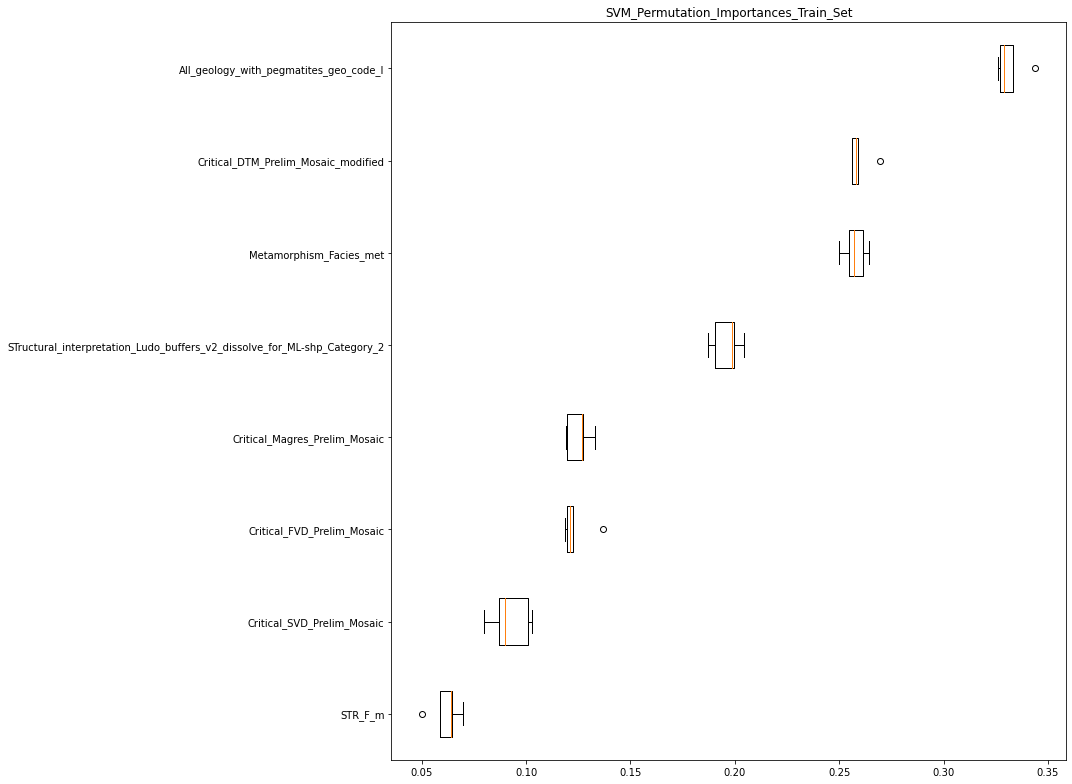

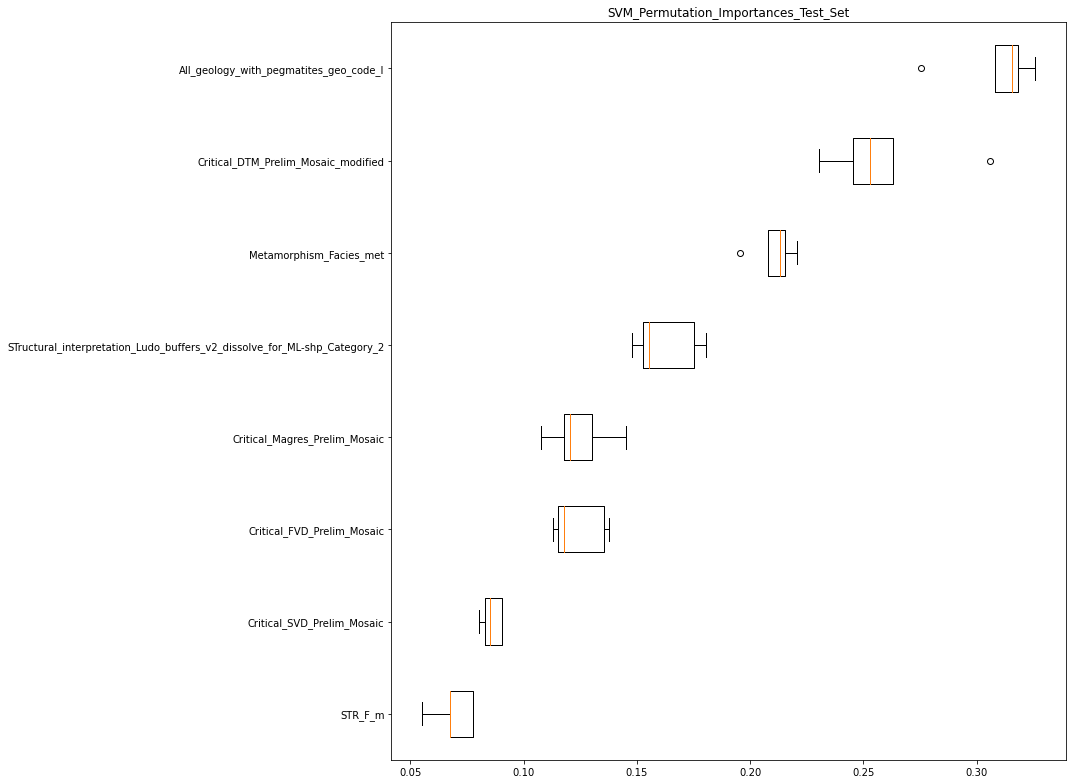

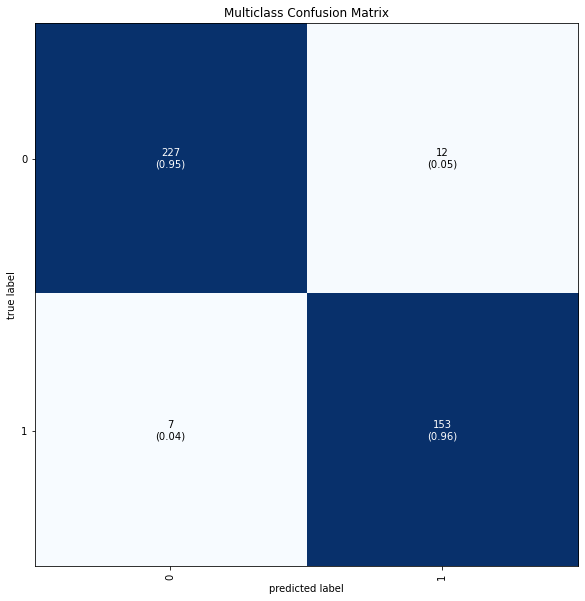

This function accepts dataframes from memory as well as from disk. In-memory dataframes will be very fast obviously.
Rasterizing...
Column : predictions
Done.  See file Baseline_Model_June27_trial1/predictions/SVM_predictions/predictions.tif
Column : 0_probability
Done.  See file Baseline_Model_June27_trial1/predictions/SVM_predictions/0_probability.tif
Column : 1_probability
Done.  See file Baseline_Model_June27_trial1/predictions/SVM_predictions/1_probability.tif
Column : maxProb
Done.  See file Baseline_Model_June27_trial1/predictions/SVM_predictions/maxProb.tif
Column : entropy
Done.  See file Baseline_Model_June27_trial1/predictions/SVM_predictions/entropy.tif
Completed. Time elapsed (s) : 
37.100584745407104


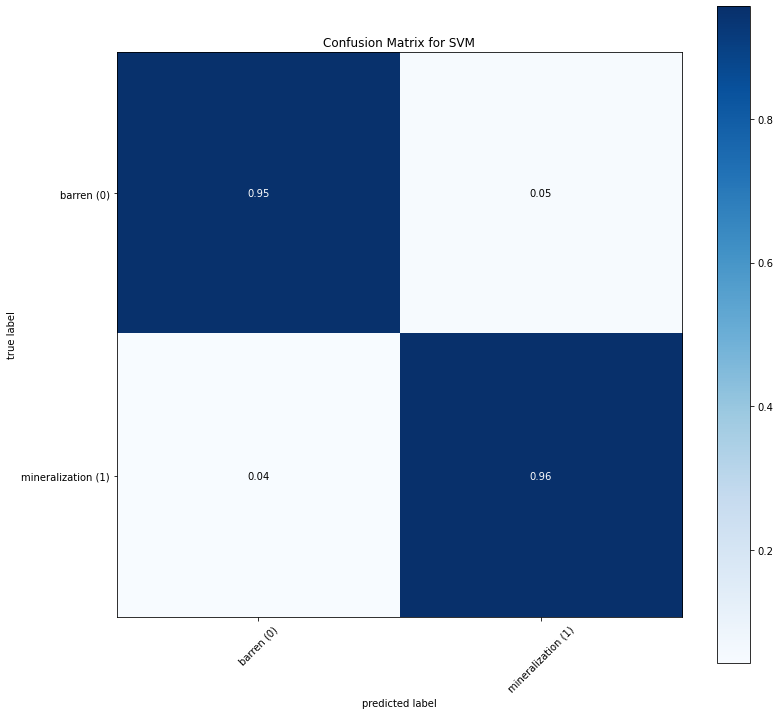

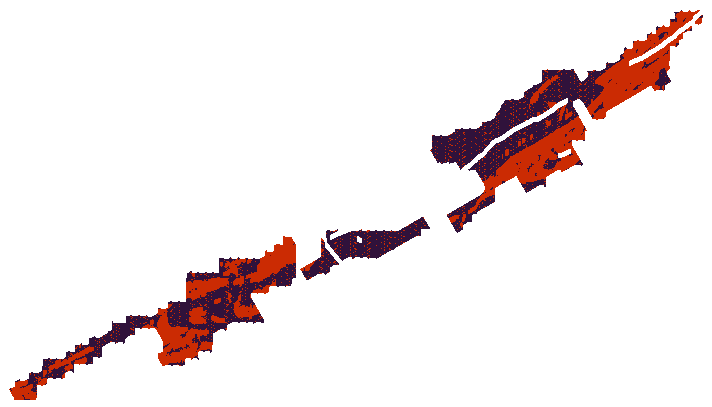

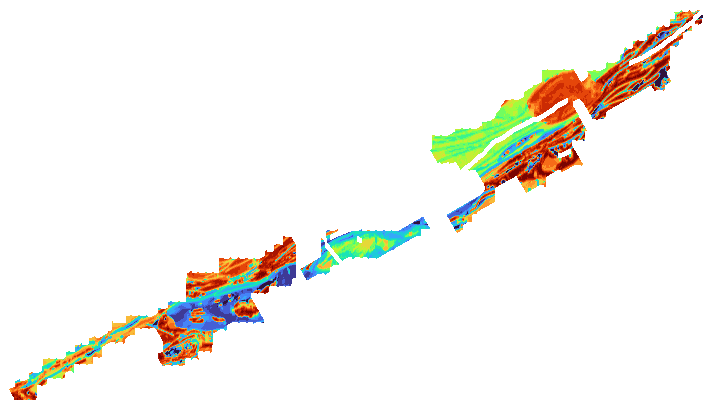

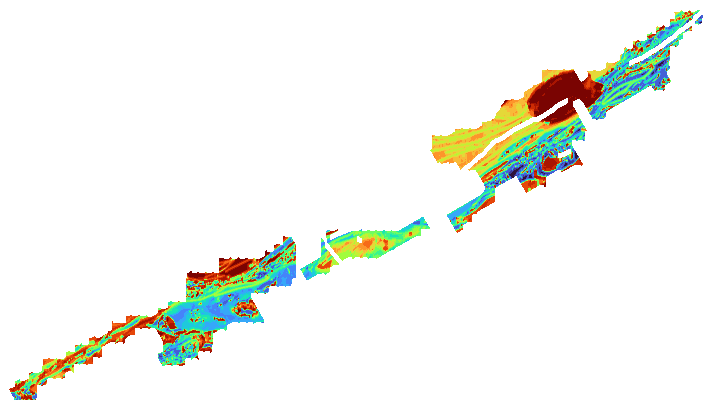

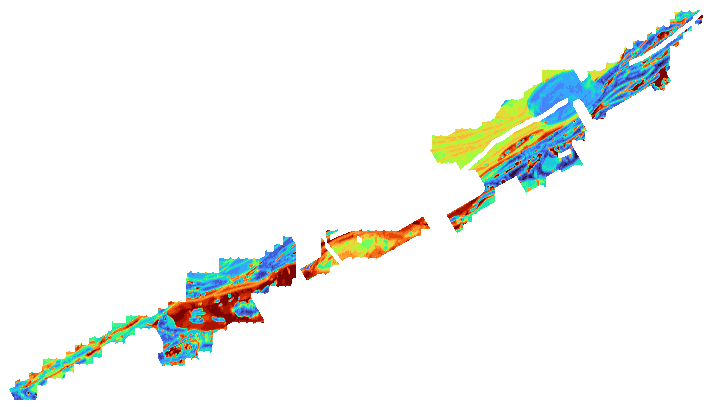

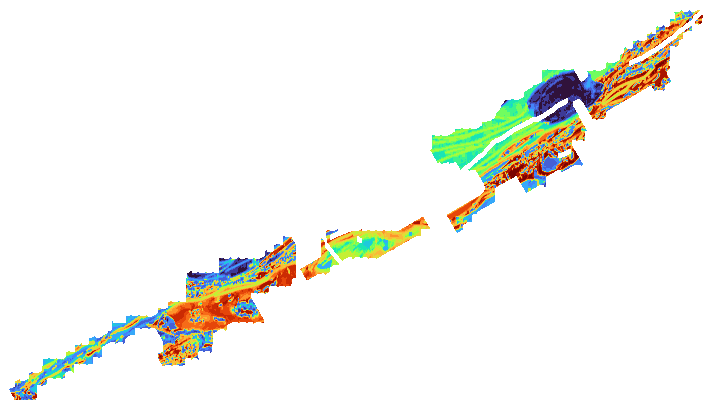

CatBoost_bestpipeline_fitted_model


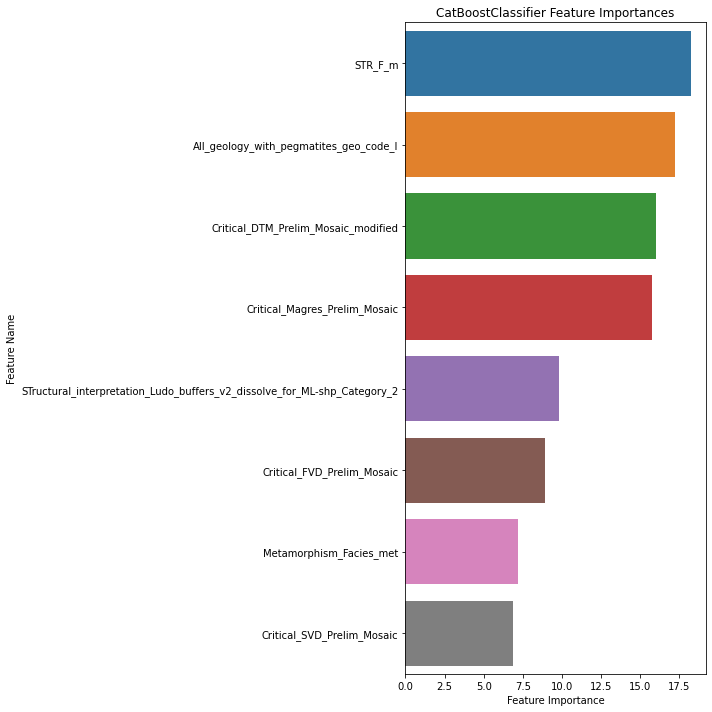

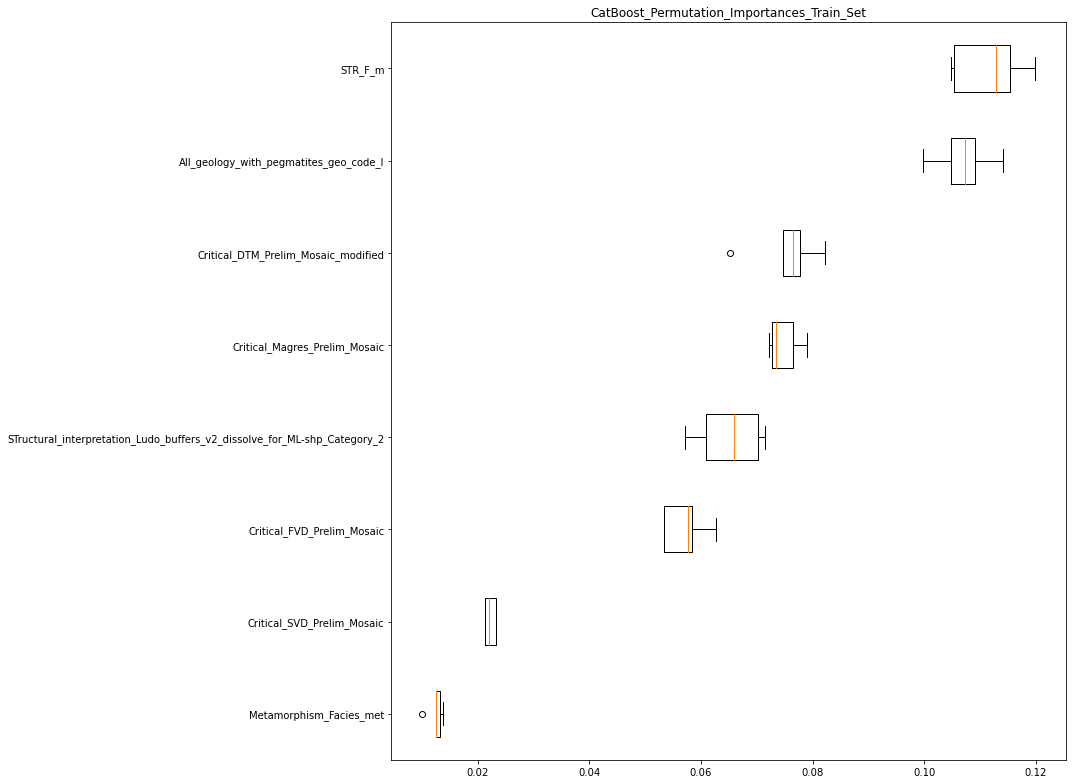

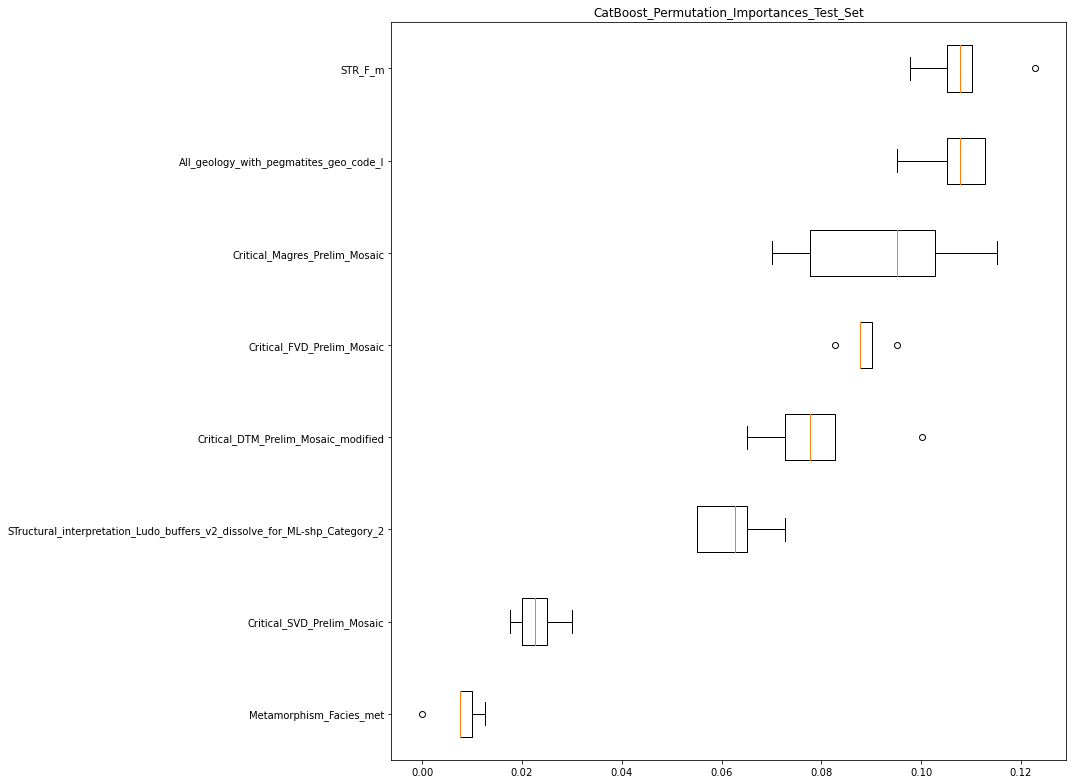

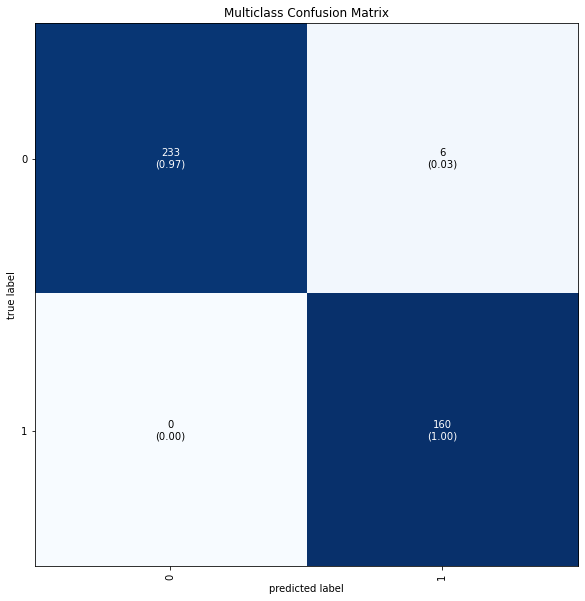

This function accepts dataframes from memory as well as from disk. In-memory dataframes will be very fast obviously.
Rasterizing...
Column : predictions
Done.  See file Baseline_Model_June27_trial1/predictions/CatBoost_predictions/predictions.tif
Column : 0_probability
Done.  See file Baseline_Model_June27_trial1/predictions/CatBoost_predictions/0_probability.tif
Column : 1_probability
Done.  See file Baseline_Model_June27_trial1/predictions/CatBoost_predictions/1_probability.tif
Column : maxProb
Done.  See file Baseline_Model_June27_trial1/predictions/CatBoost_predictions/maxProb.tif
Column : entropy
Done.  See file Baseline_Model_June27_trial1/predictions/CatBoost_predictions/entropy.tif
Completed. Time elapsed (s) : 
30.578169584274292


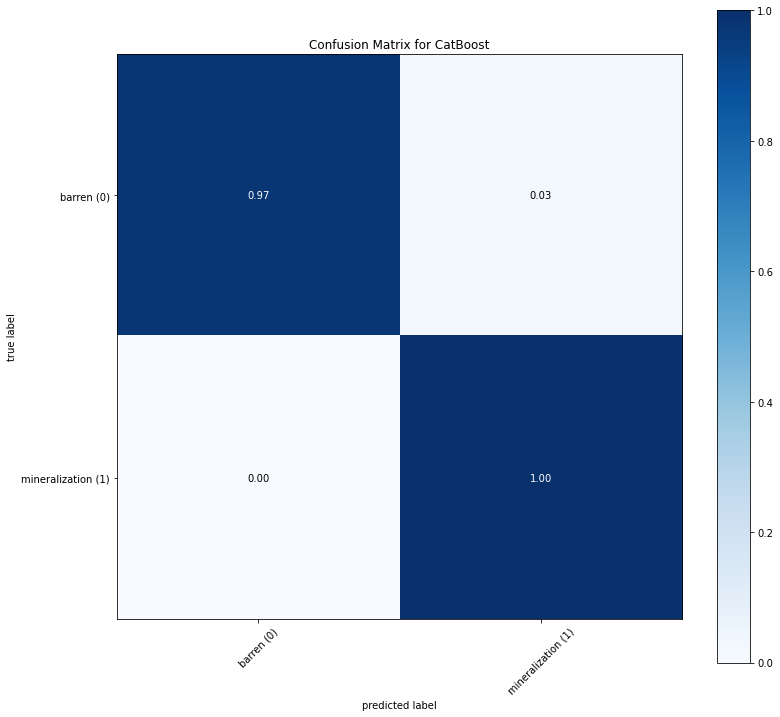

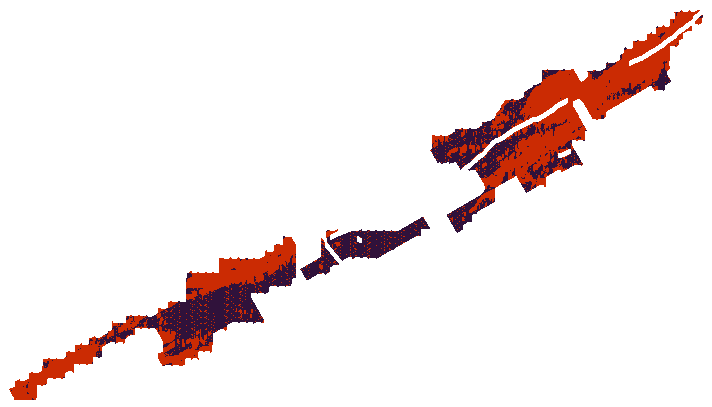

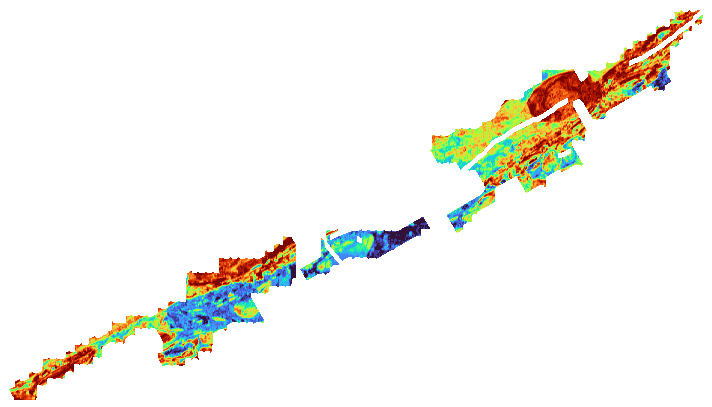

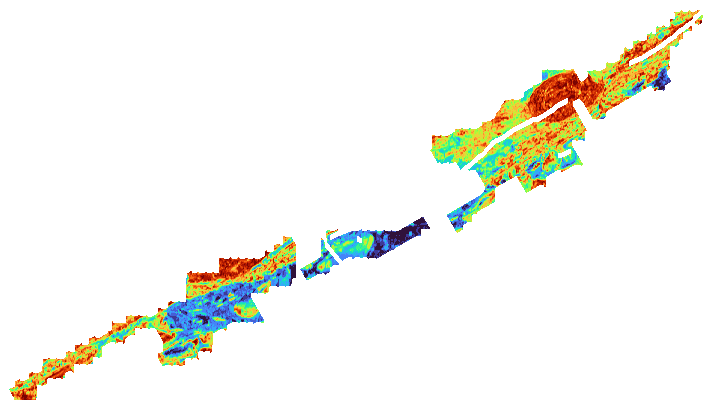

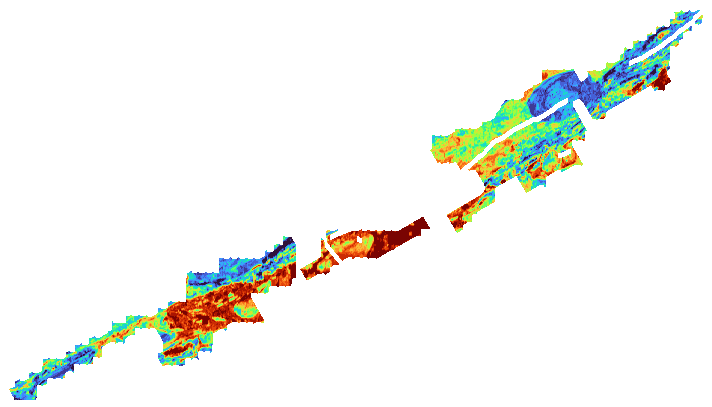

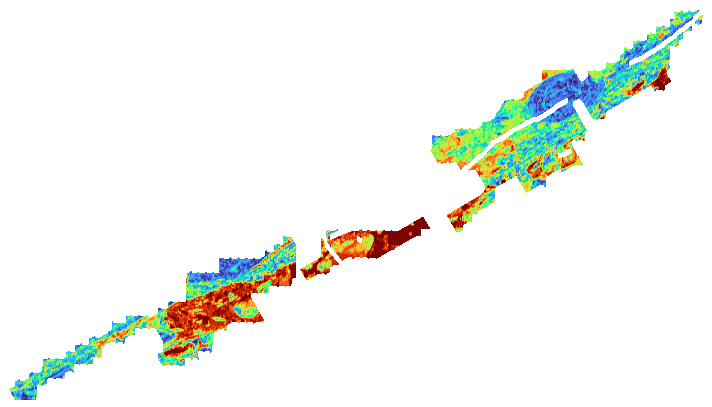

LGBM_bestpipeline_fitted_model


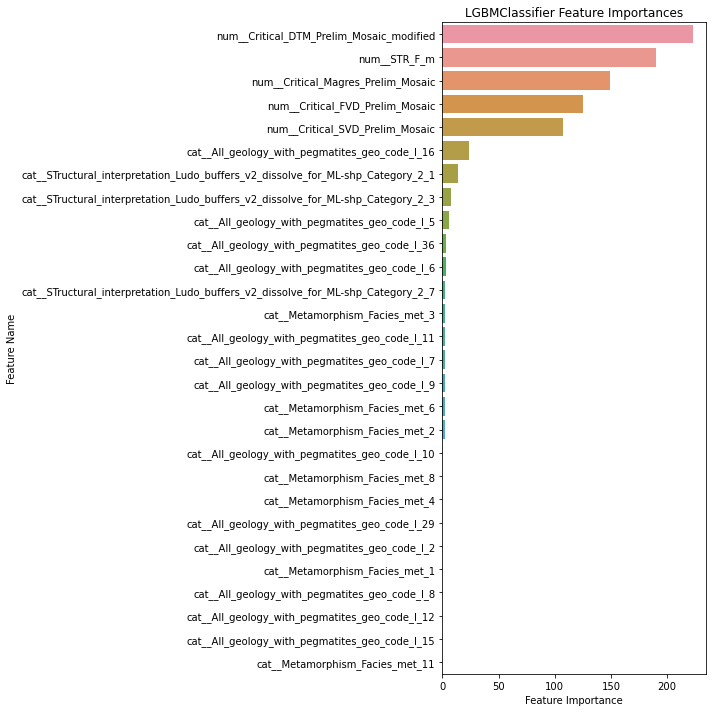

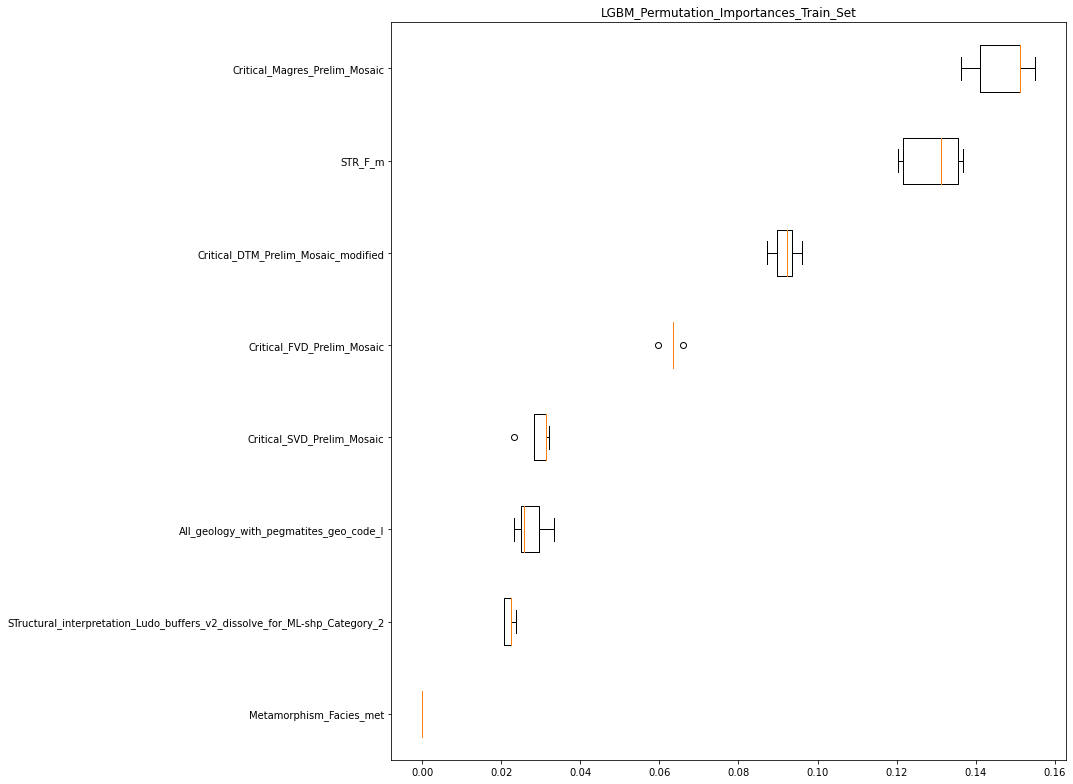

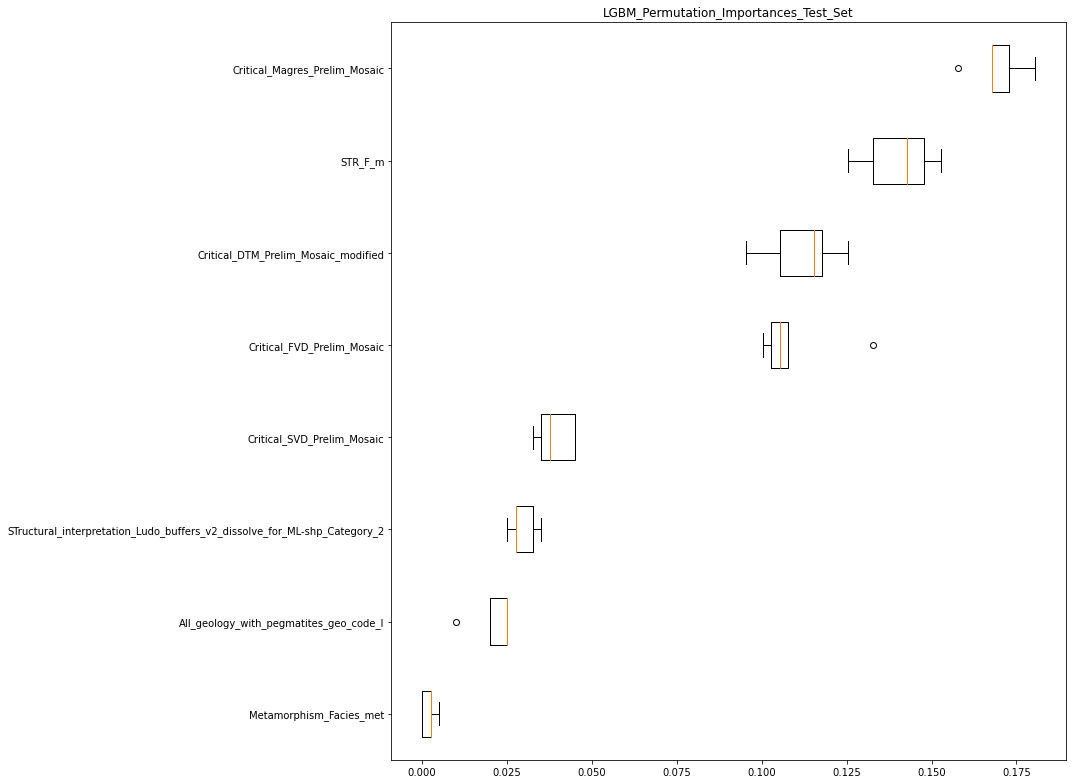

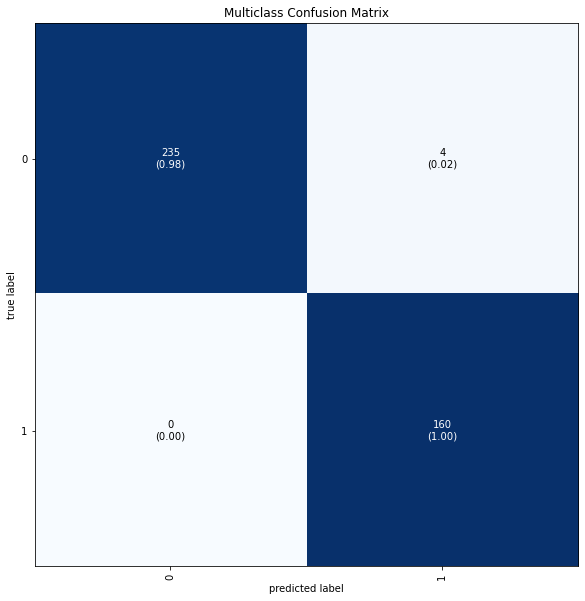

This function accepts dataframes from memory as well as from disk. In-memory dataframes will be very fast obviously.
Rasterizing...
Column : predictions
Done.  See file Baseline_Model_June27_trial1/predictions/LGBM_predictions/predictions.tif
Column : 0_probability
Done.  See file Baseline_Model_June27_trial1/predictions/LGBM_predictions/0_probability.tif
Column : 1_probability
Done.  See file Baseline_Model_June27_trial1/predictions/LGBM_predictions/1_probability.tif
Column : maxProb
Done.  See file Baseline_Model_June27_trial1/predictions/LGBM_predictions/maxProb.tif
Column : entropy
Done.  See file Baseline_Model_June27_trial1/predictions/LGBM_predictions/entropy.tif
Completed. Time elapsed (s) : 
28.352810382843018


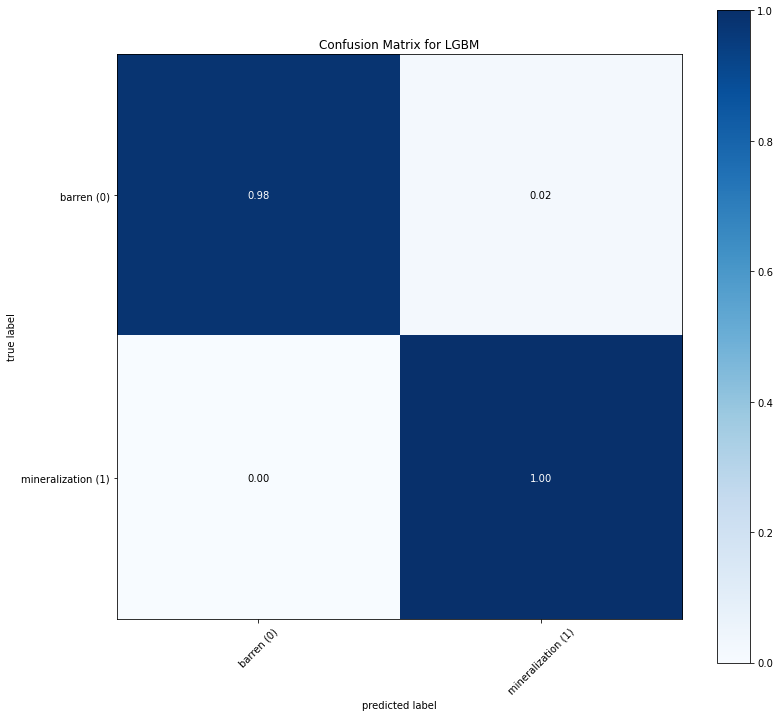

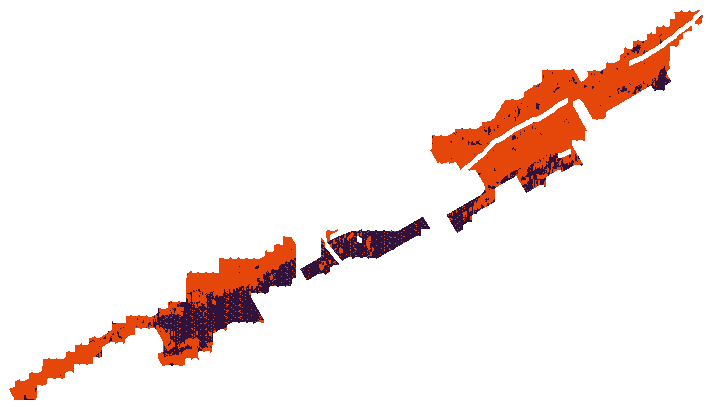

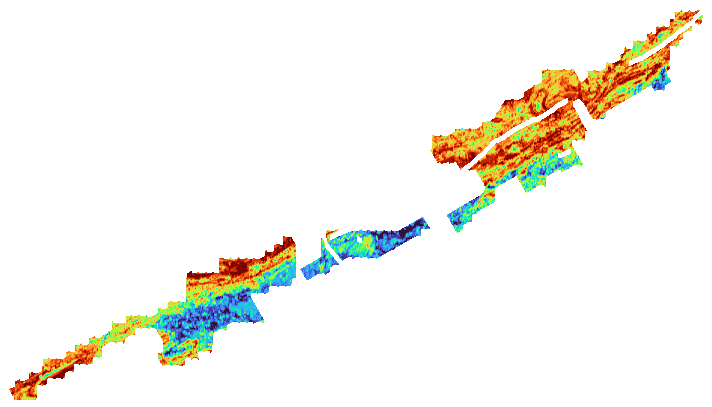

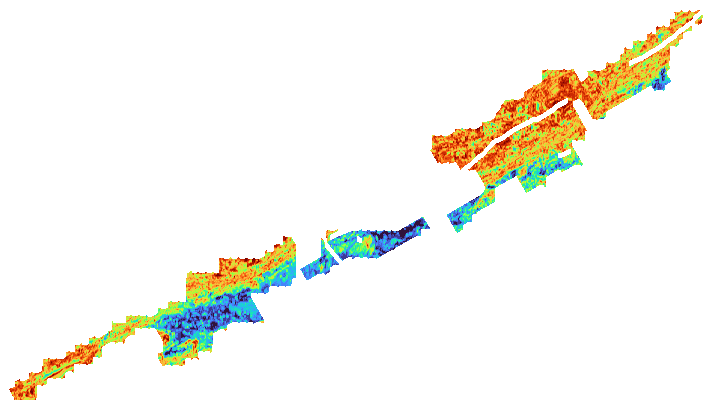

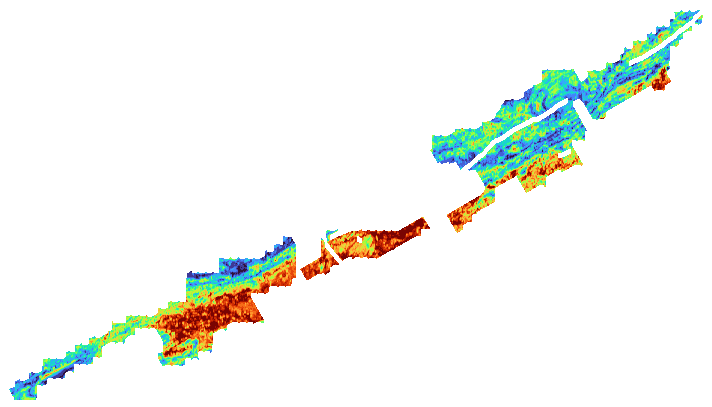

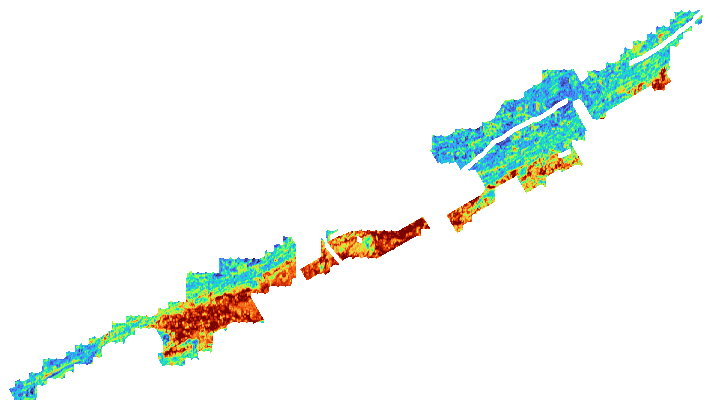

RandomForest_bestpipeline_fitted_model


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


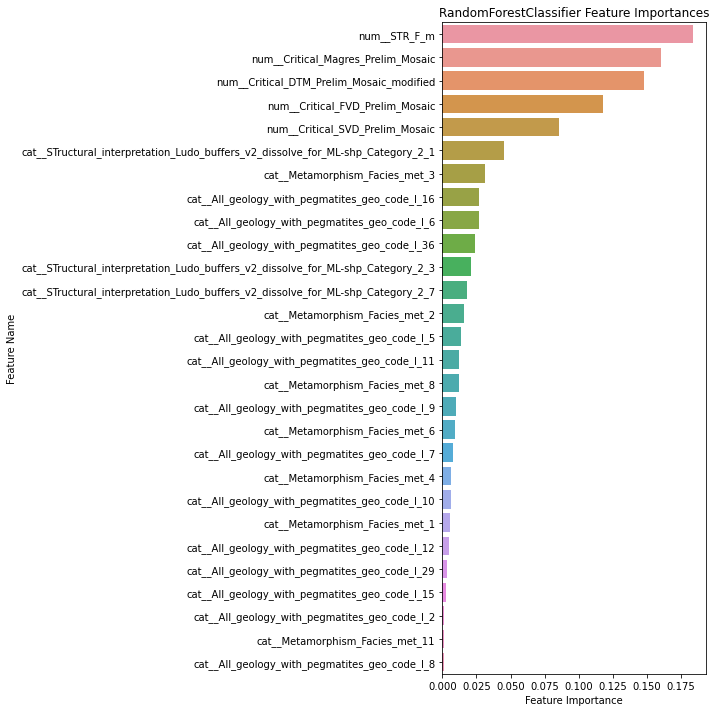

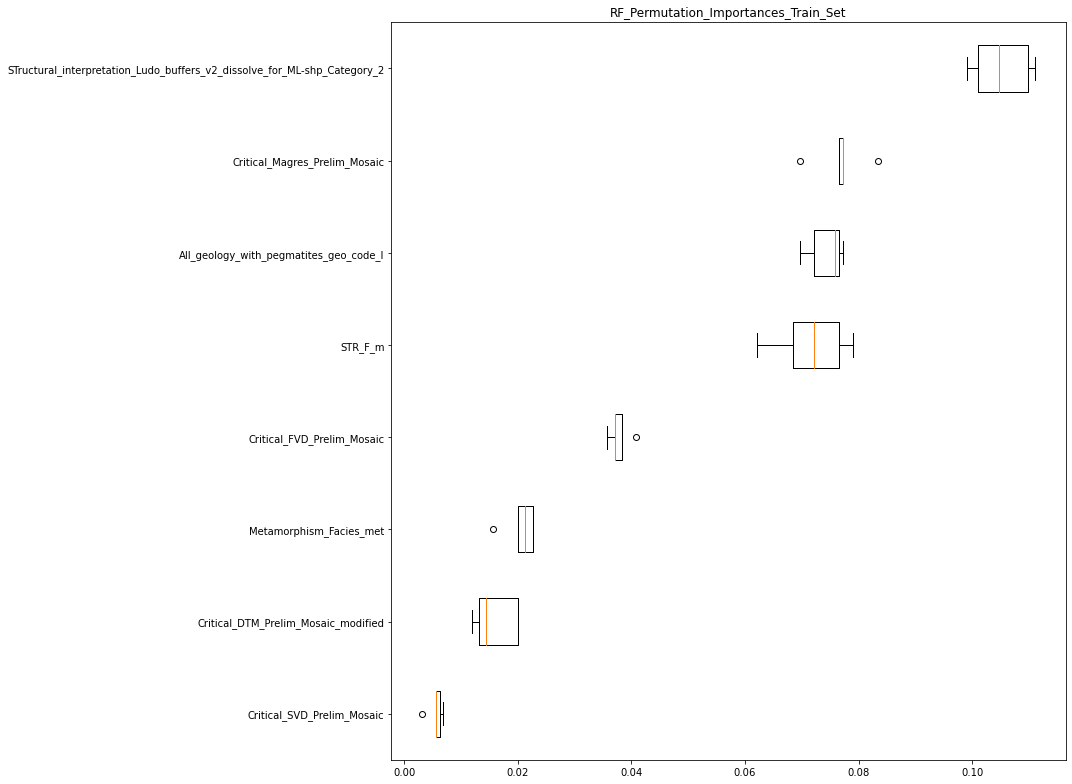

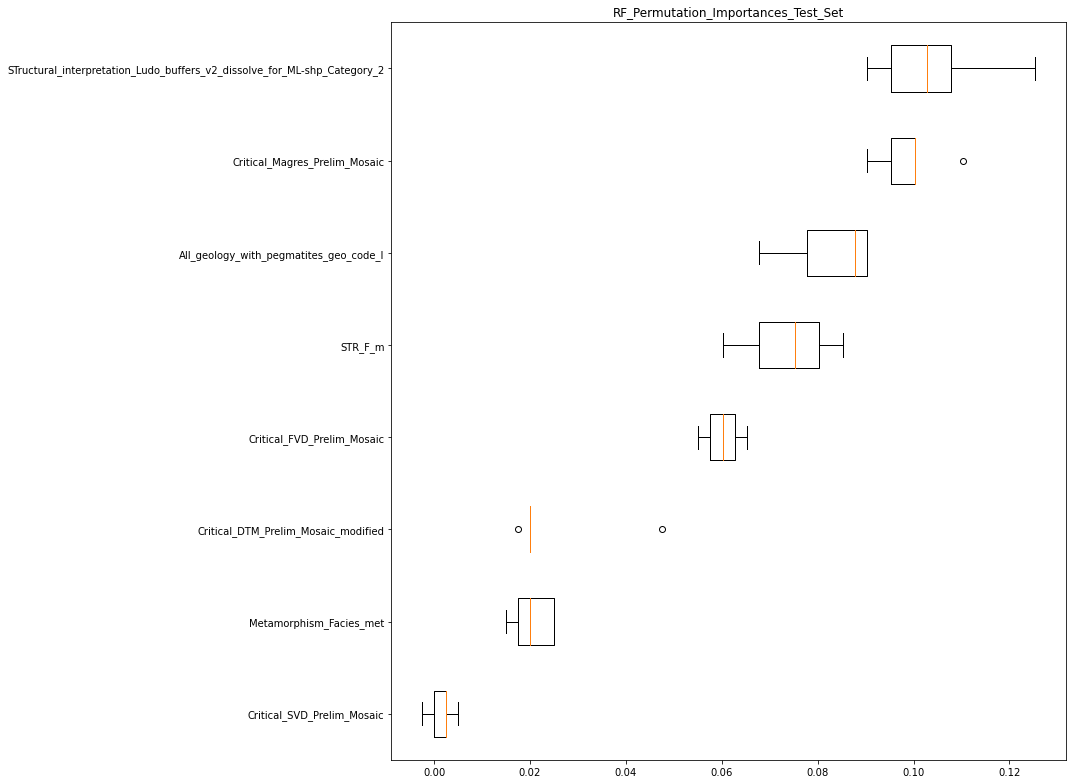

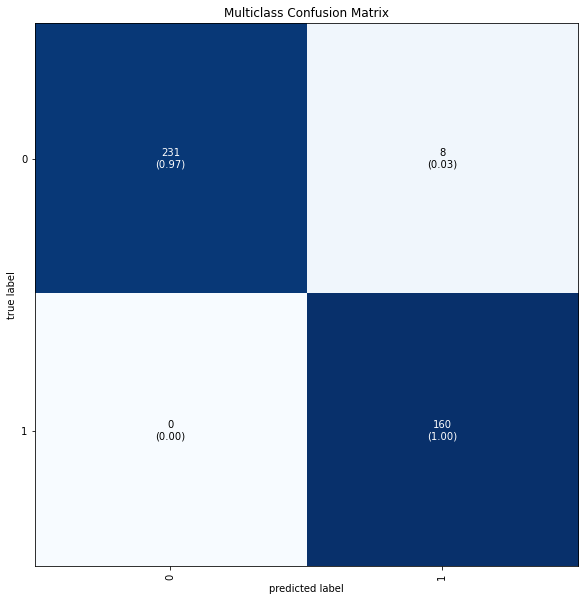

This function accepts dataframes from memory as well as from disk. In-memory dataframes will be very fast obviously.
Rasterizing...
Column : predictions
Done.  See file Baseline_Model_June27_trial1/predictions/RF_predictions/predictions.tif
Column : 0_probability
Done.  See file Baseline_Model_June27_trial1/predictions/RF_predictions/0_probability.tif
Column : 1_probability
Done.  See file Baseline_Model_June27_trial1/predictions/RF_predictions/1_probability.tif
Column : maxProb
Done.  See file Baseline_Model_June27_trial1/predictions/RF_predictions/maxProb.tif
Column : entropy
Done.  See file Baseline_Model_June27_trial1/predictions/RF_predictions/entropy.tif
Completed. Time elapsed (s) : 
38.77679681777954


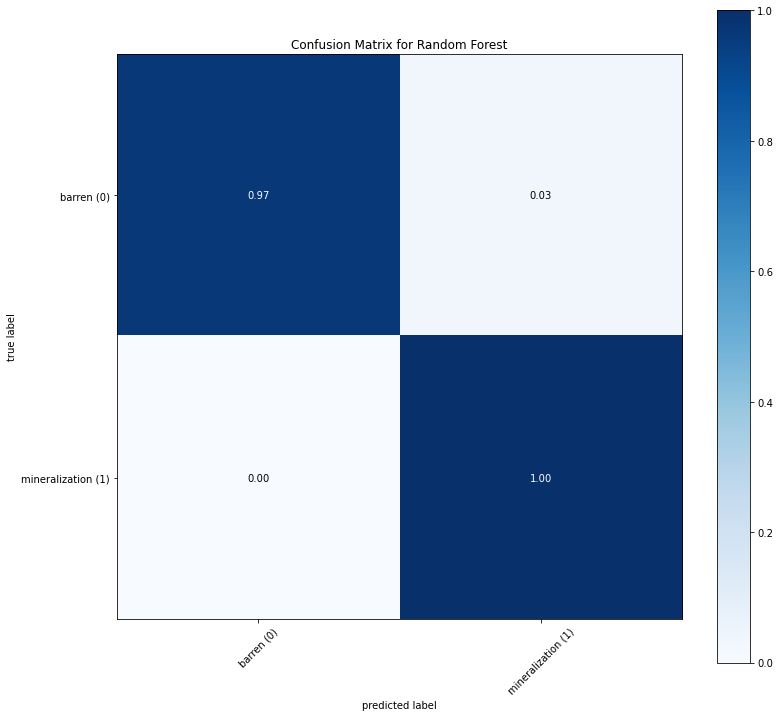

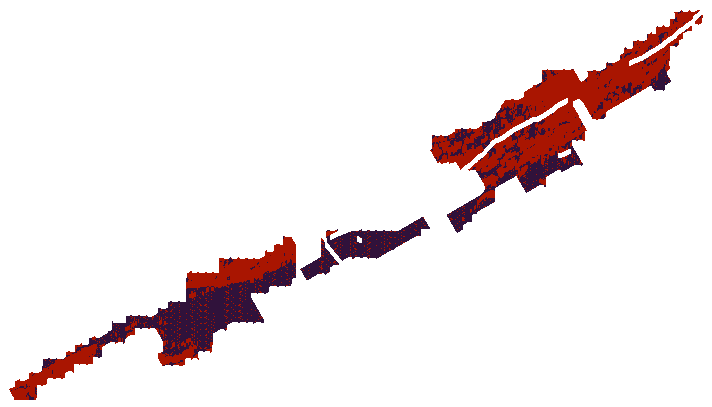

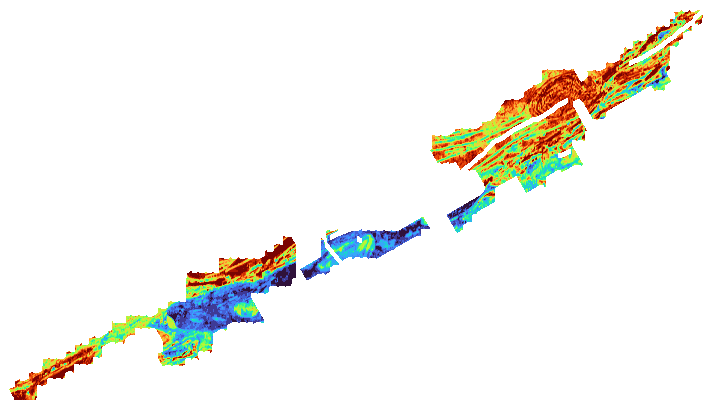

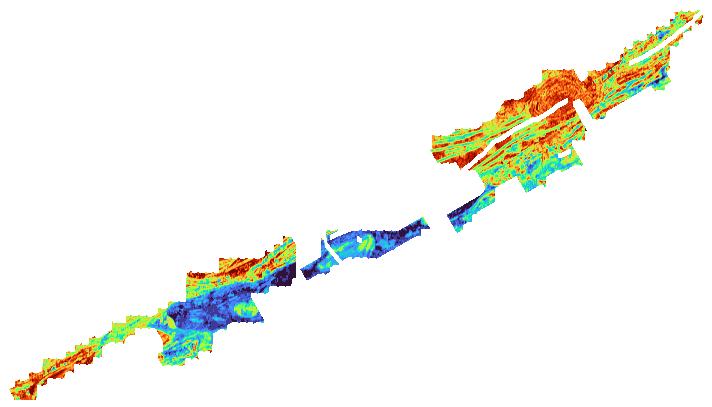

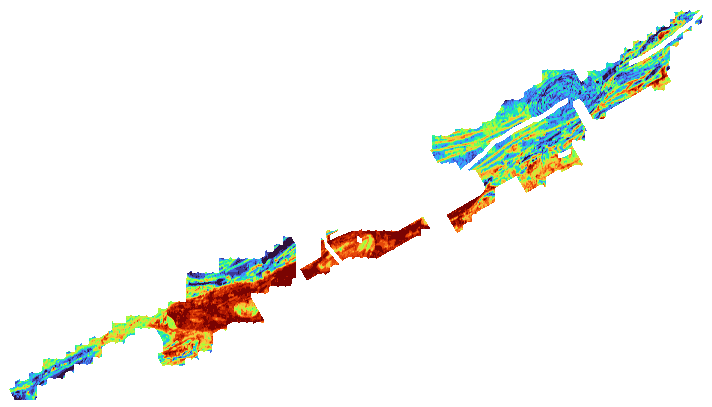

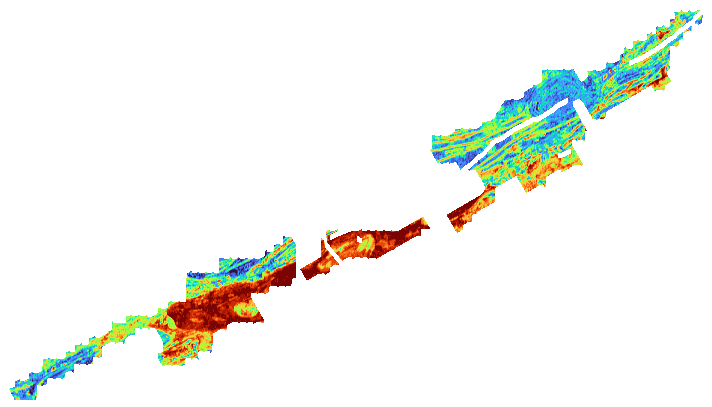

In [165]:
best_fitted_models = hyperparameterstuning.loadJobsFromFolder(output_folder+"/models/")
metrics = {}

for model in best_fitted_models.keys():
    print(model)
    model_path = output_folder + 'models/' + f'{model}.joblib'
    
    # load models from disk
    if model == 'SVM_bestpipeline_fitted_model':
        SVM_bestpipeline_fitted_model = load(model_path)
        plot_permutation_importance(SVM_bestpipeline_fitted_model, X_train, y_train, output_directory=SVM_predictions_folder, 
                            title= 'SVM_Permutation_Importances_Train_Set')
        plot_permutation_importance(SVM_bestpipeline_fitted_model, X_test, y_test, output_directory=SVM_predictions_folder, 
                            title= 'SVM_Permutation_Importances_Test_Set')

        # Predictions on the test set
        y_pred = SVM_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["SVM"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        
        all_predictions = SVM_bestpipeline_fitted_model.predict(all_X)
        all_predicted_prob = SVM_bestpipeline_fitted_model.predict_proba(all_X)

        prob_class = ['0_probability','1_probability']
        predictions = cube.subset(['coordinates'])
        predictions['predictions'] = all_predictions.tolist()
        predictions[prob_class] = all_predicted_prob
        predictions['maxProb'] = np.max(all_predicted_prob, 1)
        from scipy.stats import entropy
        predictions['entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(len(np.unique(y_train)))
        correspondance_dict = {0: "0", 1: "1"}

        actual_classes = y_test.unique().tolist()
        actual_classes.sort()
        classes = replace_classes(actual_classes, correspondance_dict)

        reporting.multiclass_confusion_matrix_plot(y_test, y_pred, actual_classes, SVM_predictions_folder)
        confusion_matrix_plot(y_test, y_pred, title="SVM", output_directory=SVM_predictions_folder)

        predictions_columns = ['predictions', '0_probability', '1_probability', 'maxProb', 'entropy']
        utilities.csv_to_raster(predictions, os.path.join(SVM_predictions_folder), predictions_columns, None, 'x','y', crs)

        tifs = glob.glob(SVM_predictions_folder + '*.tif')        
        
        for t in tifs:
            filename,  extension, directory= utilities.Path_Info(t)
            utilities.geotiff_to_jpg(t, os.path.join(SVM_predictions_folder, filename + '.jpg')) 
        
    if model == 'CatBoost_bestpipeline_fitted_model':
        CatBoost_bestpipeline_fitted_model = load(model_path)
        plot_feature_importance(CatBoost_bestpipeline_fitted_model['clf'], 
                          CatBoost_bestpipeline_fitted_model.feature_names_in_,
                          output_directory=CatBoost_predictions_folder, 
                          title= 'CatBoost_Feature_Importances.png')
        plot_permutation_importance(CatBoost_bestpipeline_fitted_model, X_train, y_train, output_directory=CatBoost_predictions_folder, 
                            title= 'CatBoost_Permutation_Importances_Train_Set')
        plot_permutation_importance(CatBoost_bestpipeline_fitted_model, X_test, y_test, output_directory=CatBoost_predictions_folder, 
                            title= 'CatBoost_Permutation_Importances_Test_Set')
        
        # Predictions on the test set
        y_pred = CatBoost_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["CatBoost"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        
        all_predictions = CatBoost_bestpipeline_fitted_model.predict(all_X)
        all_predicted_prob = CatBoost_bestpipeline_fitted_model.predict_proba(all_X)

        prob_class = ['0_probability','1_probability']
        predictions = cube.subset(['coordinates'])
        predictions['predictions'] = all_predictions.tolist()
        predictions[prob_class] = all_predicted_prob
        predictions['maxProb'] = np.max(all_predicted_prob, 1)
        from scipy.stats import entropy
        predictions['entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(len(np.unique(y_train)))
        correspondance_dict = {0: "0", 1: "1"}

        actual_classes = y_test.unique().tolist()
        actual_classes.sort()
        classes = replace_classes(actual_classes, correspondance_dict)

        reporting.multiclass_confusion_matrix_plot(y_test, y_pred, actual_classes, CatBoost_predictions_folder)
        confusion_matrix_plot(y_test, y_pred, title="CatBoost", output_directory=CatBoost_predictions_folder)

        predictions_columns = ['predictions', '0_probability', '1_probability', 'maxProb', 'entropy']
        utilities.csv_to_raster(predictions, os.path.join(CatBoost_predictions_folder), predictions_columns, None, 'x','y', crs)
        
        tifs = glob.glob(CatBoost_predictions_folder + '*.tif')

        for t in tifs:
            filename,  extension, directory= utilities.Path_Info(t)
            utilities.geotiff_to_jpg(t, os.path.join(CatBoost_predictions_folder, filename + '.jpg'))    
        
    if model == 'XGBoost_bestpipeline_fitted_model':
        XGBoost_bestpipeline_fitted_model = load(model_path)
        plot_feature_importance(XGBoost_bestpipeline_fitted_model['clf'], 
                          XGBoost_bestpipeline_fitted_model['pre'].get_feature_names_out(),
                          output_directory=XGBoost_predictions_folder, 
                          title= 'XGBoost_Feature_Importances.png')
        plot_permutation_importance(XGBoost_bestpipeline_fitted_model, X_train, y_train, output_directory=XGBoost_predictions_folder, 
                            title= 'XGBoost_Permutation_Importances_Train_Set')
        plot_permutation_importance(XGBoost_bestpipeline_fitted_model, X_test, y_test, output_directory=XGBoost_predictions_folder, 
                            title= 'XGBoost_Permutation_Importances_Test_Set')
        
        # Predictions on the test set
        y_pred = XGBoost_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["XGBoost"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        
        all_predictions = XGBoost_bestpipeline_fitted_model.predict(all_X)
        all_predicted_prob = XGBoost_bestpipeline_fitted_model.predict_proba(all_X)

        prob_class = ['0_probability','1_probability']
        predictions = cube.subset(['coordinates'])
        predictions['predictions'] = all_predictions.tolist()
        predictions[prob_class] = all_predicted_prob
        predictions['maxProb'] = np.max(all_predicted_prob, 1)
        from scipy.stats import entropy
        predictions['entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(len(np.unique(y_train)))
        correspondance_dict = {0: "0", 1: "1"}

        actual_classes = y_test.unique().tolist()
        actual_classes.sort()
        classes = replace_classes(actual_classes, correspondance_dict)

        reporting.multiclass_confusion_matrix_plot(y_test, y_pred, actual_classes, XGBoost_predictions_folder)
        confusion_matrix_plot(y_test, y_pred, title="XGBoost", output_directory=XGBoost_predictions_folder)

        predictions_columns = ['predictions', '0_probability', '1_probability', 'maxProb', 'entropy']
        utilities.csv_to_raster(predictions, os.path.join(XGBoost_predictions_folder), predictions_columns, None, 'x','y', crs)

        tifs = glob.glob(XGBoost_predictions_folder + '*.tif')

        for t in tifs:
            filename,  extension, directory= utilities.Path_Info(t)
            utilities.geotiff_to_jpg(t, os.path.join(XGBoost_predictions_folder, filename + '.jpg'))
                
    if model == 'LGBM_bestpipeline_fitted_model':
        LGBM_bestpipeline_fitted_model = load(model_path)
        plot_feature_importance(LGBM_bestpipeline_fitted_model['clf'], 
                          LGBM_bestpipeline_fitted_model['pre'].get_feature_names_out(),
                          output_directory=LGBM_predictions_folder, 
                          title= 'LGBM_Feature_Importances.png')       
        plot_permutation_importance(LGBM_bestpipeline_fitted_model, X_train, y_train, output_directory=LGBM_predictions_folder, 
                            title= 'LGBM_Permutation_Importances_Train_Set')
        plot_permutation_importance(LGBM_bestpipeline_fitted_model, X_test, y_test, output_directory=LGBM_predictions_folder, 
                            title= 'LGBM_Permutation_Importances_Test_Set')
        
        # Predictions on the test set
        y_pred = LGBM_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["LGBM"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        
        all_predictions = LGBM_bestpipeline_fitted_model.predict(all_X)
        all_predicted_prob = LGBM_bestpipeline_fitted_model.predict_proba(all_X)

        prob_class = ['0_probability','1_probability']
        predictions = cube.subset(['coordinates'])
        predictions['predictions'] = all_predictions.tolist()
        predictions[prob_class] = all_predicted_prob
        predictions['maxProb'] = np.max(all_predicted_prob, 1)
        from scipy.stats import entropy
        predictions['entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(len(np.unique(y_train)))
        correspondance_dict = {0: "0", 1: "1"}

        actual_classes = y_test.unique().tolist()
        actual_classes.sort()
        classes = replace_classes(actual_classes, correspondance_dict)

        reporting.multiclass_confusion_matrix_plot(y_test, y_pred, actual_classes, LGBM_predictions_folder)
        confusion_matrix_plot(y_test, y_pred, title="LGBM", output_directory=LGBM_predictions_folder)

        predictions_columns = ['predictions', '0_probability', '1_probability', 'maxProb', 'entropy']
        utilities.csv_to_raster(predictions, os.path.join(LGBM_predictions_folder), predictions_columns, None, 'x','y', crs)

        tifs = glob.glob(LGBM_predictions_folder + '*.tif')

        for t in tifs:
            filename,  extension, directory= utilities.Path_Info(t)
            utilities.geotiff_to_jpg(t, os.path.join(LGBM_predictions_folder, filename + '.jpg'))
        
    if model == 'RandomForest_bestpipeline_fitted_model':
        RandomForest_bestpipeline_fitted_model = load(model_path)
        plot_feature_importance(RandomForest_bestpipeline_fitted_model['clf'], 
                          RandomForest_bestpipeline_fitted_model['pre'].get_feature_names_out(),
                          output_directory=RF_predictions_folder, 
                          title= 'RF_Feature_Importances.png')        
        plot_permutation_importance(RandomForest_bestpipeline_fitted_model, X_train, y_train, output_directory=RF_predictions_folder, 
                            title= 'RF_Permutation_Importances_Train_Set')
        plot_permutation_importance(RandomForest_bestpipeline_fitted_model, X_test, y_test, output_directory=RF_predictions_folder, 
                            title= 'RF_Permutation_Importances_Test_Set')
        
        # Predictions on the test set
        y_pred = RandomForest_bestpipeline_fitted_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        metrics["Random Forest"] = {"f1": f1, "Precision": prec, "Recall":recall, "Accuracy":acc}
        
        all_predictions = RandomForest_bestpipeline_fitted_model.predict(all_X)
        all_predicted_prob = RandomForest_bestpipeline_fitted_model.predict_proba(all_X)

        prob_class = ['0_probability','1_probability']
        predictions = cube.subset(['coordinates'])
        predictions['predictions'] = all_predictions.tolist()
        predictions[prob_class] = all_predicted_prob
        predictions['maxProb'] = np.max(all_predicted_prob, 1)
        from scipy.stats import entropy
        predictions['entropy'] = entropy(all_predicted_prob, axis = 1)/np.log(len(np.unique(y_train)))
        correspondance_dict = {0: "0", 1: "1"}

        actual_classes = y_test.unique().tolist()
        actual_classes.sort()
        classes = replace_classes(actual_classes, correspondance_dict)

        reporting.multiclass_confusion_matrix_plot(y_test, y_pred, actual_classes, RF_predictions_folder)
        confusion_matrix_plot(y_test, y_pred, title="Random Forest", output_directory=RF_predictions_folder)

        predictions_columns = ['predictions', '0_probability', '1_probability', 'maxProb', 'entropy']
        utilities.csv_to_raster(predictions, os.path.join(RF_predictions_folder), predictions_columns, None, 'x','y', crs)

        tifs = glob.glob(RF_predictions_folder + '*.tif')

        for t in tifs:
            filename,  extension, directory= utilities.Path_Info(t)
            utilities.geotiff_to_jpg(t, os.path.join(RF_predictions_folder, filename + '.jpg'))
         

In [166]:
actual_classes

[0, 1]

In [167]:
##fe.plot_feature_importance(RandomForest_bestpipeline_fitted_model['clf'],
##    RandomForest_bestpipeline_fitted_model['pre'].get_feature_names_out(), 
    # RandomForest_bestpipeline_fitted_model.feature_names_in_.tolist(),
##    # columns['numerical'] + columns['categories']
##    output_directory=RF_predictions_folder, 
##    title= 'RF_Feature_Importances.png')

,col_name,feature_importance_vals
4,STR_F_m,1.310020
0,Critical_DTM_Prelim_Mosaic_modified,1.129478
1,Critical_Magres_Prelim_Mosaic,0.905251
5,All_geology_with_pegmatites_geo_code_l,0.700150
7,STructural_interpretation_Ludo_buffers_v2_diss...,0.282354
2,Critical_FVD_Prelim_Mosaic,0.233391
6,Metamorphism_Facies_met,0.190031
3,Critical_SVD_Prelim_Mosaic,0.146776


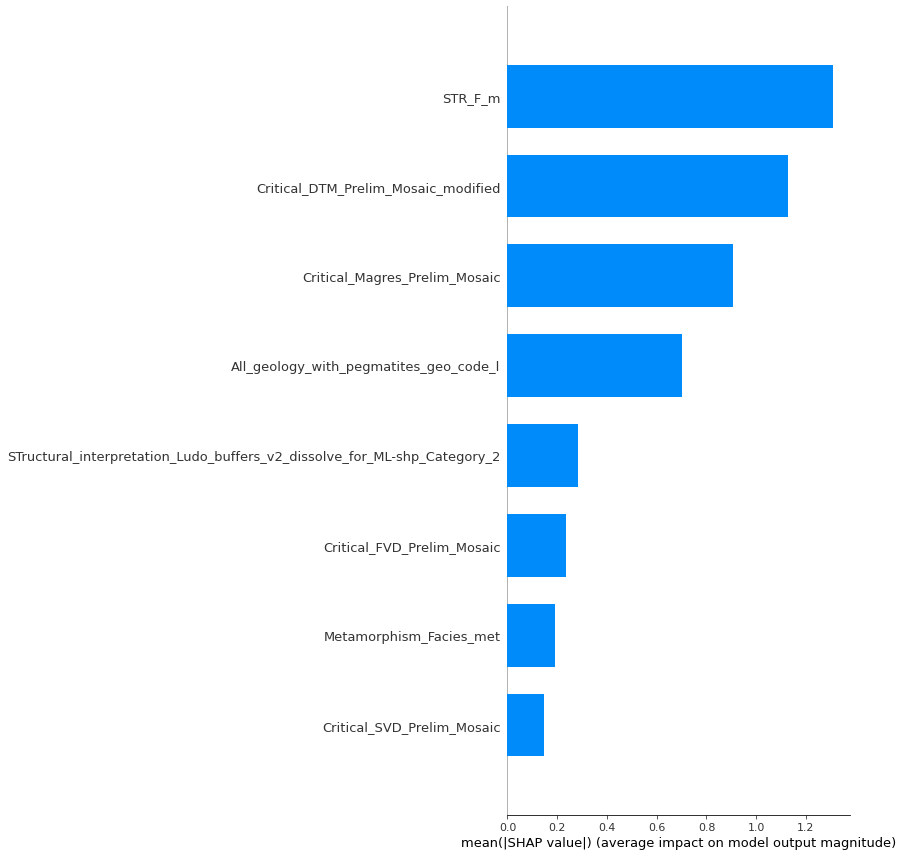

In [168]:
fe.plot_shap_values(CatBoost_bestpipeline_fitted_model['clf'], X_test,
                          output_directory=CatBoost_predictions_folder, 
                          title= 'CatBoost_SHAP_values.png')

In [169]:
metrics

{'SVM': {'f1': 0.9506846641730362,
  'Precision': 0.9486790986790987,
  'Recall': 0.9530203974895397,
  'Accuracy': 0.9523809523809523},
 'CatBoost': {'f1': 0.9844416138088801,
  'Precision': 0.9819277108433735,
  'Recall': 0.9874476987447699,
  'Accuracy': 0.9849624060150376},
 'LGBM': {'f1': 0.9896077512111268,
  'Precision': 0.9878048780487805,
  'Recall': 0.9916317991631799,
  'Accuracy': 0.9899749373433584},
 'Random Forest': {'f1': 0.9792942397509081,
  'Precision': 0.9761904761904762,
  'Recall': 0.9832635983263598,
  'Accuracy': 0.9799498746867168}}

In [170]:
def compare_models(metrics, **kwargs):
    """
    Compare models and create a plot of metrics provided in the nested dictionary
    
    Parameters
    ----------
    metrics : dict
        Dictionary with all models and related metrics
    set_size : OPTIONAL, tuple
        Set the figure size in inches -> Example: (15, 11)
    output_directory : OPTIONAL, str
        The path of the plot
    
    Example:
    
    metrics = {}
    metrics["CatBoost"] = {"f1": 0.78, "prec": 0.79, "acc":0.77}
    metrics["Random Forest"] = {"f1": 0.68, "prec": 0.69, "acc":0.67}
   
    compare_models(metrics, output_directory="./")
    
    """
    
    metrics_df = pd.DataFrame(metrics)
    metrics_df = metrics_df.reindex(metrics_df.mean().sort_values().index, axis=1)
        
    if "set_size" in kwargs:
        ax = metrics_df.transpose().plot.barh(figsize=(kwargs['set_size'][0], kwargs['set_size'][1]), zorder=10)
    else:
        ax = metrics_df.transpose().plot.barh(figsize=(12,8), zorder=10)
    
    ax.set_title('Model Comparison', fontsize=20)
    ax.set_xlabel("Score", size = 20)
    ax.set_yticklabels(metrics_df.transpose().index.values.tolist(), rotation=45, 
                   rotation_mode="anchor", 
                   size = 15)
    ax.set_xlim([0.0, 1.0])
    ax.set_xticks(np.linspace(0, 1, 11, endpoint = True))
    ax.legend()
    ax.grid(zorder=5)
    leg = ax.legend(loc='upper right', fontsize=15, ncol=1, framealpha=.5)
    leg.set_zorder(100)
       
    if "output_directory" in kwargs:
        plt.savefig(os.path.join(kwargs['output_directory'], 'model_comparison.png'), dpi=100)
    
    return metrics_df

,SVM,Random Forest,CatBoost,LGBM
f1,0.950685,0.979294,0.984442,0.989608
Precision,0.948679,0.976190,0.981928,0.987805
Recall,0.953020,0.983264,0.987448,0.991632
Accuracy,0.952381,0.979950,0.984962,0.989975


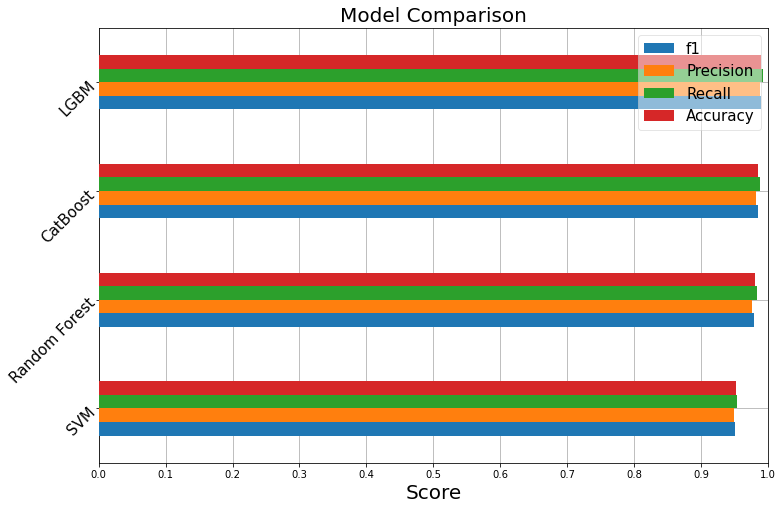

In [171]:
compare_models(metrics, output_directory=os.path.join(reporting_folder))

In [172]:
predictions[predictions['predictions'] == 0]

,,predictions,0_probability,1_probability,maxProb,entropy
x,y,,,,,
492842.5,5753117.5,0,0.833764,0.166236,0.833764,0.649020
492847.5,5753117.5,0,0.833764,0.166236,0.833764,0.649020
492832.5,5753112.5,0,0.832278,0.167722,0.832278,0.652467
492837.5,5753112.5,0,0.828580,0.171420,0.828580,0.660944
492842.5,5753112.5,0,0.827944,0.172056,0.827944,0.662386
...,...,...,...,...,...,...
406677.5,5703692.5,0,0.581427,0.418573,0.581427,0.980783
406682.5,5703692.5,0,0.575573,0.424427,0.575573,0.983457
406687.5,5703692.5,0,0.577785,0.422215,0.577785,0.982471


In [173]:
predictions[predictions['predictions'] == 1]

,,predictions,0_probability,1_probability,maxProb,entropy
x,y,,,,,
492802.5,5753132.5,1,0.348752,0.651248,0.651248,0.932949
492807.5,5753132.5,1,0.352609,0.647391,0.647391,0.936377
492812.5,5753132.5,1,0.362367,0.637633,0.637633,0.944630
492817.5,5753132.5,1,0.392308,0.607692,0.607692,0.966273
492822.5,5753132.5,1,0.395882,0.604118,0.604118,0.968490
...,...,...,...,...,...,...
406937.5,5703692.5,1,0.439528,0.560472,0.560472,0.989423
406942.5,5703692.5,1,0.443272,0.556728,0.556728,0.990695
406947.5,5703692.5,1,0.468425,0.531575,0.531575,0.997121


In [174]:
y_train

142104363    1
203258737    1
90881656     1
277069688    1
56866813     0
            ..
44240397     1
141997816    1
165065446    0
220013739    0
225366677    0
Name: CRE_all_Li_ne_and_pos_target_b10, Length: 1594, dtype: int32

In [175]:
y_train_df = cube.subset(['coordinates'])
y_test_df = cube.subset(['coordinates'])

In [176]:
y_train_df['y_train'] = y_train
y_test_df['y_test'] = y_test

In [177]:
predictions_columns = ['y_train']
categories = ['y_train']
utilities.csv_to_raster(y_train_df, os.path.join(output_folder), predictions_columns, categories, 'x','y', crs)


This function accepts dataframes from memory as well as from disk. In-memory dataframes will be very fast obviously.
Rasterizing...
Column : y_train
Done.  See file Baseline_Model_June27_trial1/outputs/y_train.tif
Completed. Time elapsed (s) : 
15.366138935089111


In [178]:
predictions_columns = ['y_test']
categories = ['y_test']
utilities.csv_to_raster(y_test_df, os.path.join(output_folder), predictions_columns, categories, 'x','y', crs)


This function accepts dataframes from memory as well as from disk. In-memory dataframes will be very fast obviously.
Rasterizing...
Column : y_test
Done.  See file Baseline_Model_June27_trial1/outputs/y_test.tif
Completed. Time elapsed (s) : 
11.34189486503601


In [179]:
input_raster = os.path.join(output_folder, 'y_train.tif')
dst_shapefile = os.path.join(output_folder, 'y_train_shp')

utilities.raster_to_shapefile(input_raster, dst_shapefile, output_type='int')

y_train_shp


ERROR 1: Layer 'y_train_shp' already exists


AttributeError: 'NoneType' object has no attribute 'CreateField'

In [ ]:
input_raster = os.path.join(output_folder, 'y_test.tif')
dst_shapefile = os.path.join(output_folder, 'y_test_shp')

utilities.raster_to_shapefile(input_raster, dst_shapefile, output_type='int')

In [180]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import os
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment
from openpyxl.drawing.image import Image
from openpyxl.worksheet.datavalidation import DataValidation

from openpyxl.formatting.rule import ColorScaleRule
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from GeoDS import utilities


def correlation_matrix_plot(df, output_path, corr_threshold=None, method='spearman', **kwargs):
    """
    Plot a Spearman correlation matrix to assess linear correlation between each columns in a DataFrame
    Parameters
    ----------
    df : pandas.DataFrame
        input data
    output_path : str
        Path where to save a excel containing the correlation coefficient
    corr_threshold : float
        Threshold to use. It keeps and plots only variables with correlation above given threshold.
    method :{'pearson', 'kendall', 'spearman'} or callable
        Method of correlation, as per pandas.DataFrame.corr
    **kwargs : optional seaborn.heatmap keyword arguments    
     
    Examples
    ----------
    correlation_matrix_plot(df_ica, output_folder, method='spearman')
    correlation_matrix_plot(df_ica, output_folder, corr_threshold=0.60, method='spearman') 
    correlation_matrix_plot(df_ica, output_folder, corr_threshold=0.60, method='spearman', annot=True) 
    
    Returns
    -------
    None
    """
    method_title = str(method).capitalize()
    cmap = mpl.cm.Reds    

    fig, ax = plt.subplots(figsize=(100, 80))
    
    if corr_threshold == None:
        corr = df.corr(method=method).abs()
        mask = np.triu(np.ones_like(corr))     
    else:
        corr = df.corr(method=method).abs()
        corr = corr[(corr >= corr_threshold) & (corr !=1.000)]
        mask = np.triu(np.ones_like(corr, dtype=bool))
    
    ax = sns.heatmap(corr,
                ax = ax,
                cmap=cmap, vmin=0.0, vmax=1.0, linewidths=10, linecolor='w',
                annot_kws={'size': 50, 'weight': 'bold'}, fmt='.2f', 
                square=True, mask=mask,
                cbar=True,
                cbar_kws={
                    'pad': .01, 
                    'ticks': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                    'shrink': .82,
                    'extend': 'both'
                         },  
                **kwargs)
    
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=120)
    
    # Add Tick Labels
    labels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    cax.set_yticklabels(labels, fontsize=80, weight='bold')
    cax.set_ylabel(f'\n\n{method_title} Correlation', fontsize=80, weight='bold')
    
    # Setup Ticks and Labels
    plt.title(f"Features Heat Map with {method_title} Correlation\n", pad=30, fontsize=120, fontweight='bold')
    plt.xlabel('\n\nFeatures', labelpad=30, fontsize=120, fontweight='bold')  # x-axis label with fontsize 15
    plt.ylabel('Features\n\n', labelpad=30, fontsize=120, fontweight='bold')  # y-axis label with fontsize 15
    plt.xticks(fontsize=60, fontweight='bold', rotation=90)
    plt.yticks(fontsize=60, fontweight='bold', rotation=0)
    plt.tight_layout()
    fig.savefig(os.path.join(output_path, f'{method_title}_Correlations.png'), dpi=100)    
    plt.show()
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    pd.DataFrame(corr).to_excel(os.path.join(output_path, "correlation_matrix.xlsx"))

    return fig, ax

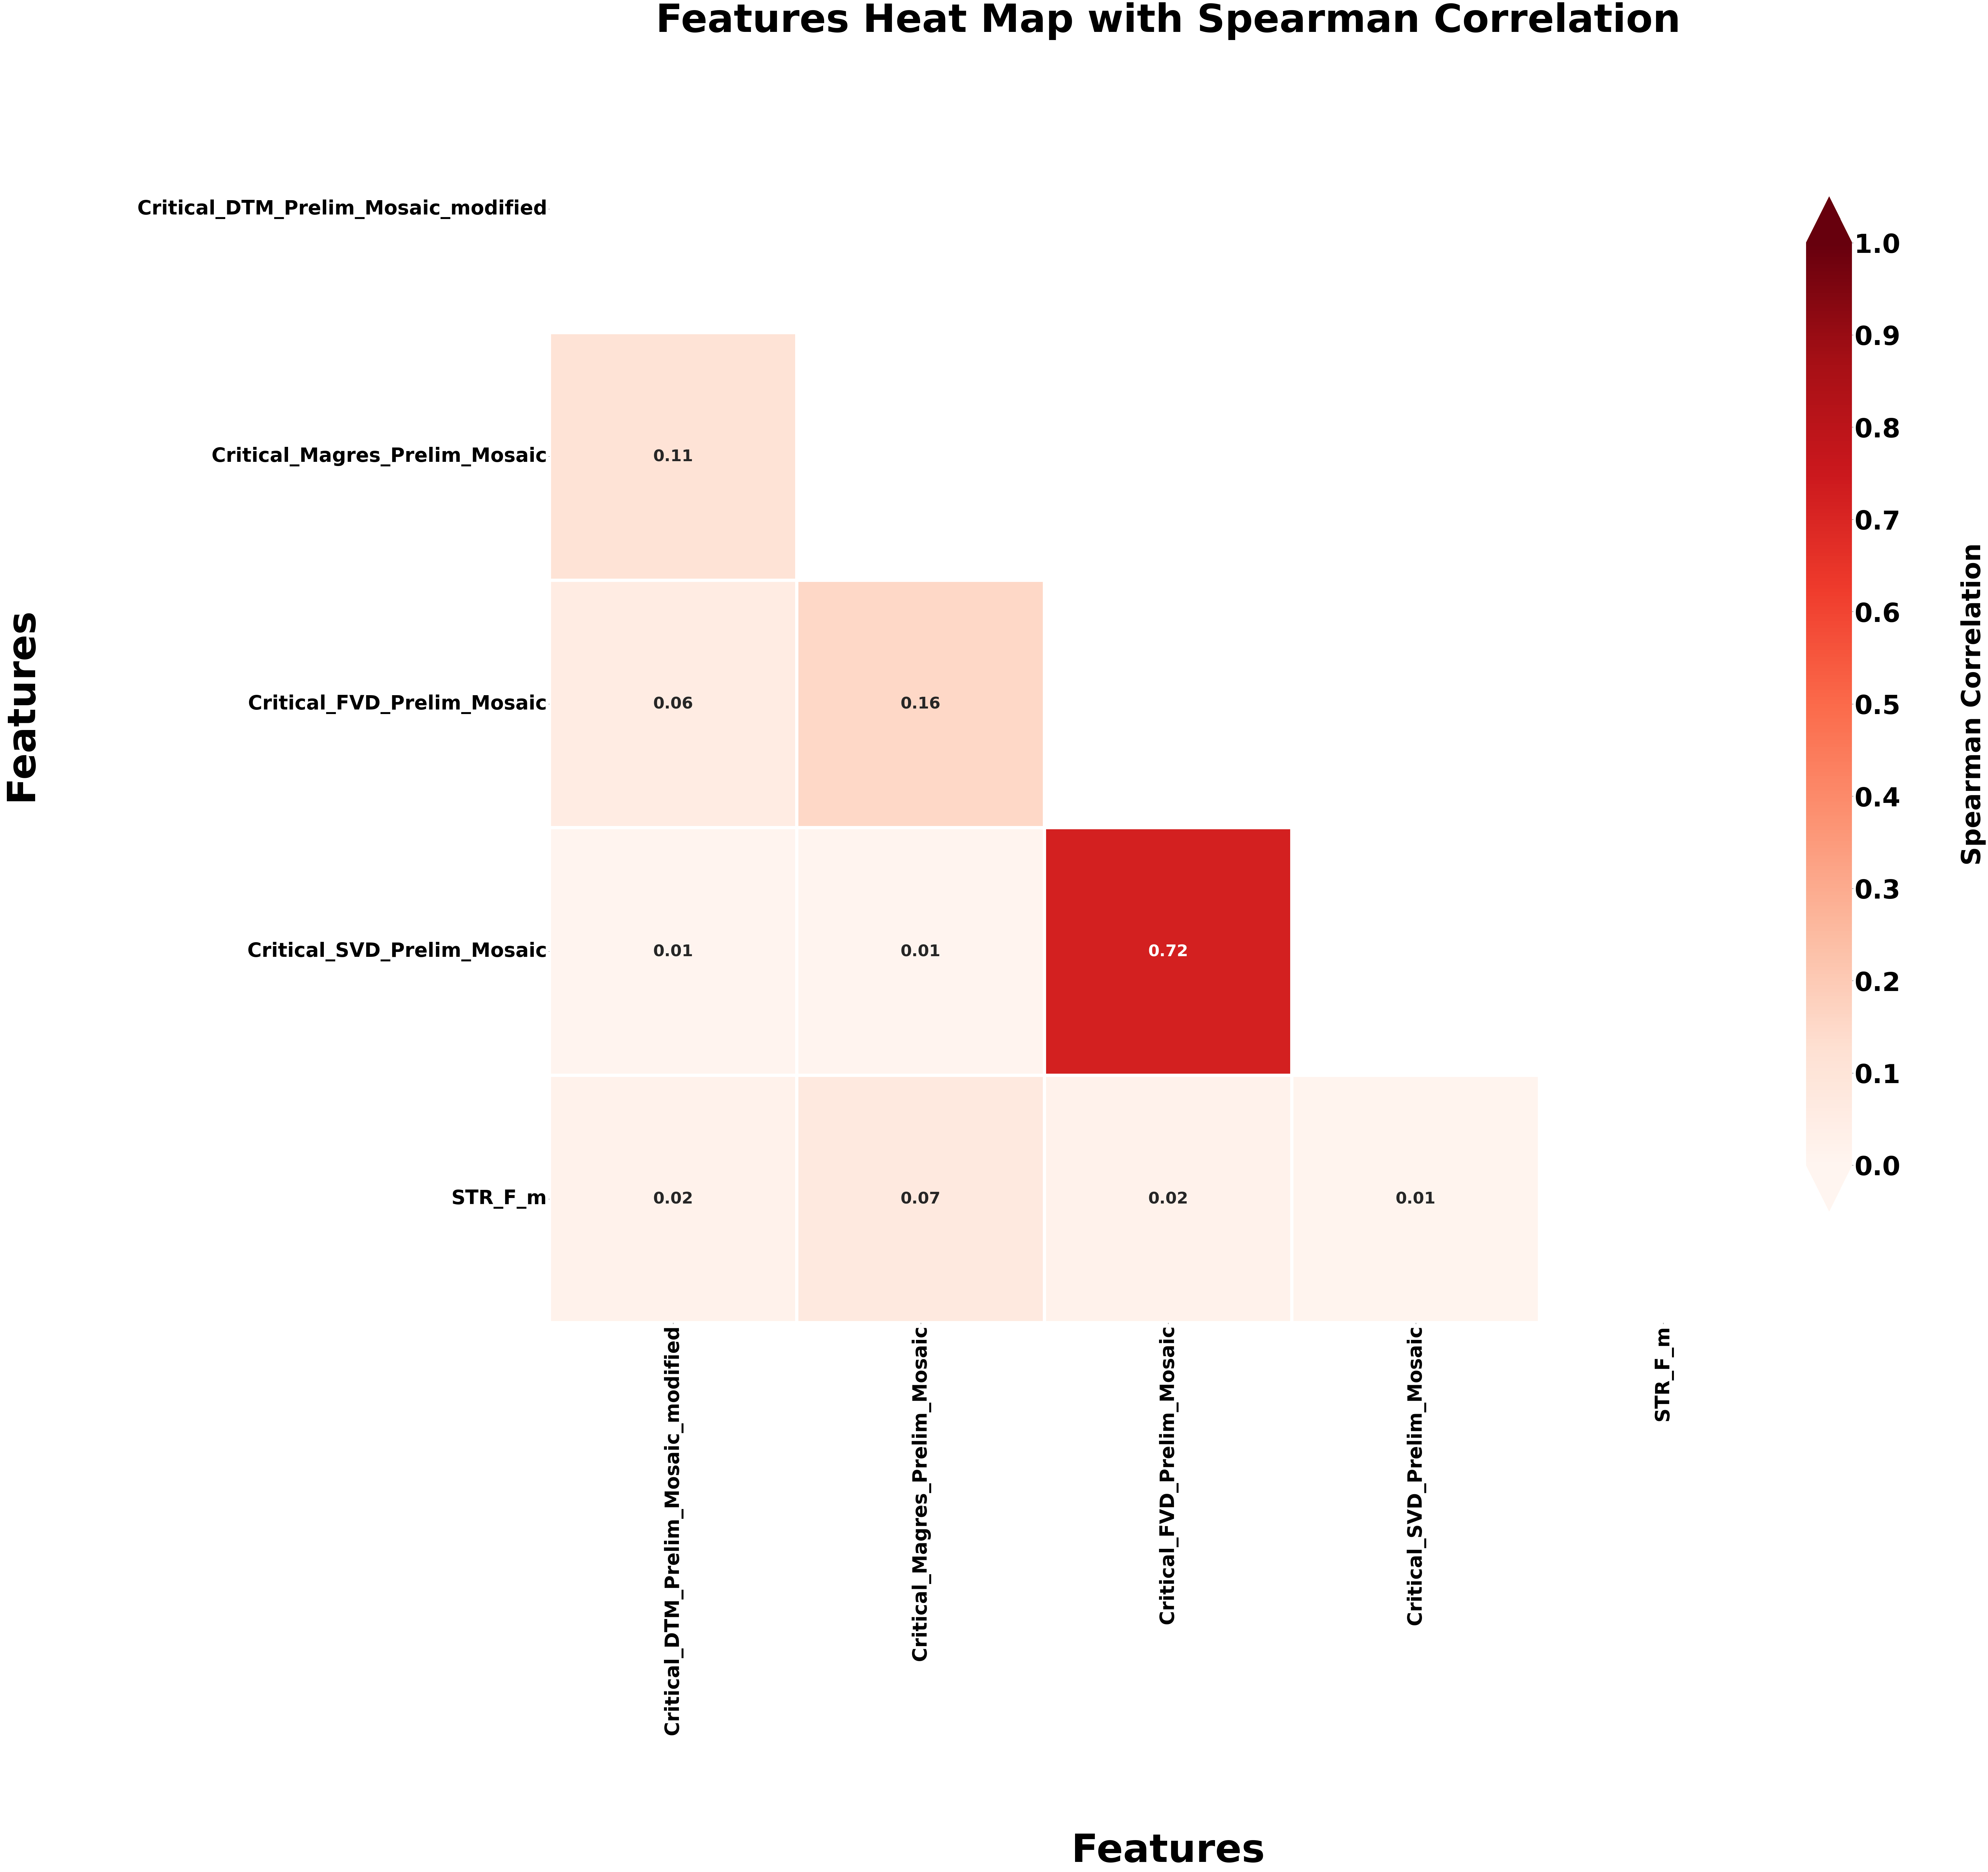

(<Figure size 7200x5760 with 2 Axes>,
 <AxesSubplot:title={'center':'Features Heat Map with Spearman Correlation\n'}, xlabel='\n\nFeatures', ylabel='Features\n\n'>)

In [181]:
correlation_matrix_plot(cube.df[columns['numerical']], 
                        reporting_folder, 
                        corr_threshold=None, 
                        method='spearman', 
                        annot=True) 

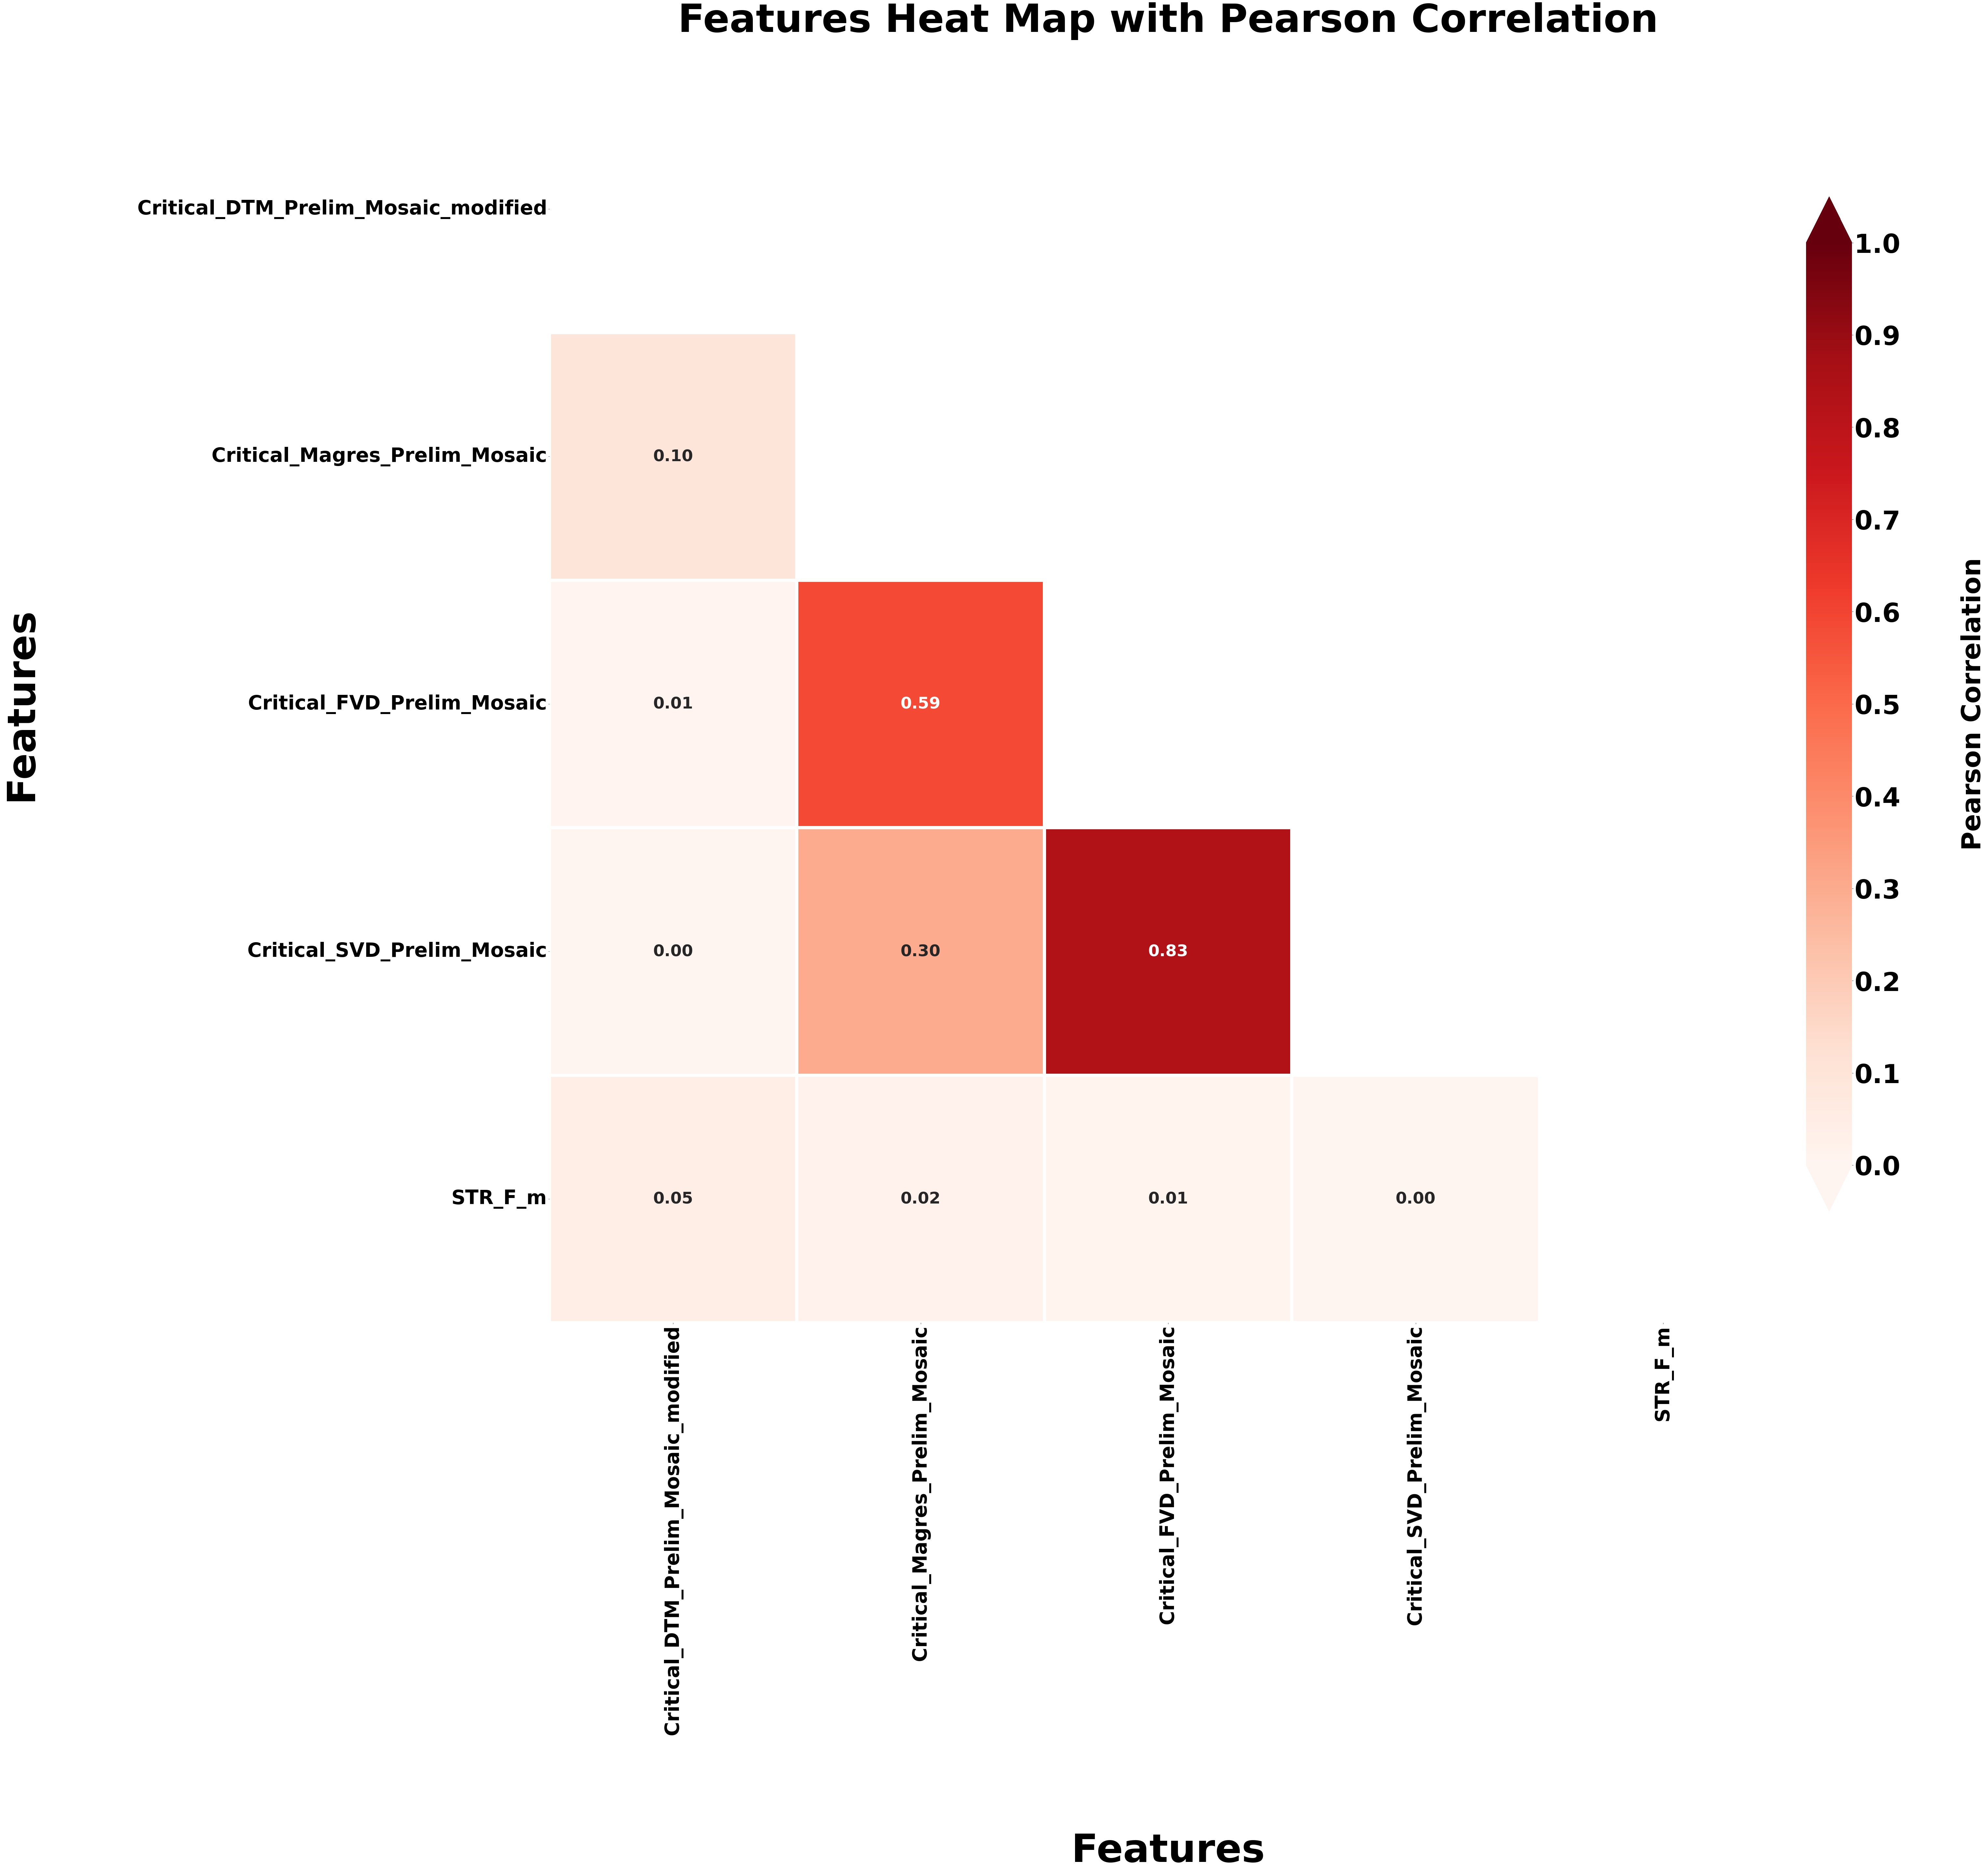

(<Figure size 7200x5760 with 2 Axes>,
 <AxesSubplot:title={'center':'Features Heat Map with Pearson Correlation\n'}, xlabel='\n\nFeatures', ylabel='Features\n\n'>)

In [182]:
correlation_matrix_plot(cube.df[columns['numerical']], 
                        reporting_folder, 
                        corr_threshold=None, 
                        method='pearson', 
                        annot=True) 